In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from colour import Color
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [13]:
probs = np.load('/data2/nathan/embryo/model/lateFusion/0.001lr_15inch/probs2.npy')

In [12]:
probs = []
for i in range(len(prob)):
    probs.extend(prob[i].cpu().numpy().tolist())

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [8]:
del prob

NameError: name 'prob' is not defined

In [14]:
probs = np.asarray(probs)

In [15]:
trans = probs[:,-1]

In [16]:
transsig = [1.0/(1.0+math.exp(-x)) for x in trans]

In [17]:
target = np.load('/home/nathan/embryo/val/labelIndex.npy')

In [18]:
len(target)

21798

In [19]:
def softmax(probs):
    esum = sum([math.exp(x) for x in probs])
    return [math.exp(x)/esum for x in probs]

In [20]:
stages = probs

In [21]:
stages = [softmax(x) for x in stages]

In [22]:
stages = np.asarray(stages)

In [23]:
preds = [np.argmax(x) for x in stages]

video: 1
0 to 305


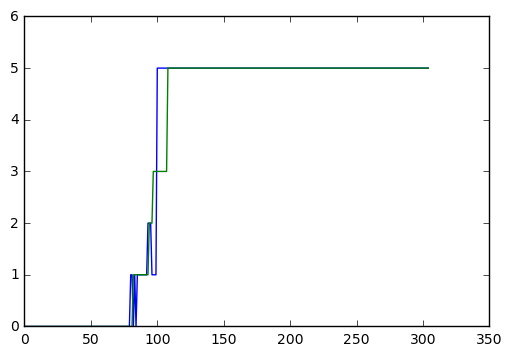

video: 2
305 to 611


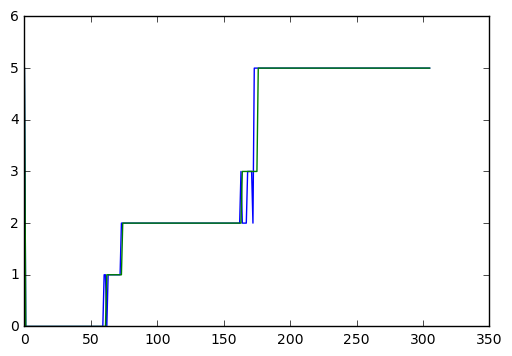

video: 3
611 to 917


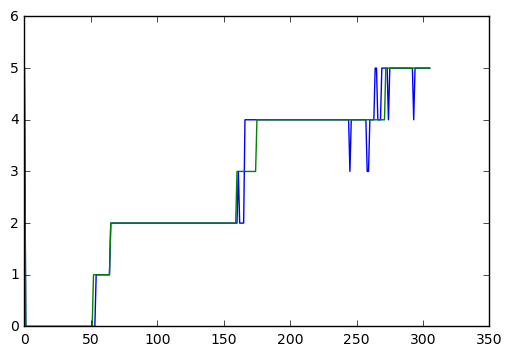

video: 4
917 to 1223


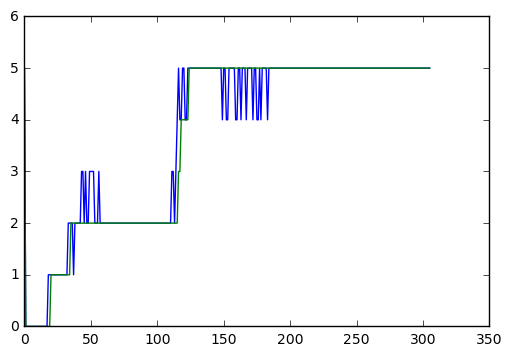

video: 5
1223 to 1529


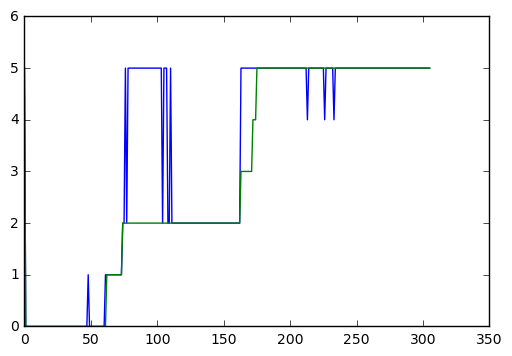

video: 6
1529 to 1835


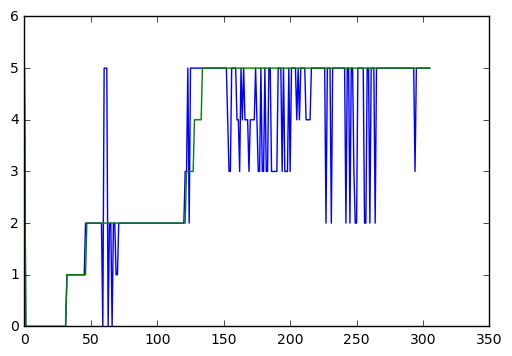

video: 7
1835 to 2141


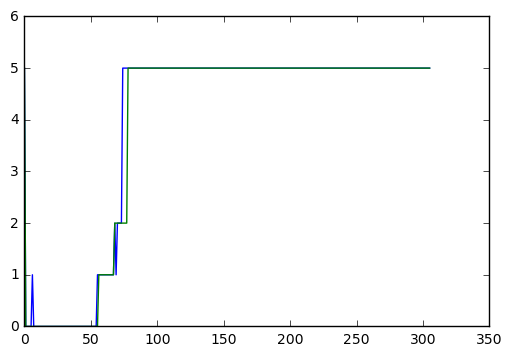

video: 8
2141 to 2447


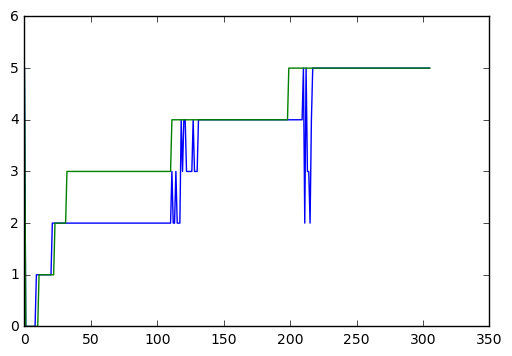

video: 9
2447 to 2758


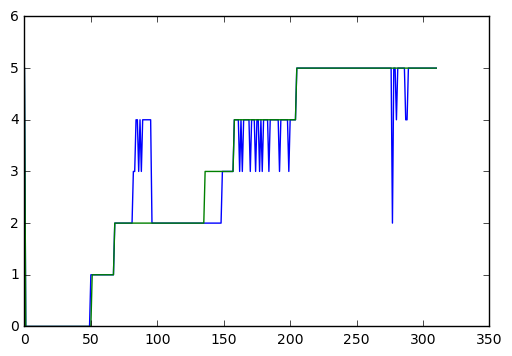

video: 10
2758 to 3069


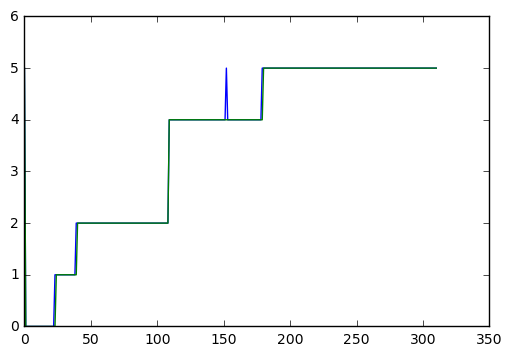

video: 11
3069 to 3380


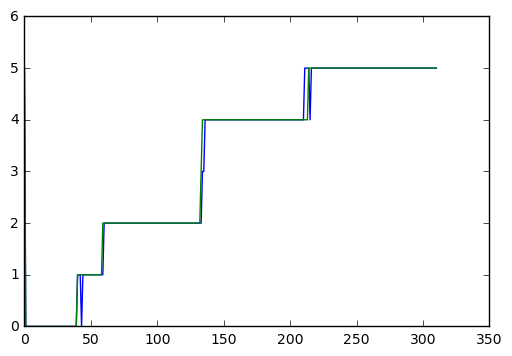

video: 12
3380 to 3684


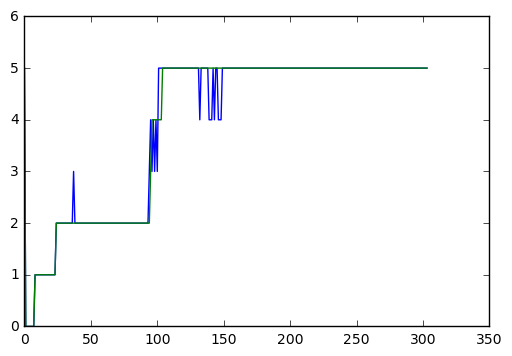

video: 13
3684 to 3988


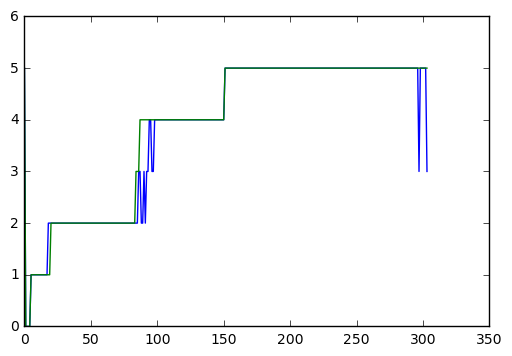

video: 14
3988 to 4292


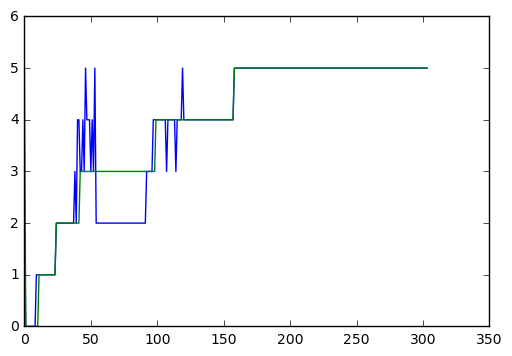

video: 15
4292 to 4596


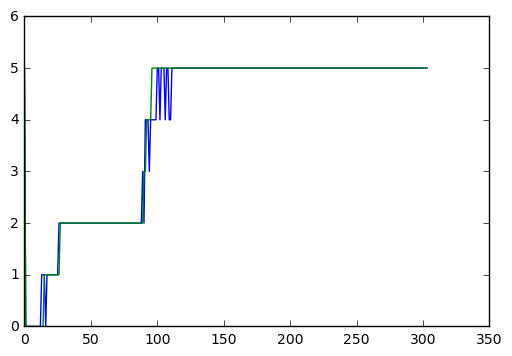

video: 16
4596 to 4900


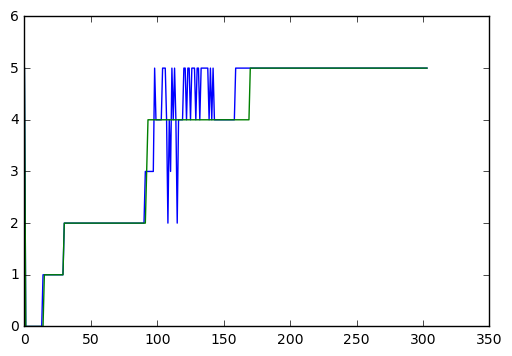

video: 17
4900 to 5204


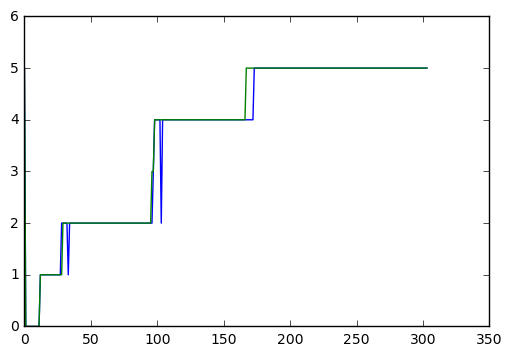

video: 18
5204 to 5508


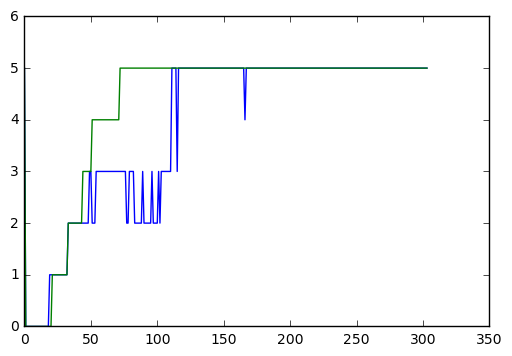

video: 19
5508 to 5812


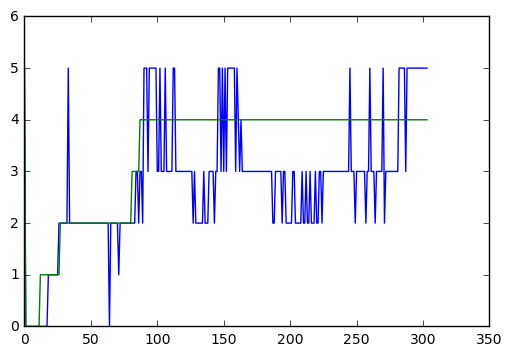

video: 20
5812 to 6126


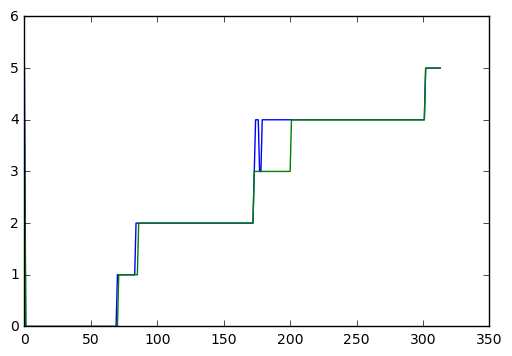

video: 21
6126 to 6440


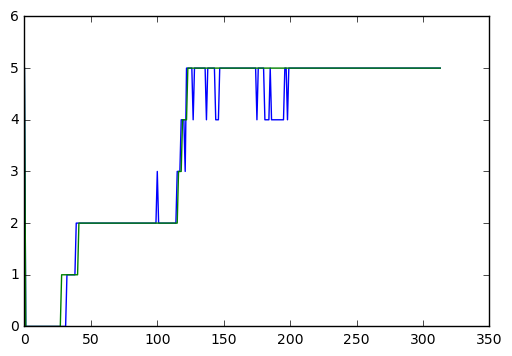

video: 22
6440 to 6754


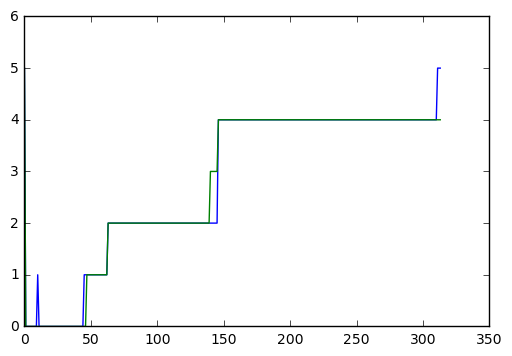

video: 23
6754 to 7068


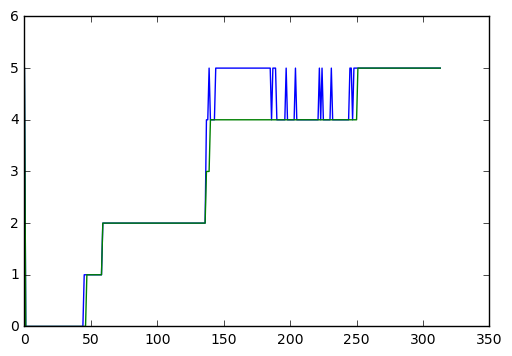

video: 24
7068 to 7382


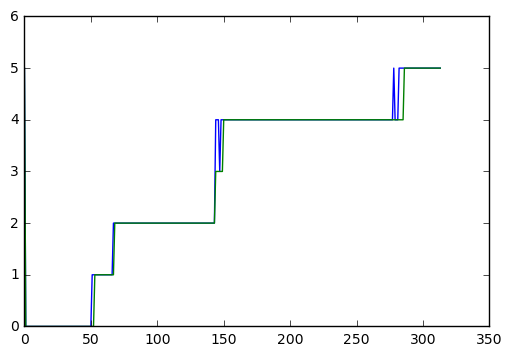

video: 25
7382 to 7688


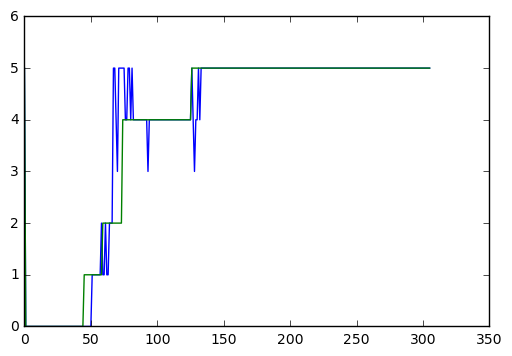

video: 26
7688 to 7994


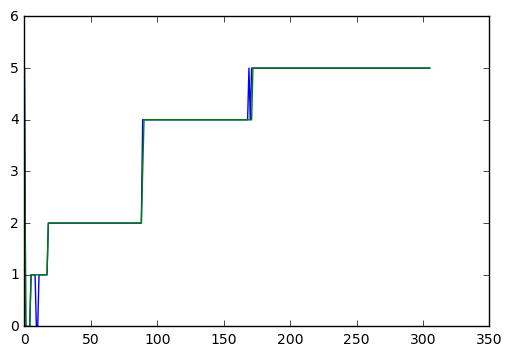

video: 27
7994 to 8300


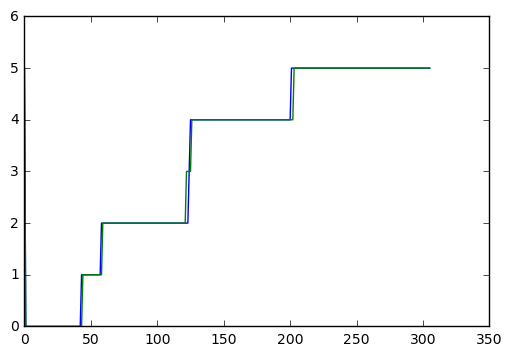

video: 28
8300 to 8606


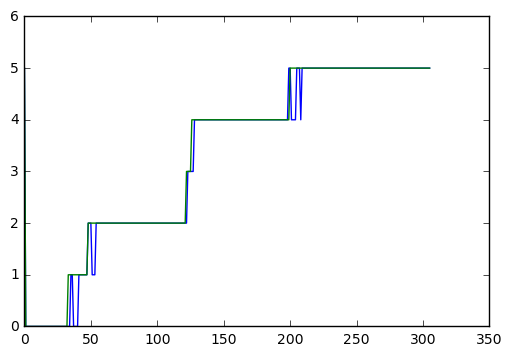

video: 29
8606 to 8912


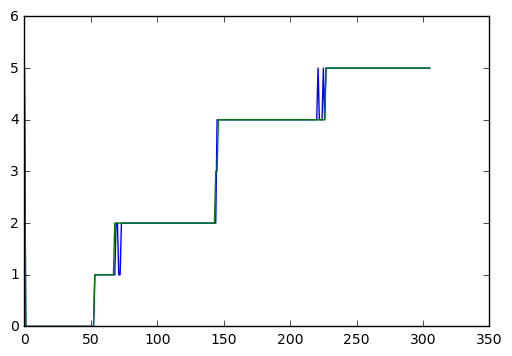

video: 30
8912 to 9218


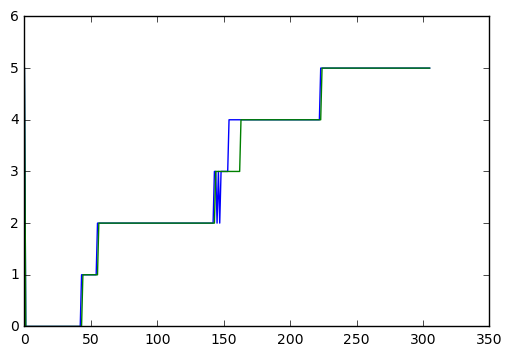

video: 31
9218 to 9524


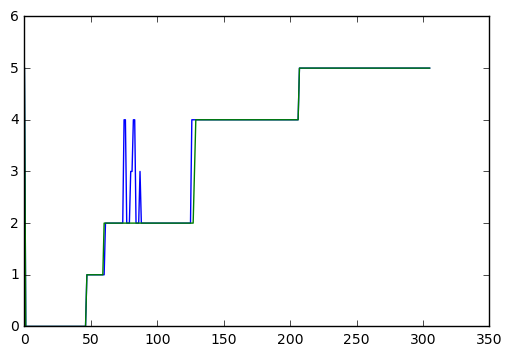

video: 32
9524 to 9832


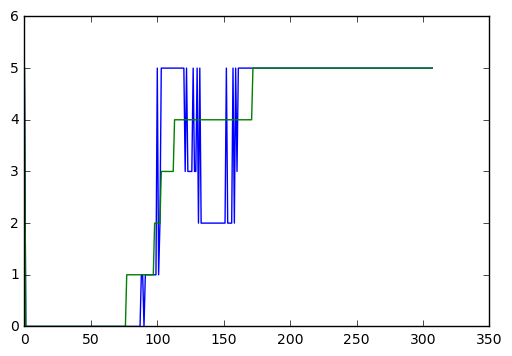

video: 33
9832 to 10140


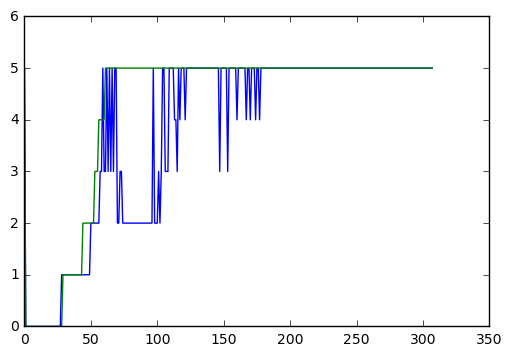

video: 34
10140 to 10448


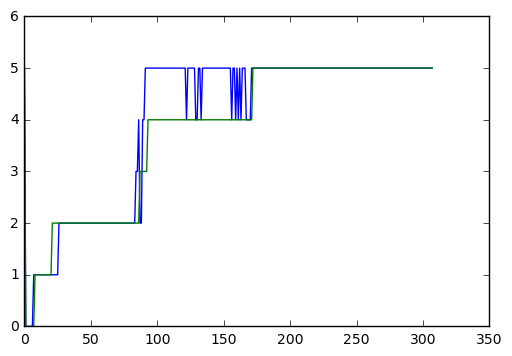

video: 35
10448 to 10756


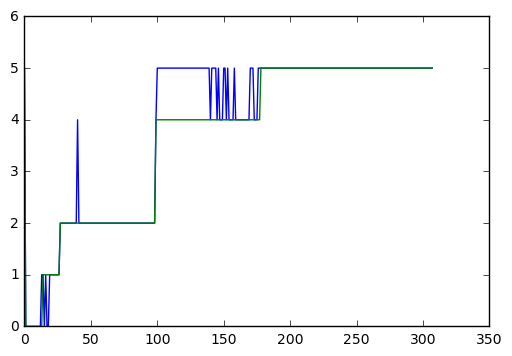

video: 36
10756 to 11064


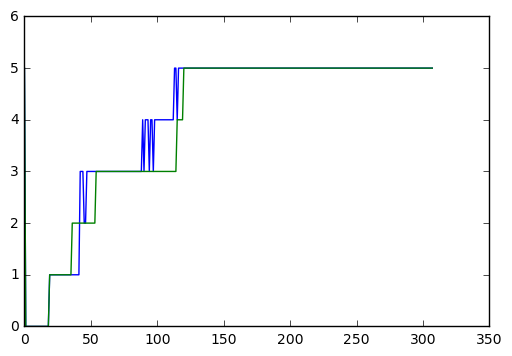

video: 37
11064 to 11372


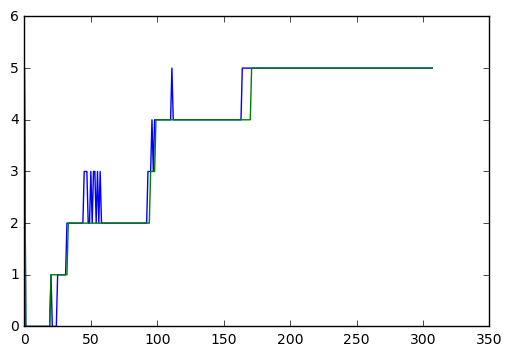

video: 38
11372 to 11680


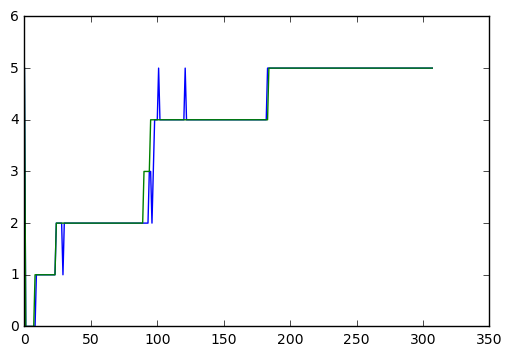

video: 39
11680 to 11988


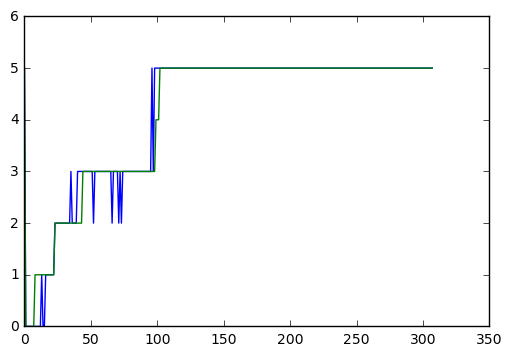

video: 40
11988 to 12296


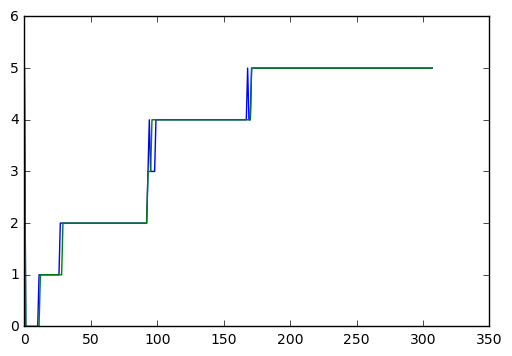

video: 41
12296 to 12604


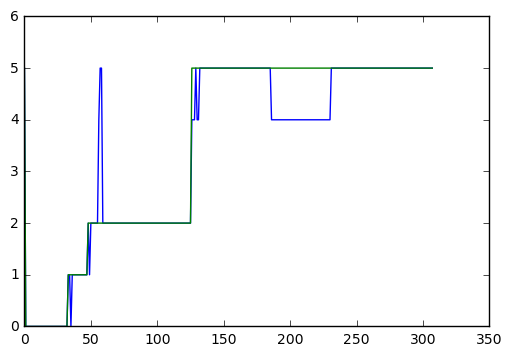

video: 42
12604 to 12912


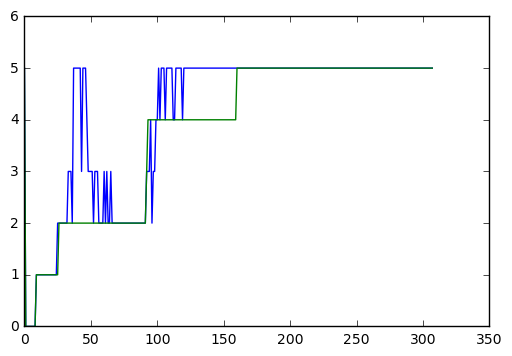

video: 43
12912 to 13220


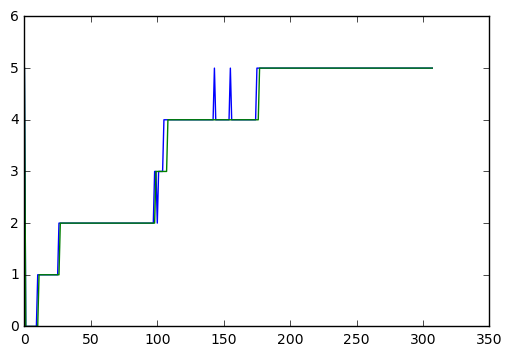

video: 44
13220 to 13528


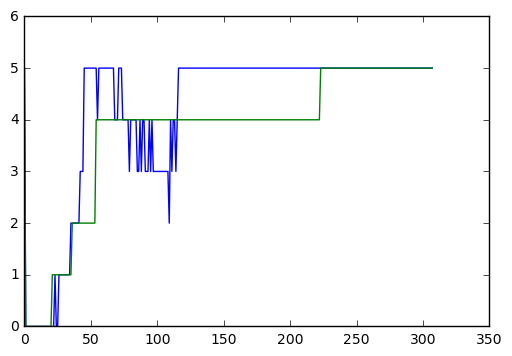

video: 45
13528 to 13836


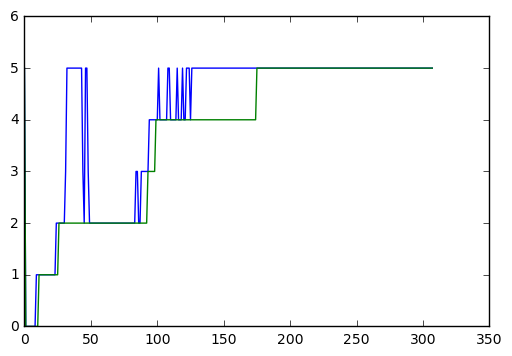

video: 46
13836 to 14139


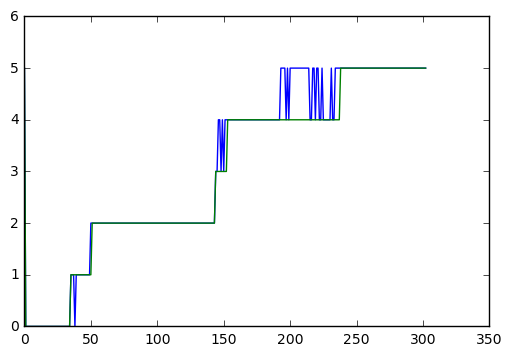

video: 47
14139 to 14442


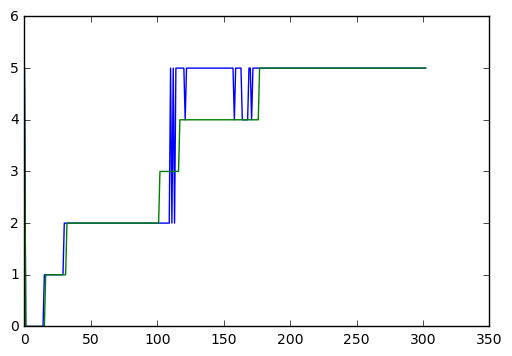

video: 48
14442 to 14745


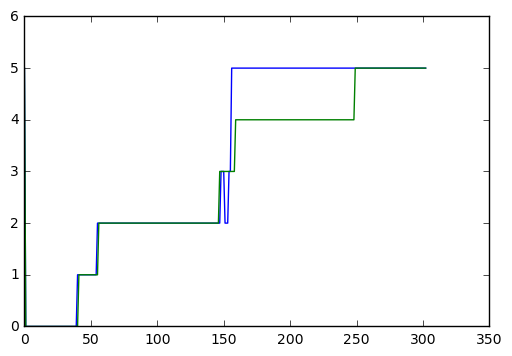

video: 49
14745 to 15048


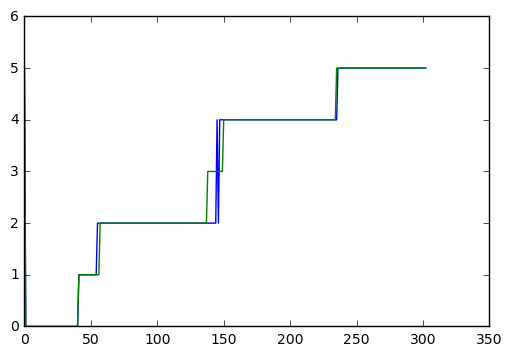

video: 50
15048 to 15351


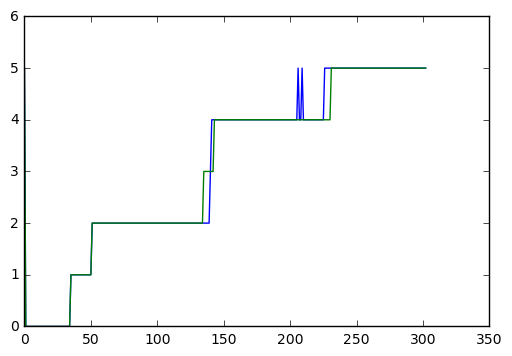

video: 51
15351 to 15659


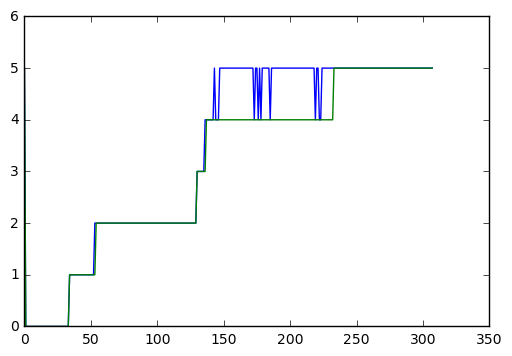

video: 52
15659 to 15967


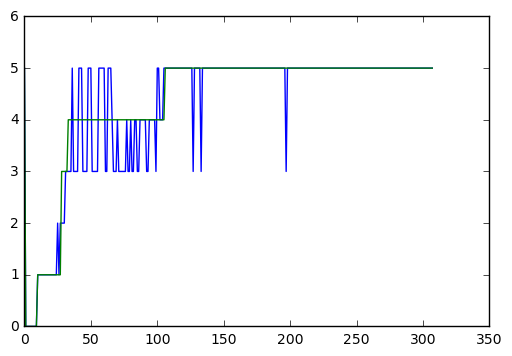

video: 53
15967 to 16275


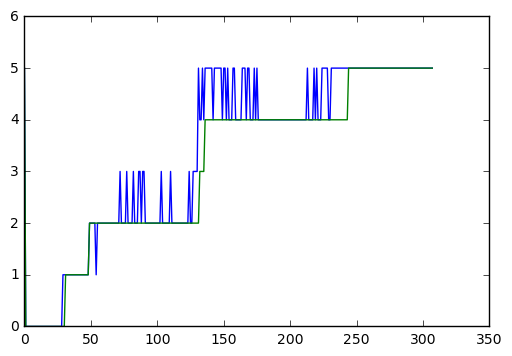

video: 54
16275 to 16583


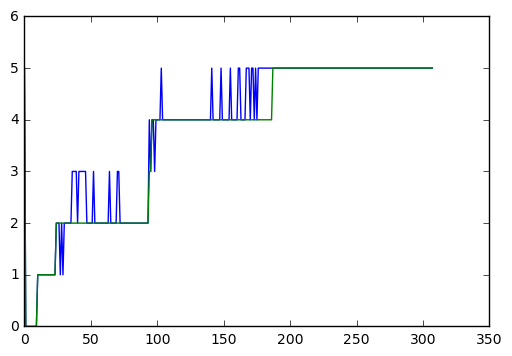

video: 55
16583 to 16891


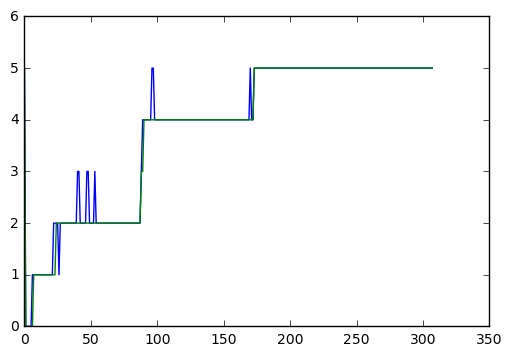

video: 56
16891 to 17199


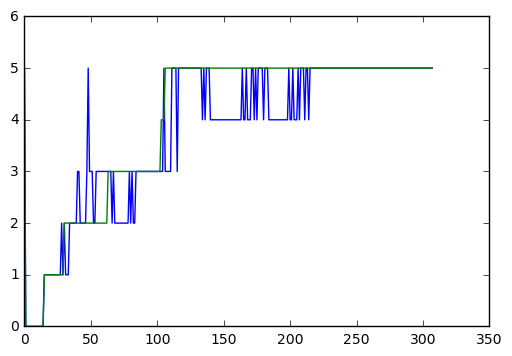

video: 57
17199 to 17507


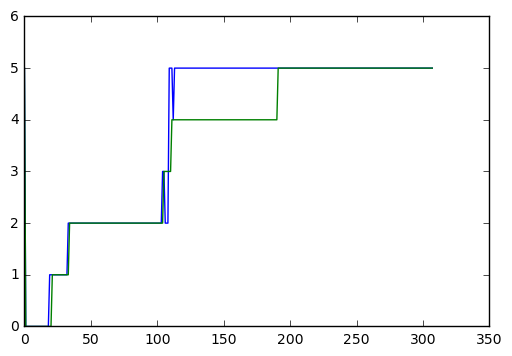

video: 58
17507 to 17815


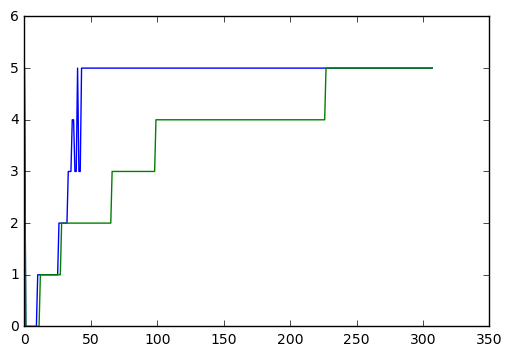

video: 59
17815 to 18123


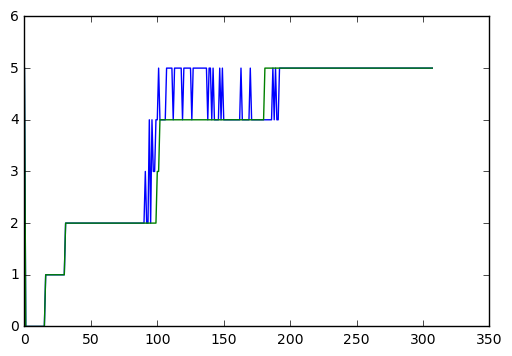

video: 60
18123 to 18431


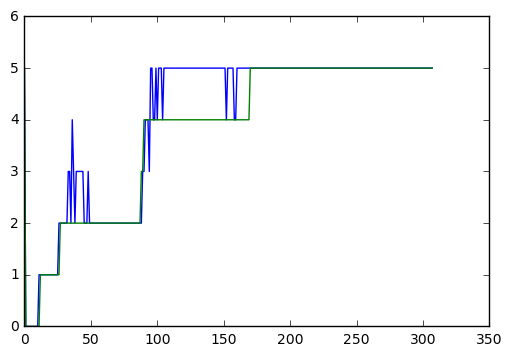

video: 61
18431 to 18737


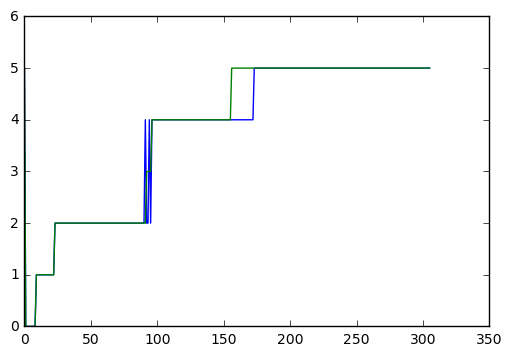

video: 62
18737 to 19043


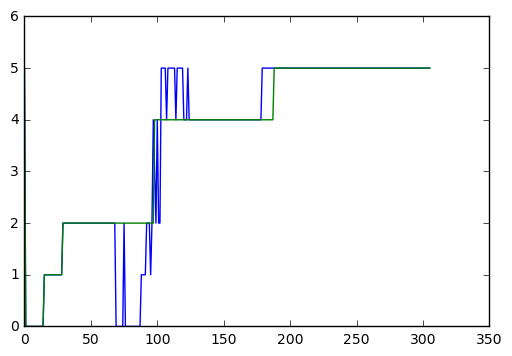

video: 63
19043 to 19349


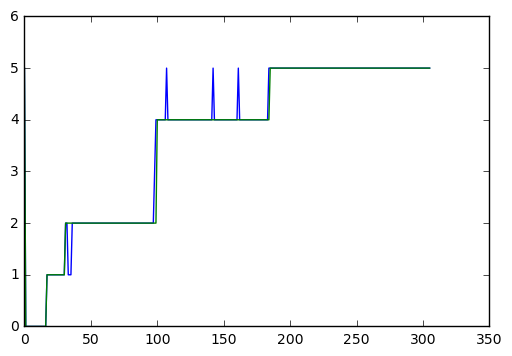

video: 64
19349 to 19655


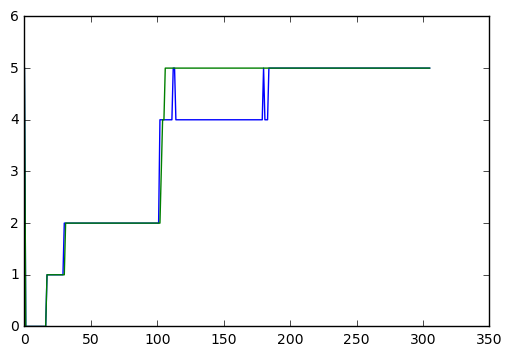

video: 65
19655 to 19961


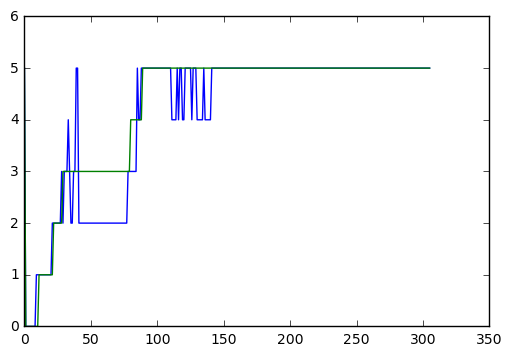

video: 66
19961 to 20267


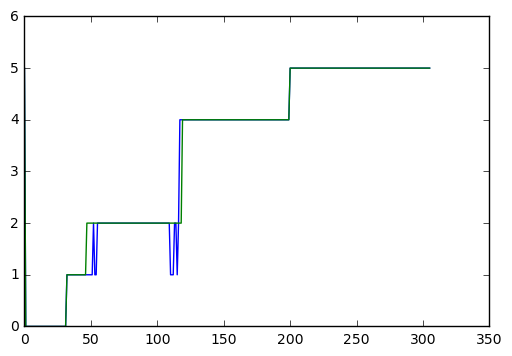

video: 67
20267 to 20573


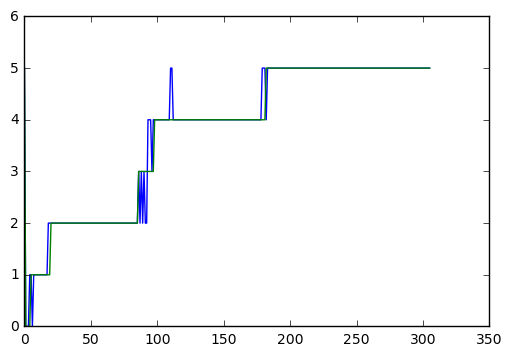

video: 68
20573 to 20879


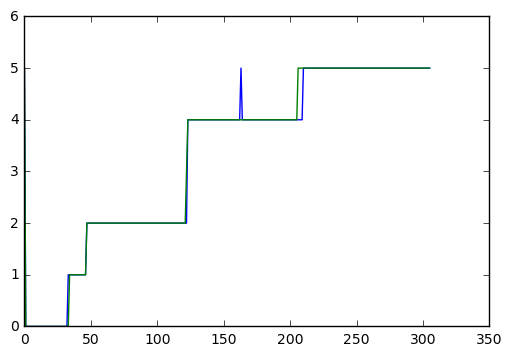

video: 69
20879 to 21185


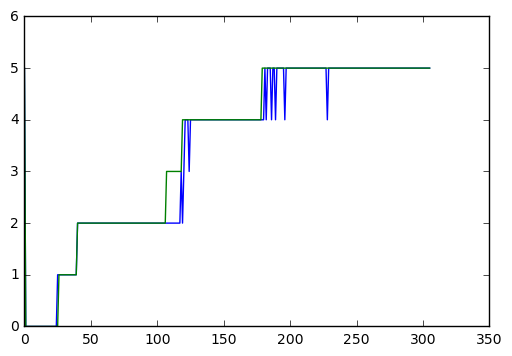

video: 70
21185 to 21491


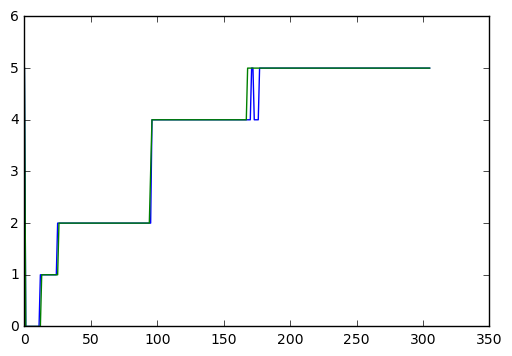

IndexError: index 21798 is out of bounds for axis 0 with size 21798

In [14]:
last = 0
vid = 1
for i in range(len(target)):
    if target[i] > target[i+1]:
        print("video: " + str(vid))
        print(str(last) + " to " + str(i))
        plt.plot(np.asarray(preds)[last:i])
        plt.plot(target[last:i])
        #plt.plot(np.asarray(transsig[last:i])*6.0)
        plt.ylim(0, 6)
        plt.show()
        last = i
        vid += 1

In [24]:
stages = np.asarray(stages)

In [25]:
def log_err(prob, n):
    err = np.zeros((n,n))
    for i in range(n):
        err[i][i] = -np.log(prob[i])
    for i in range(n):
        for j in range(i+1, n):
            if i == 0:
                err[i][j] = err[i][j-1] - np.log(prob[j])
            else:
                err[i][j] = err[i-1][j] - err[i-1][j-1] + err[i][j-1]
    return err

In [26]:
a = np.asarray([0.1,0.2,0.3])
b = np.asarray([1,2,3])
np.sum(a*b)

1.3999999999999999

In [27]:
def earth_err(prob, n, stage):
    err = np.zeros((n,n))
    stagenums = np.asarray([0,1,2,3,4,5])
    for i in range(n):
        err[i][i] = np.abs(stage - np.sum(prob[i] * stagenums))
    for i in range(n):
        for j in range(i+1, n):
            if i == 0:
                err[i][j] = err[i][j-1] + np.abs(stage - np.sum(prob[j] * stagenums))
            else:
                err[i][j] = err[i-1][j] - err[i-1][j-1] + err[i][j-1]
    return err

In [28]:
def find_splits(stages, n, log):
    err = []
    for i in range(n):
        if(log):
            e1 = log_err(stages[:,i], len(stages))
        else:
            e1 = earth_err(stages, len(stages), i)
        err.append(e1)
    stageErr = np.zeros((n, len(stages)))
    prevSplit = np.zeros((n, len(stages)))
    for i in range(n):
        for j in range(1,len(stages)):
            if i == 0:
                stageErr[i][j] = err[i][0][j]
                prevSplit[i][j] = j
            else:
                tempErr = []
                for k in range(j):
                    tempErr.append( \
                        stageErr[i-1][k] + \
                        err[i][k][j]
                    )
                prevSplit[i][j] = tempErr.index(min(tempErr))
                stageErr[i][j] = min(tempErr)
    splits = []
    for i in range(n):
        if len(splits) == 0:
            splits.append(prevSplit[n-i-1][len(stages)-1])
        else:
            splits.append(prevSplit[n-i-1][int(splits[-1])])
    return splits[::-1][1:]

In [29]:
def smooth_pred(splits, n, size):
    res = []
    for i in range(size):
        for j in range(n):
            if i > splits[-1]:
                res.append(n-1)
                break
            if i <= splits[j]:
                res.append(j)
                break
    return res

In [36]:
stages[0][0]

0.9943571880242128

video: 1
0 to 305


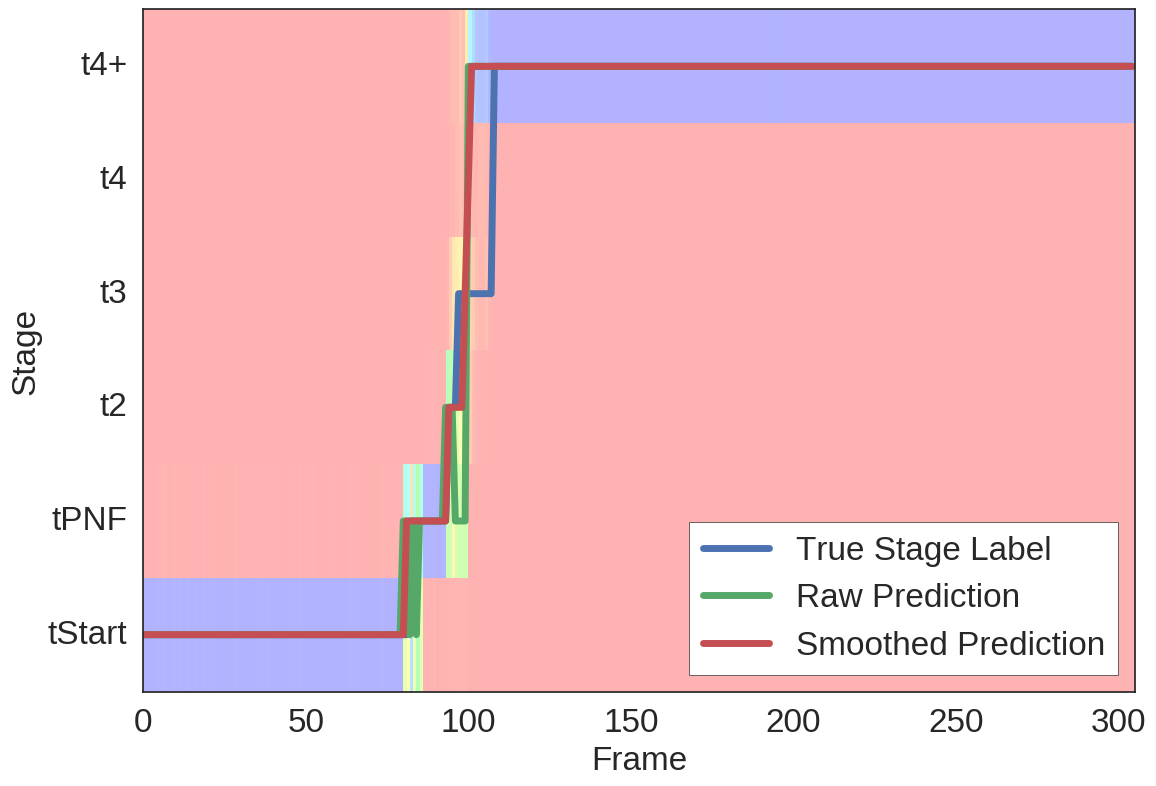

video: 2
305 to 611


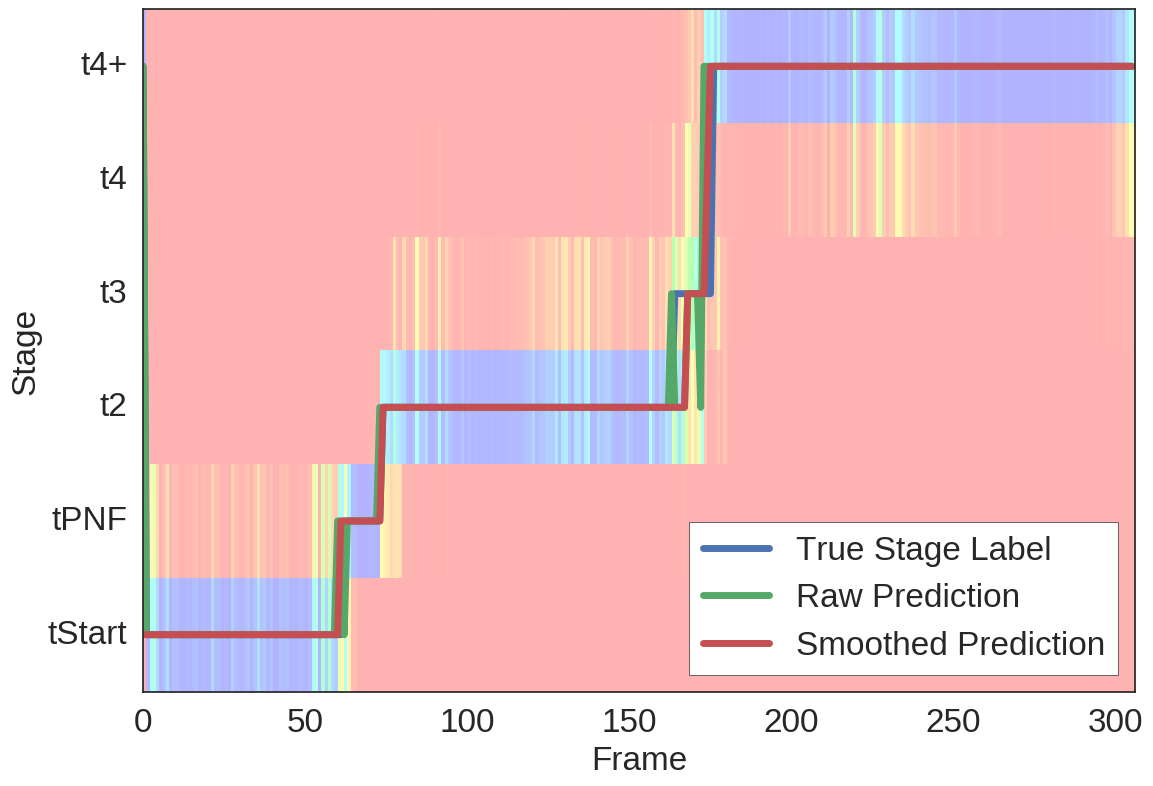

video: 3
611 to 917


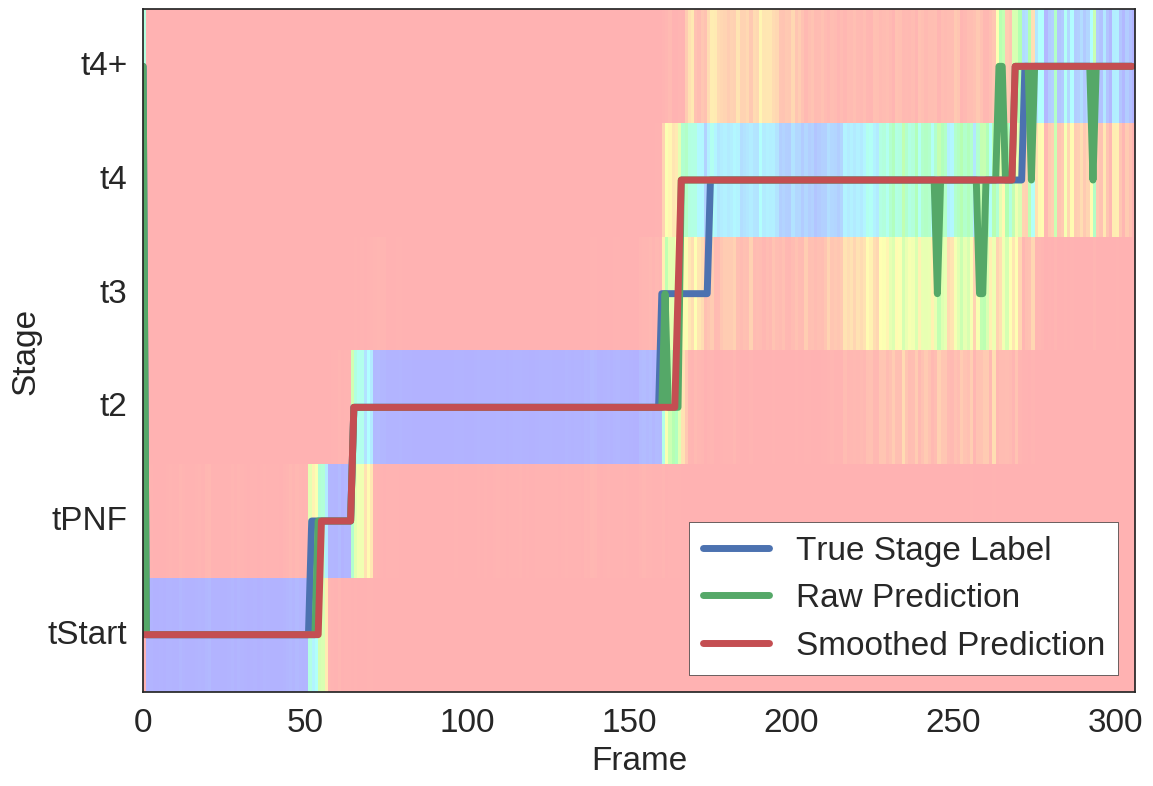

video: 4
917 to 1223


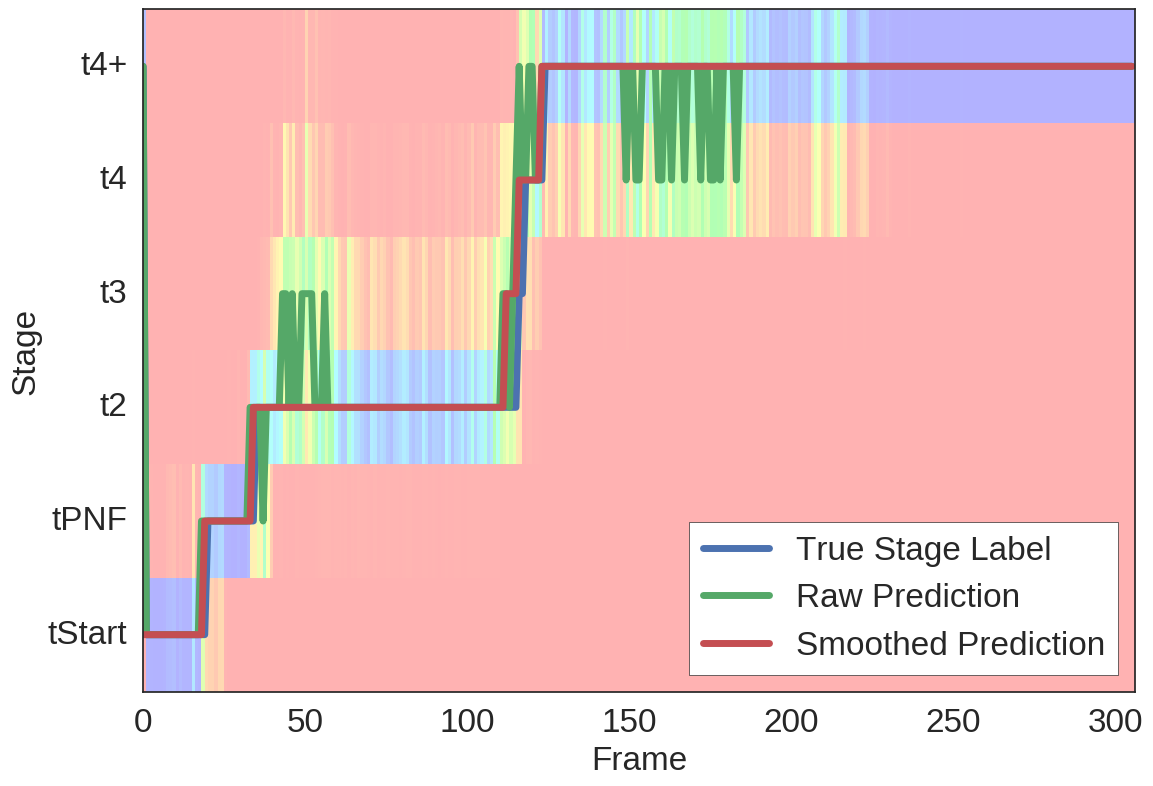

video: 5
1223 to 1529


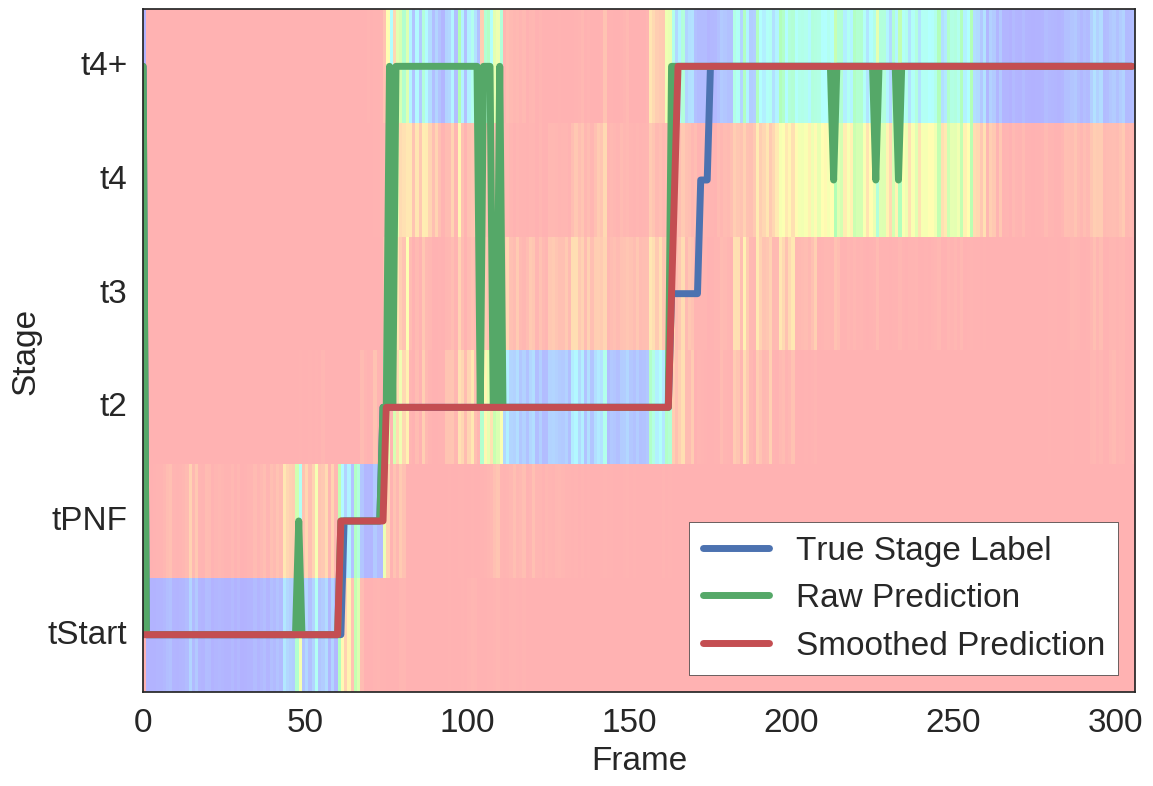

video: 6
1529 to 1835


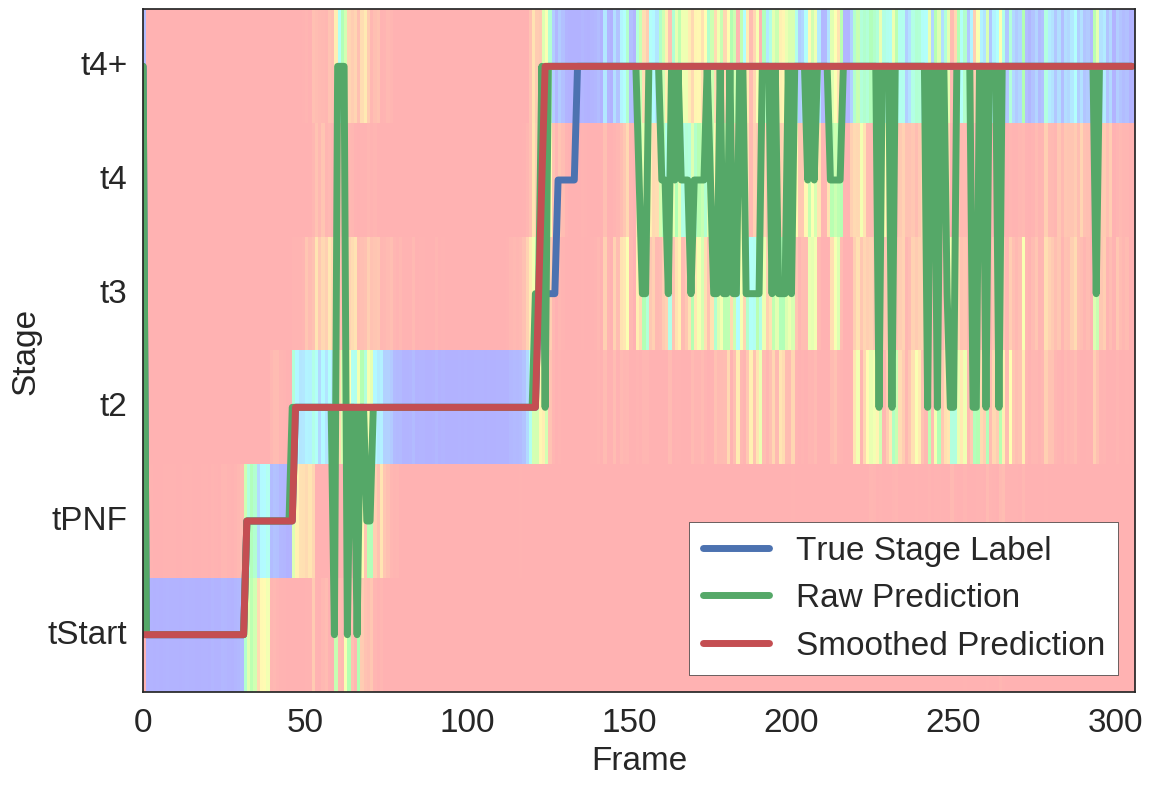

video: 7
1835 to 2141


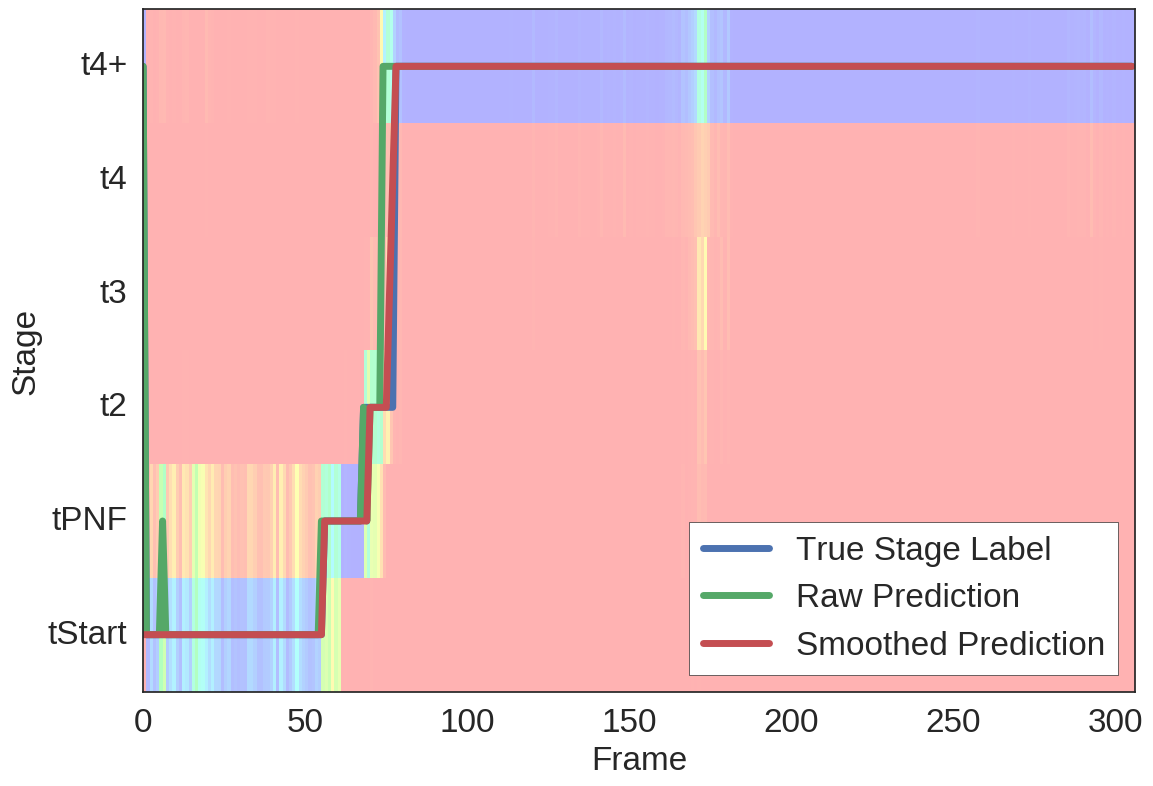

video: 8
2141 to 2447


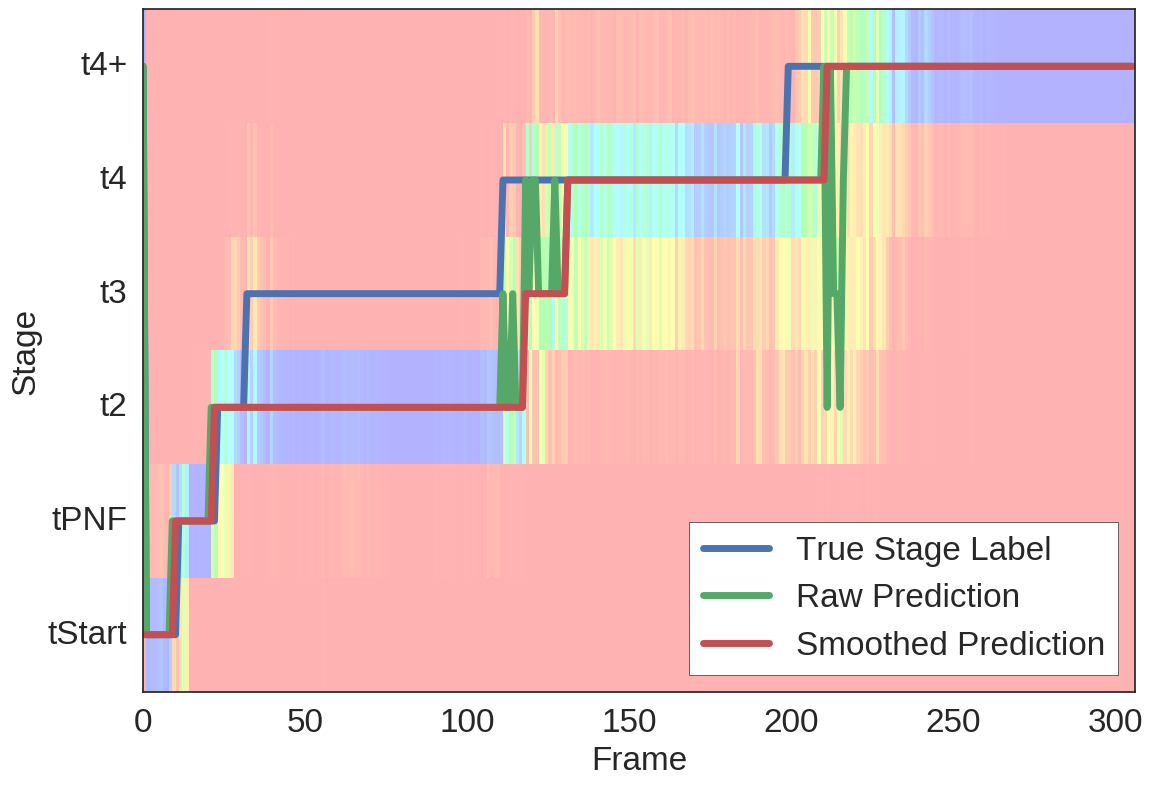

video: 9
2447 to 2758


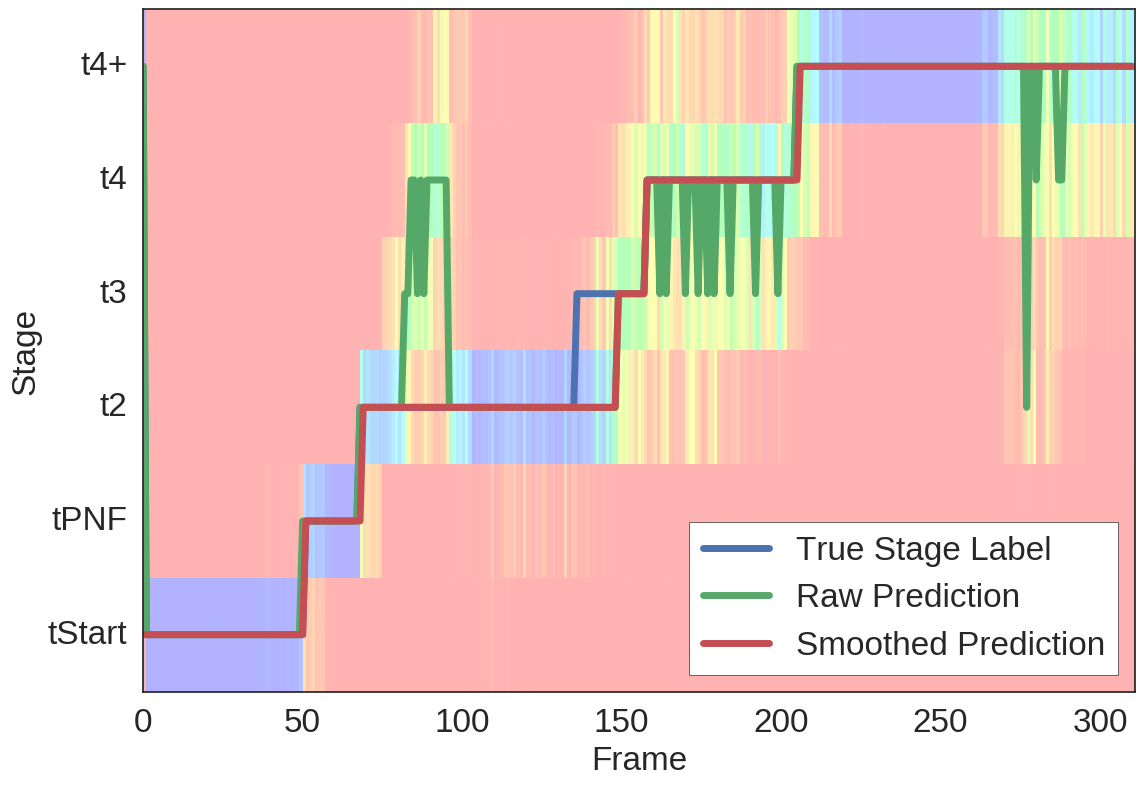

video: 10
2758 to 3069


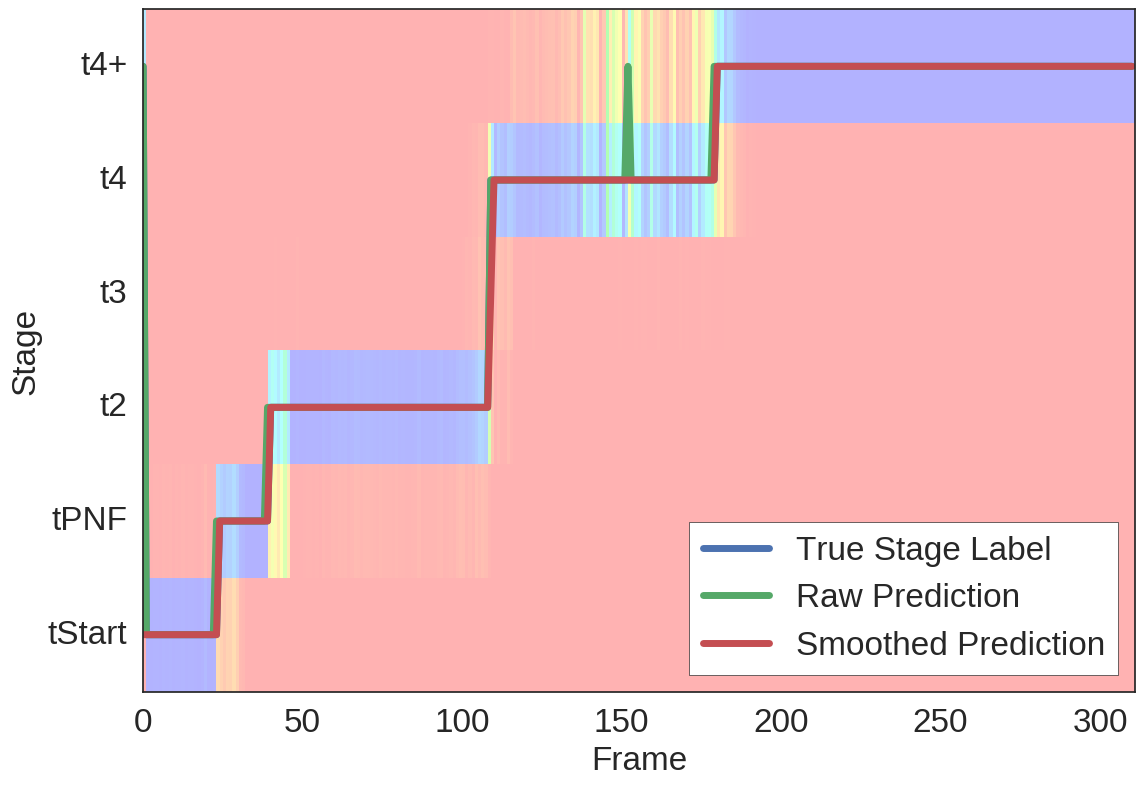

video: 11
3069 to 3380


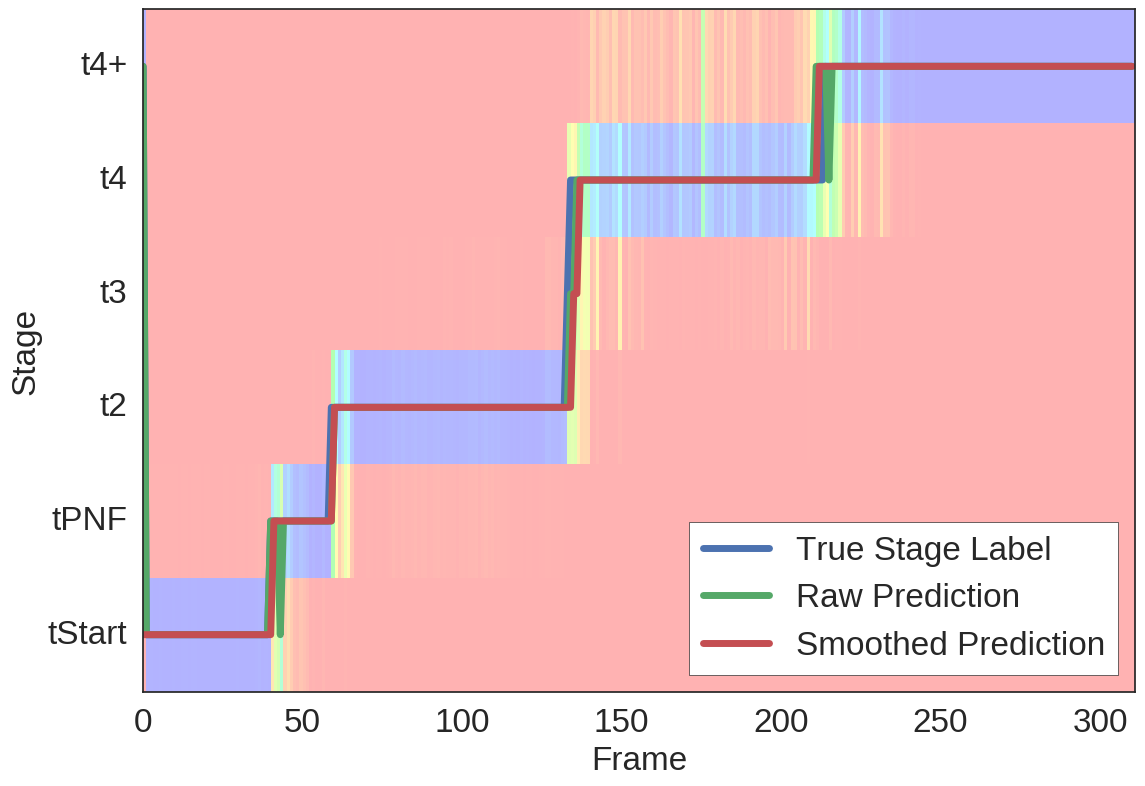

video: 12
3380 to 3684


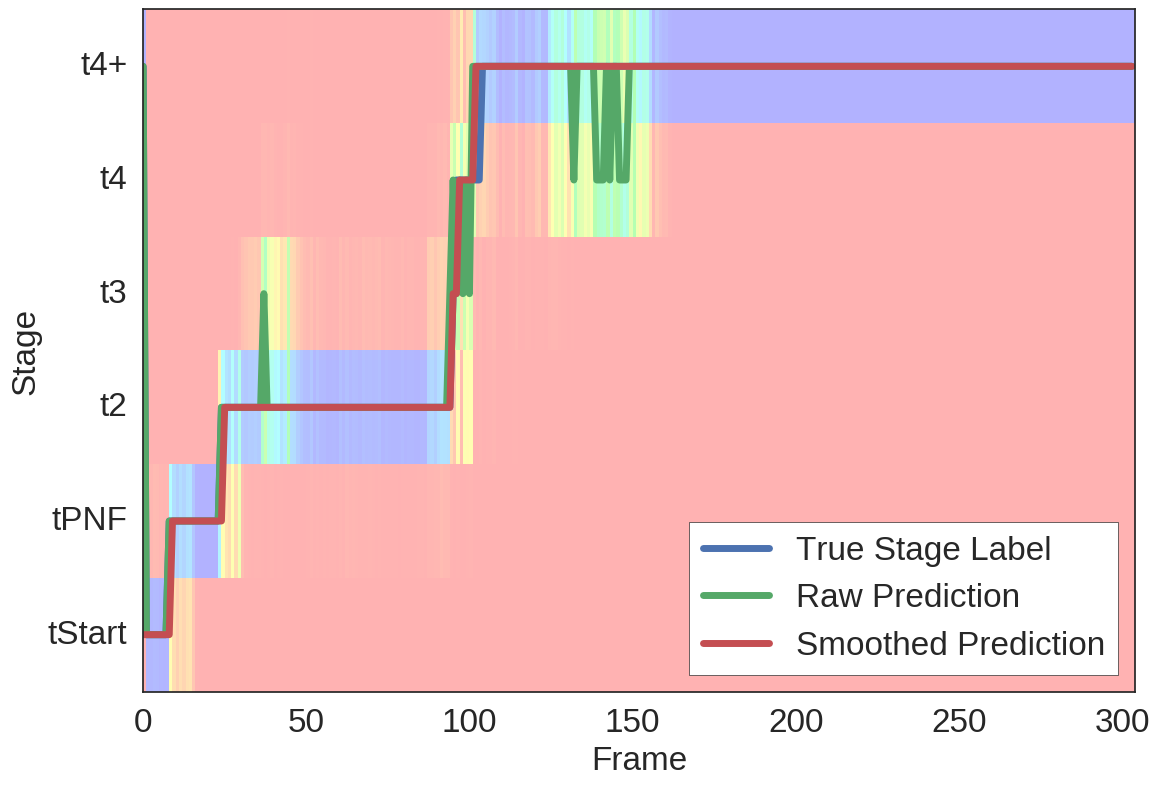

video: 13
3684 to 3988


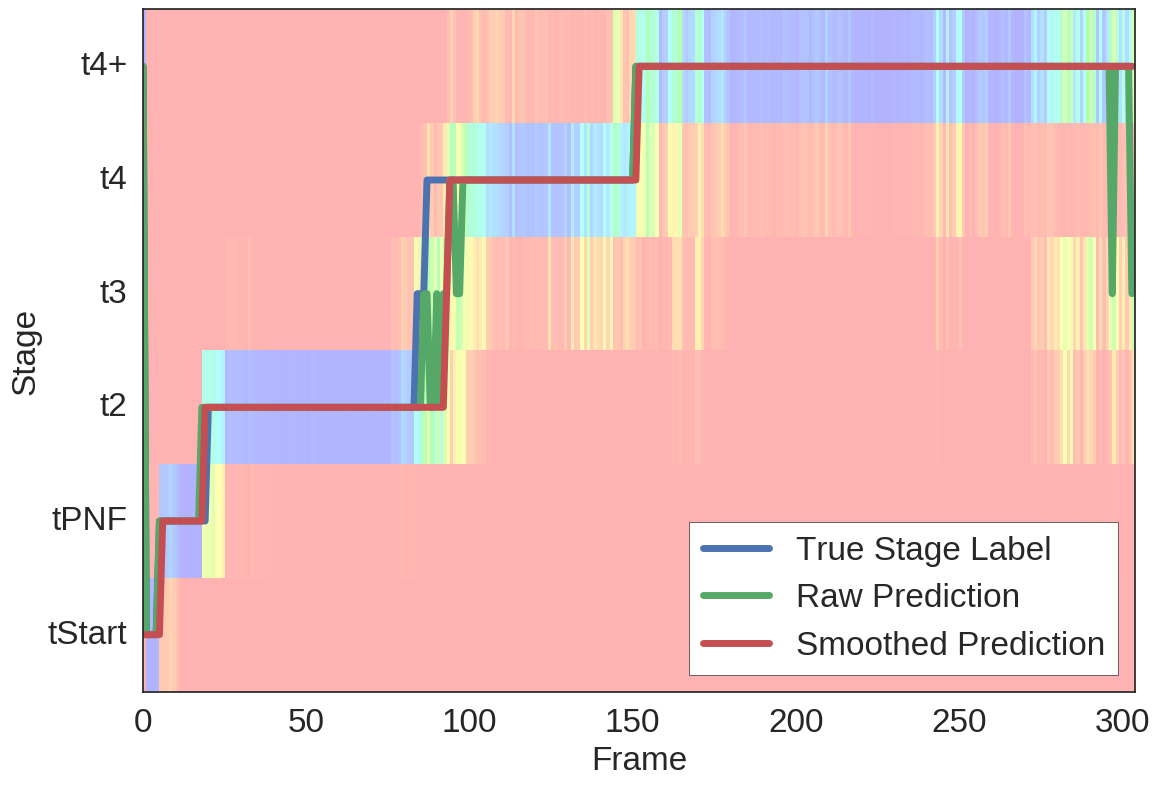

video: 14
3988 to 4292


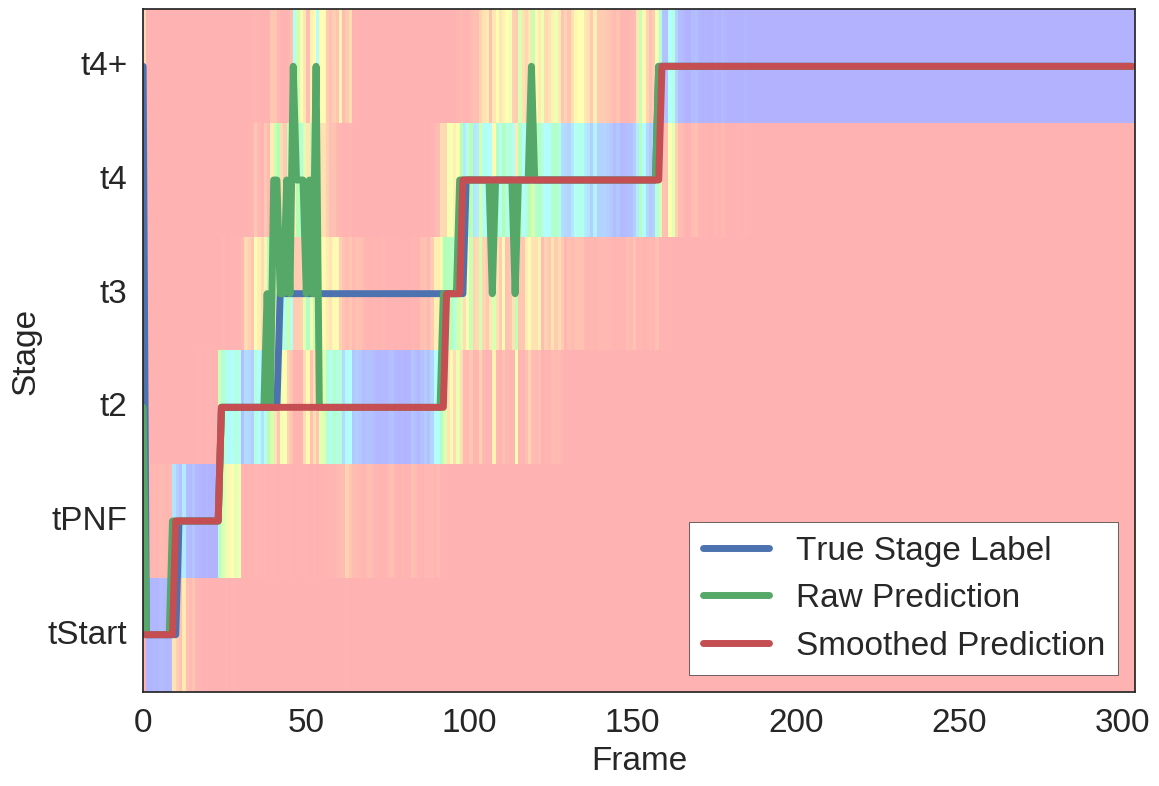

video: 15
4292 to 4596


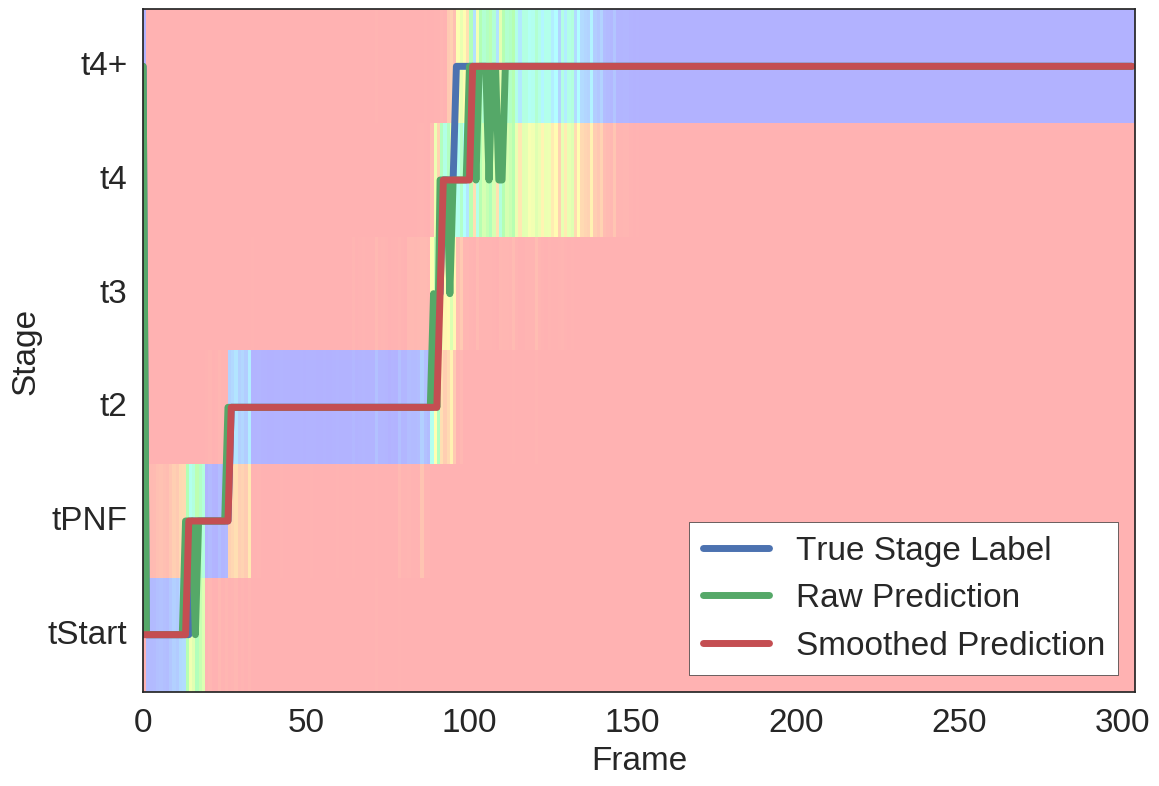

video: 16
4596 to 4900


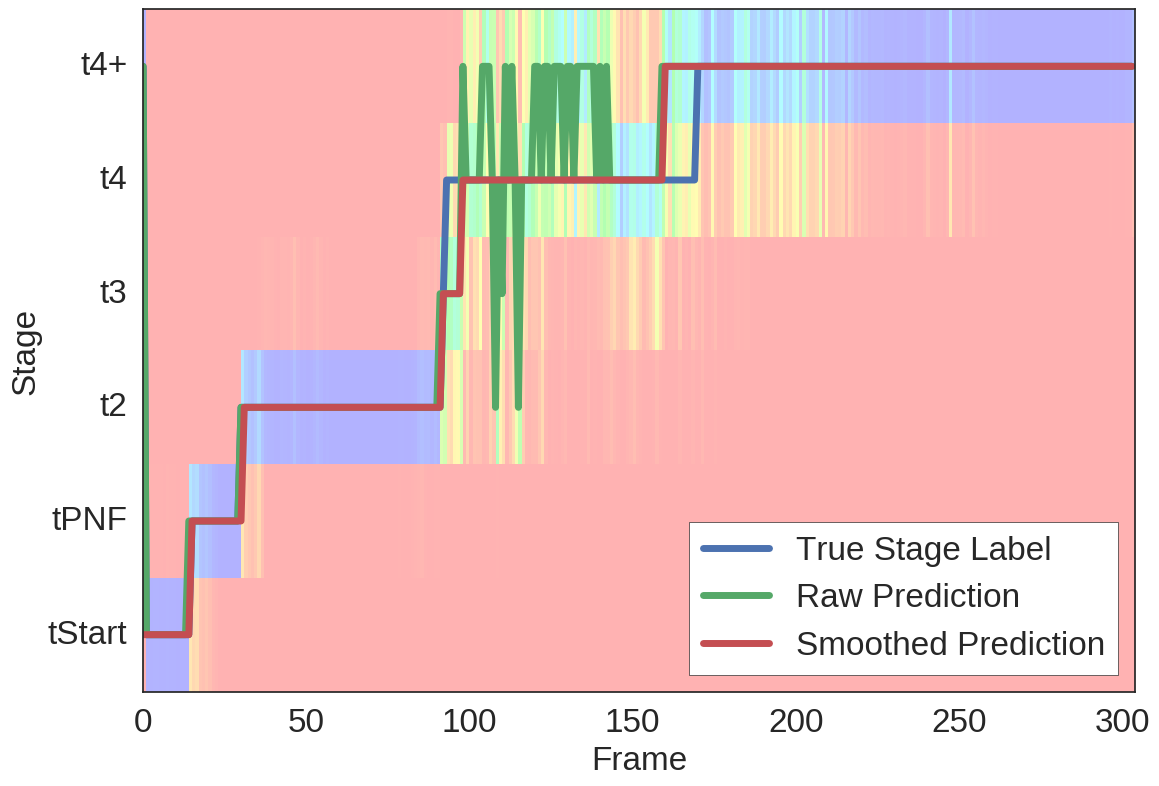

video: 17
4900 to 5204


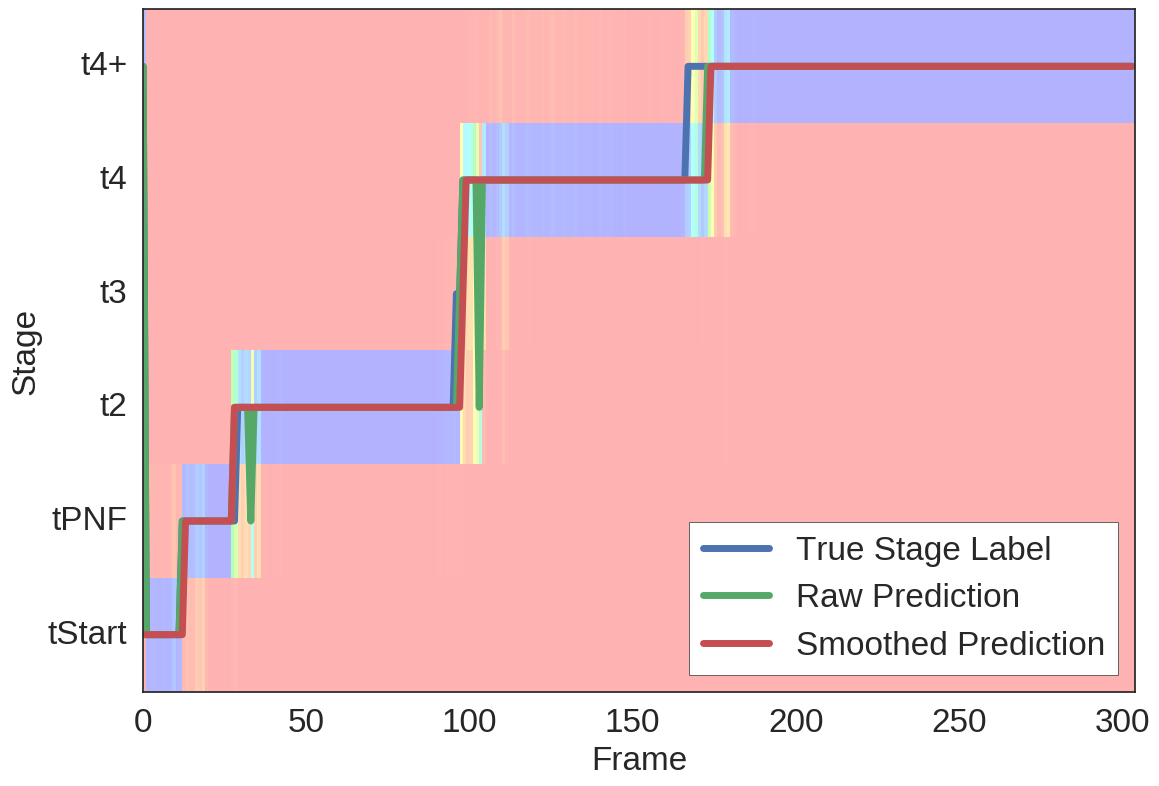

video: 18
5204 to 5508


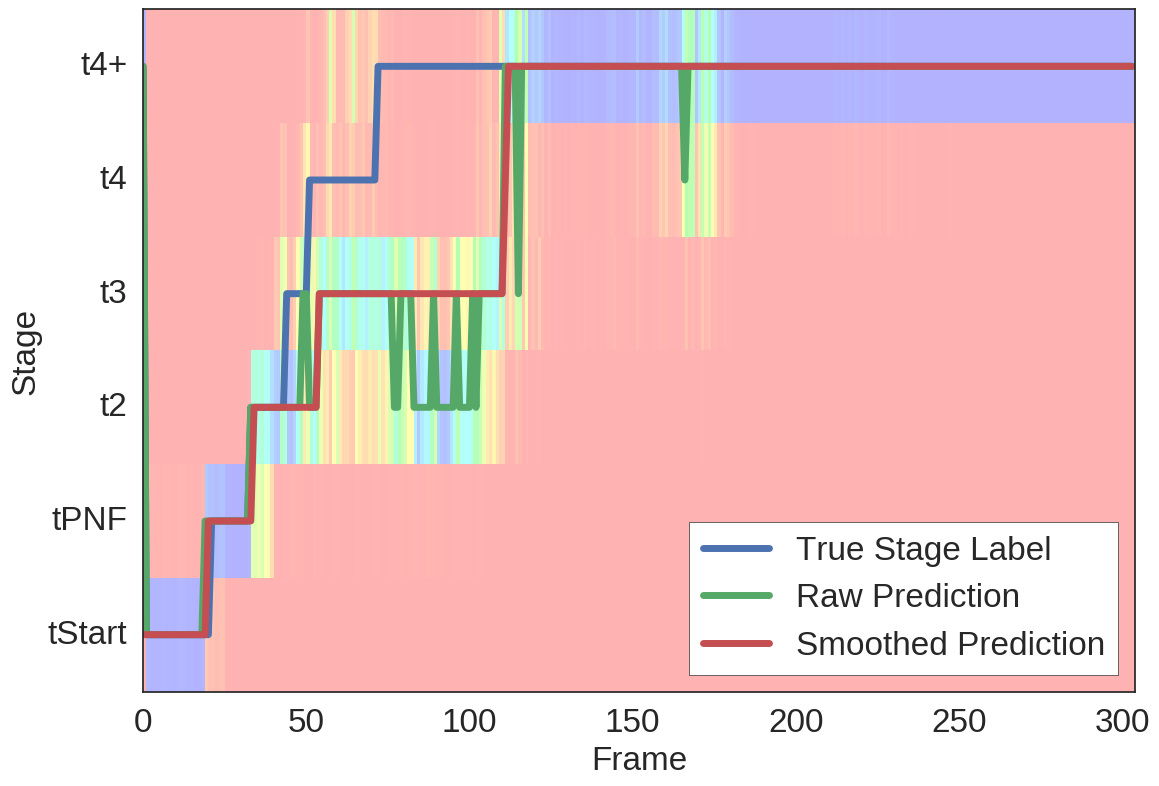

video: 19
5508 to 5812


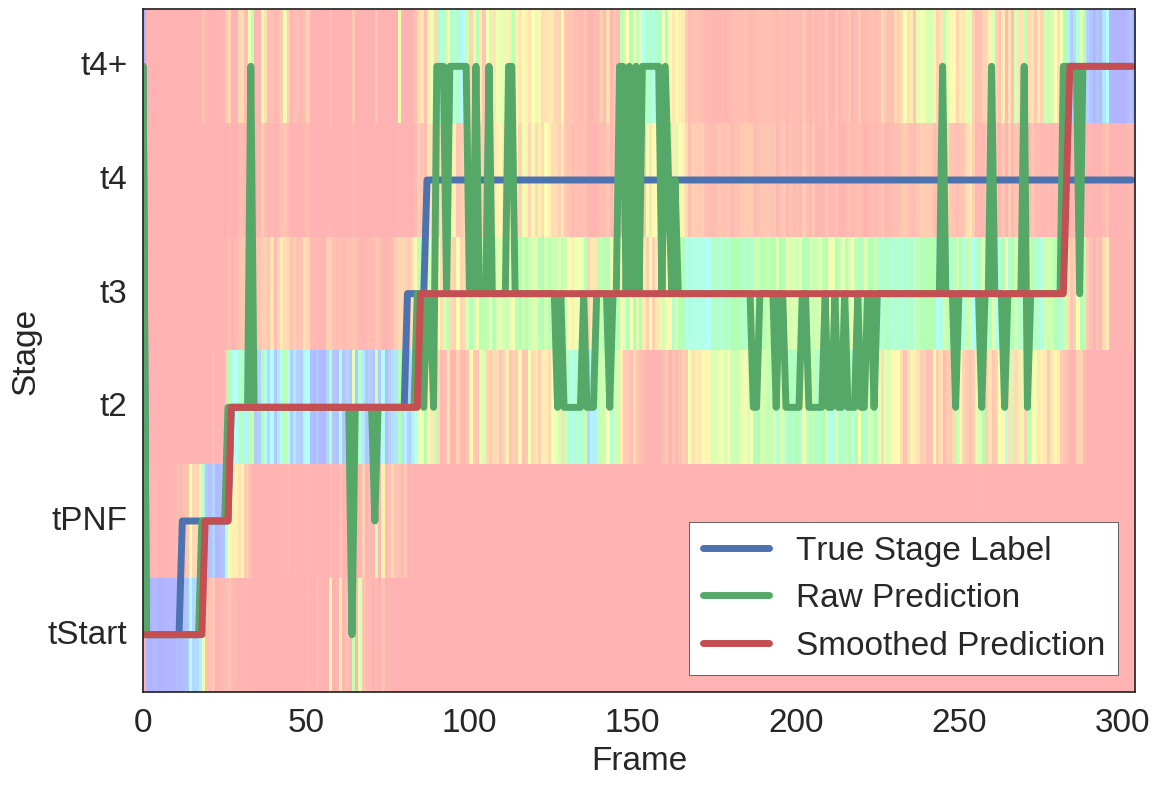

video: 20
5812 to 6126


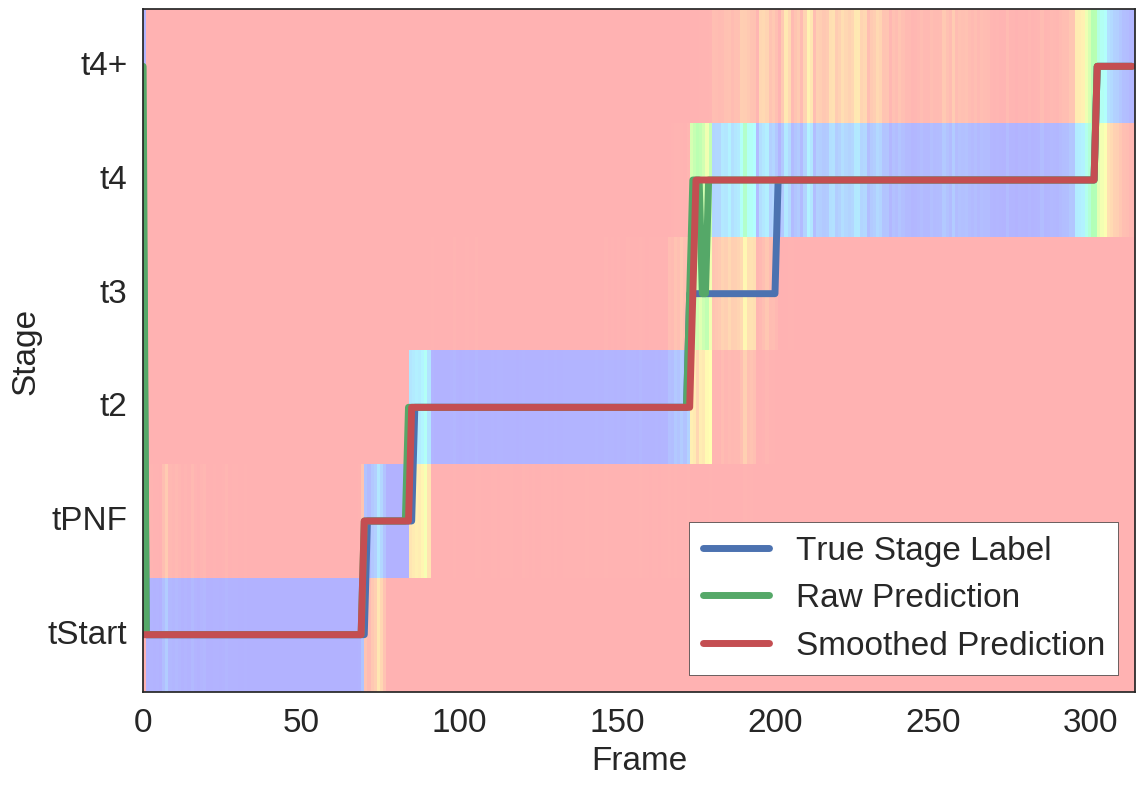

video: 21
6126 to 6440


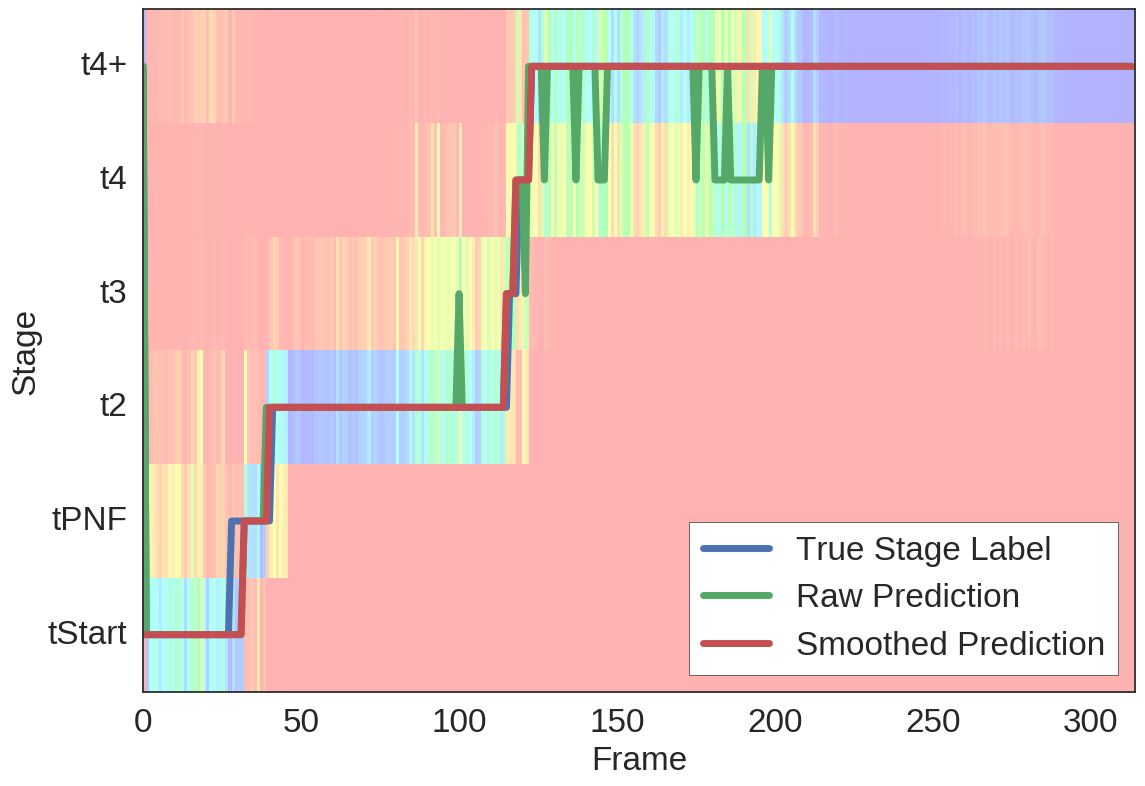

video: 22
6440 to 6754


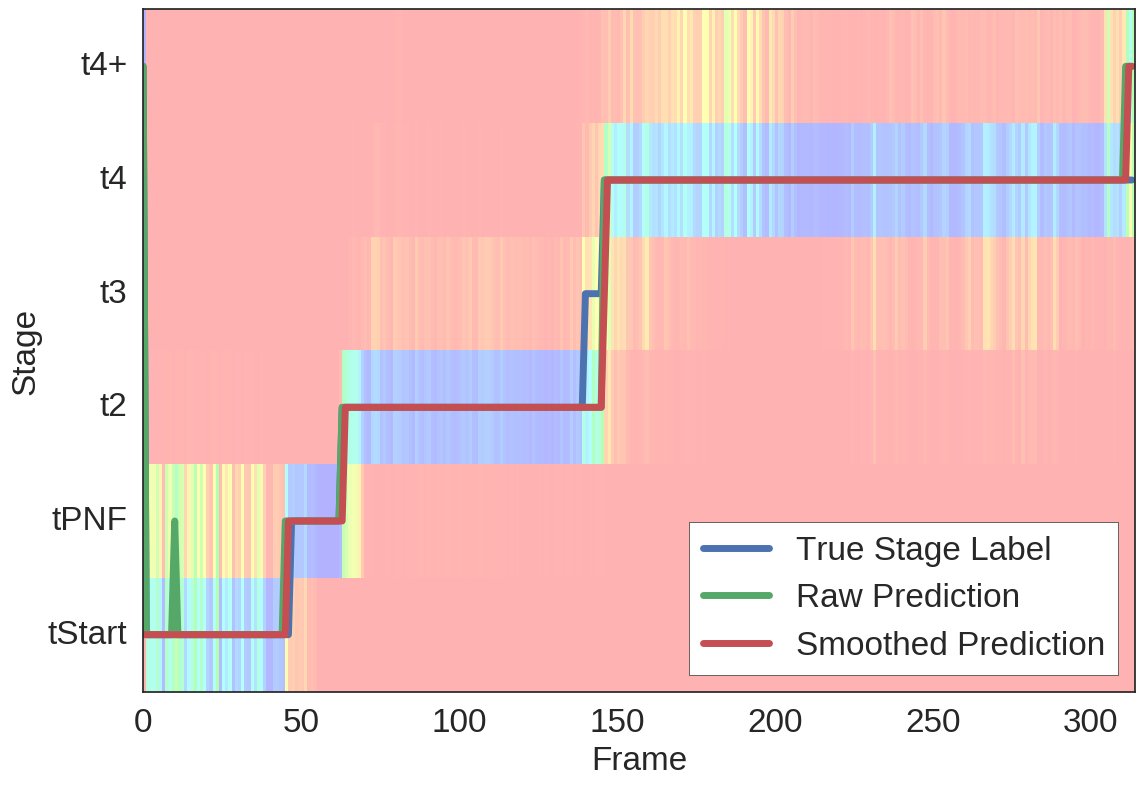

video: 23
6754 to 7068


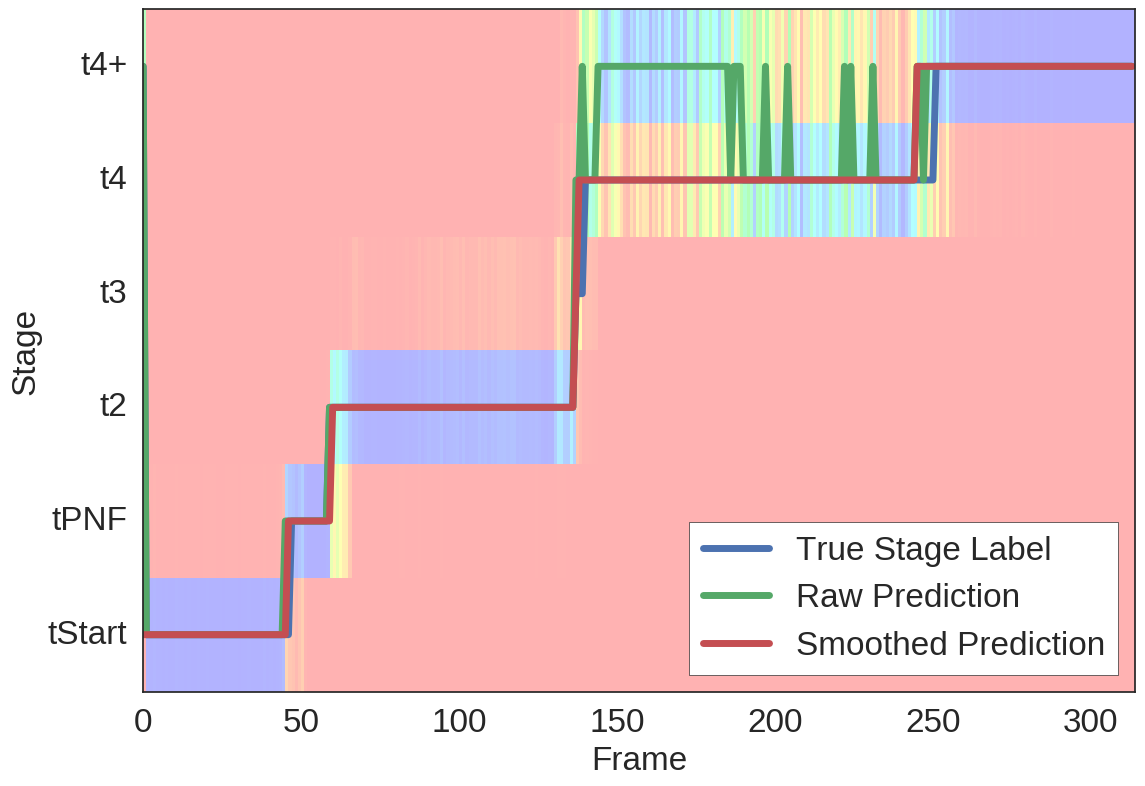

video: 24
7068 to 7382


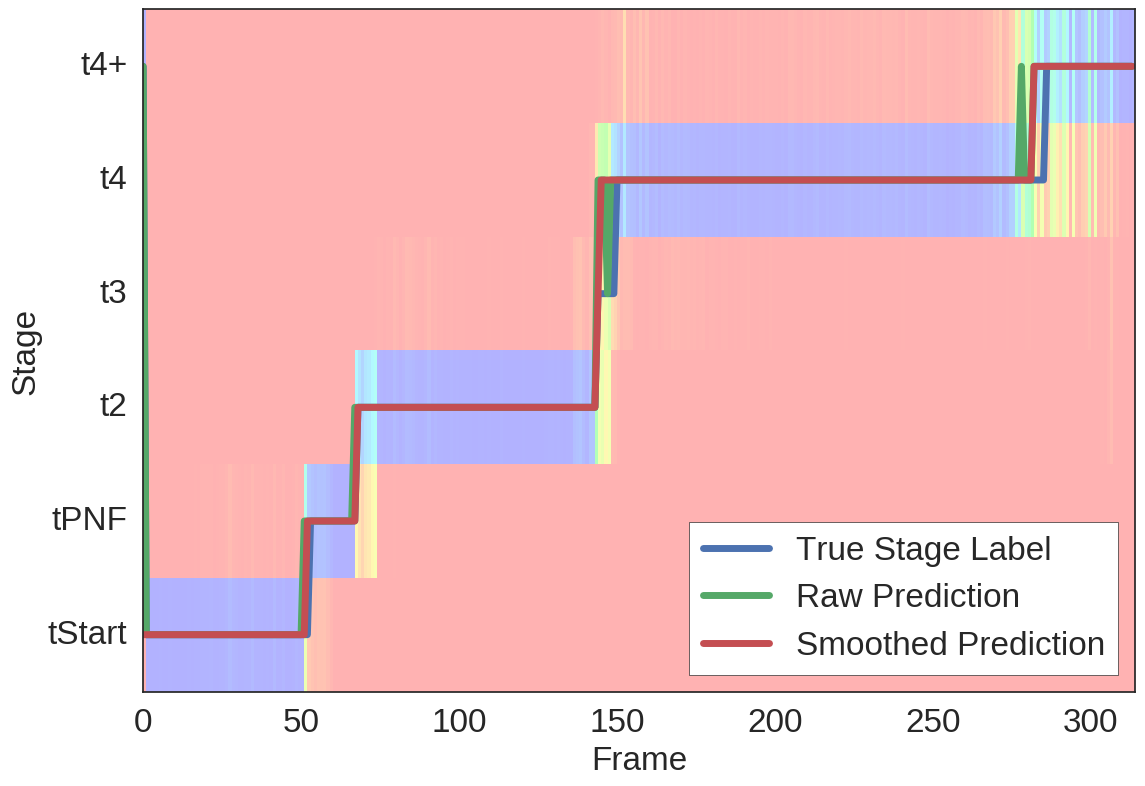

video: 25
7382 to 7688


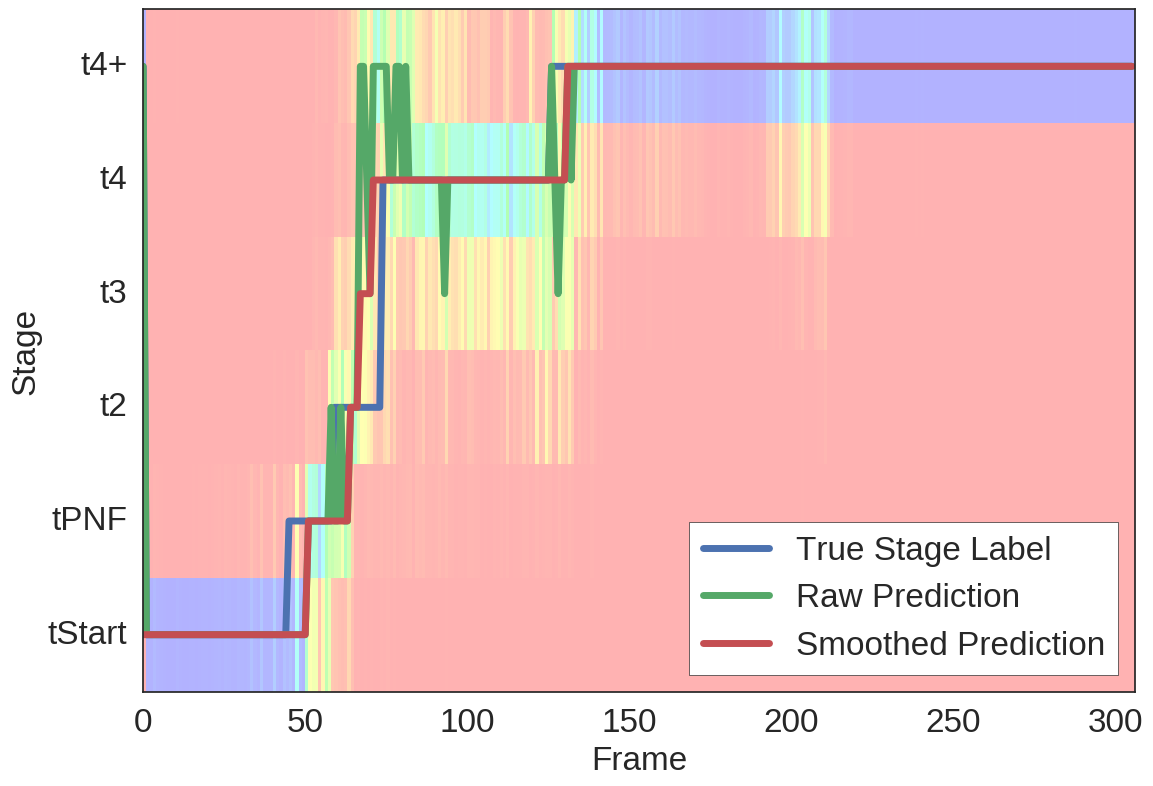

video: 26
7688 to 7994


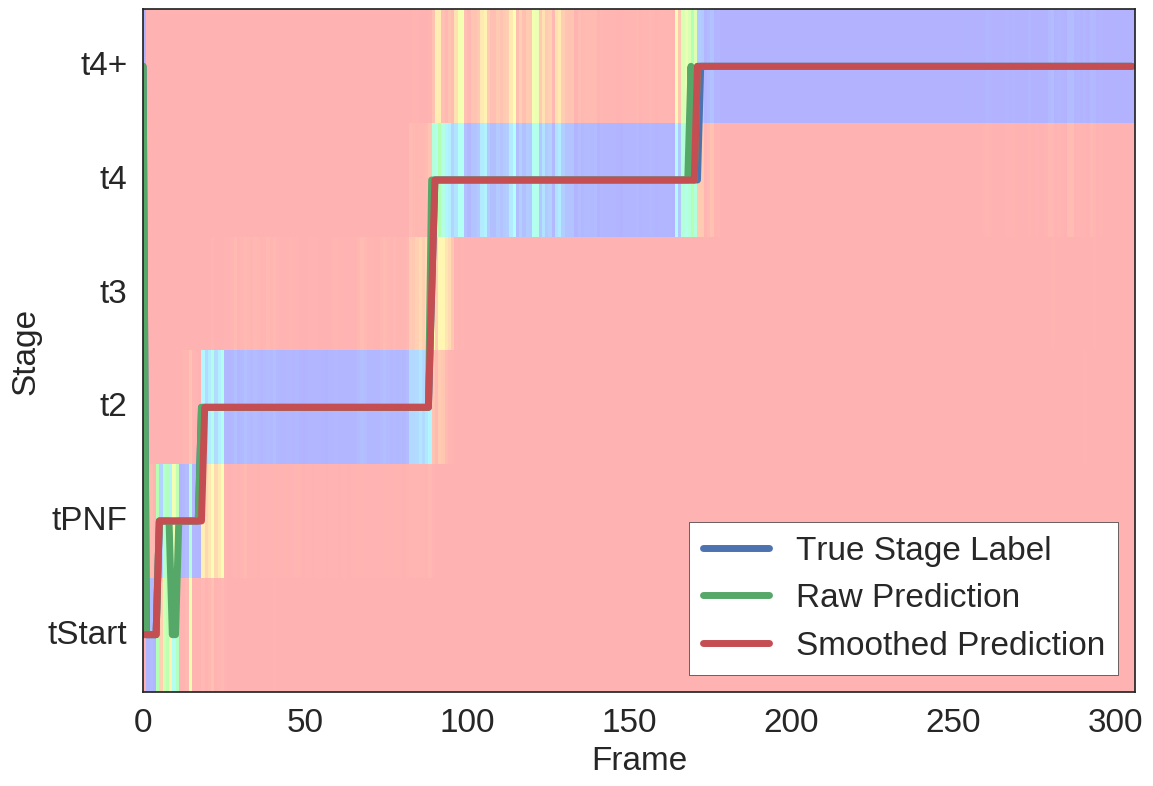

video: 27
7994 to 8300


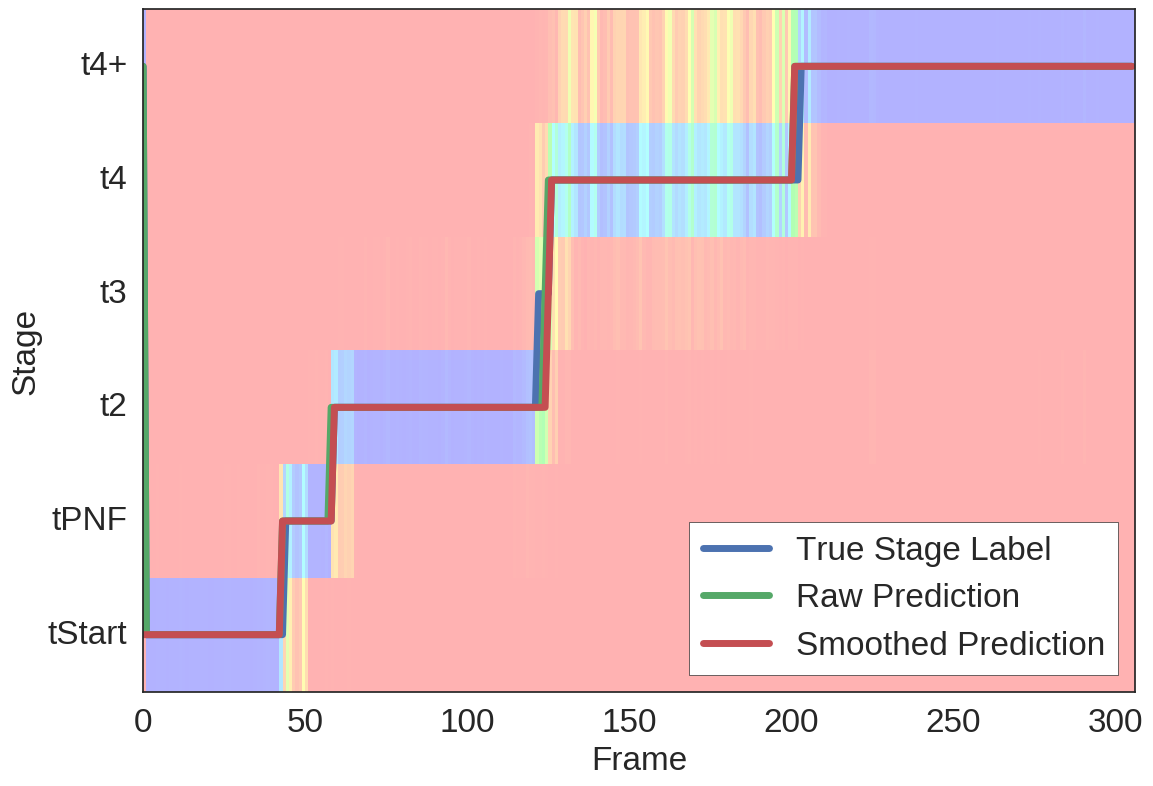

video: 28
8300 to 8606


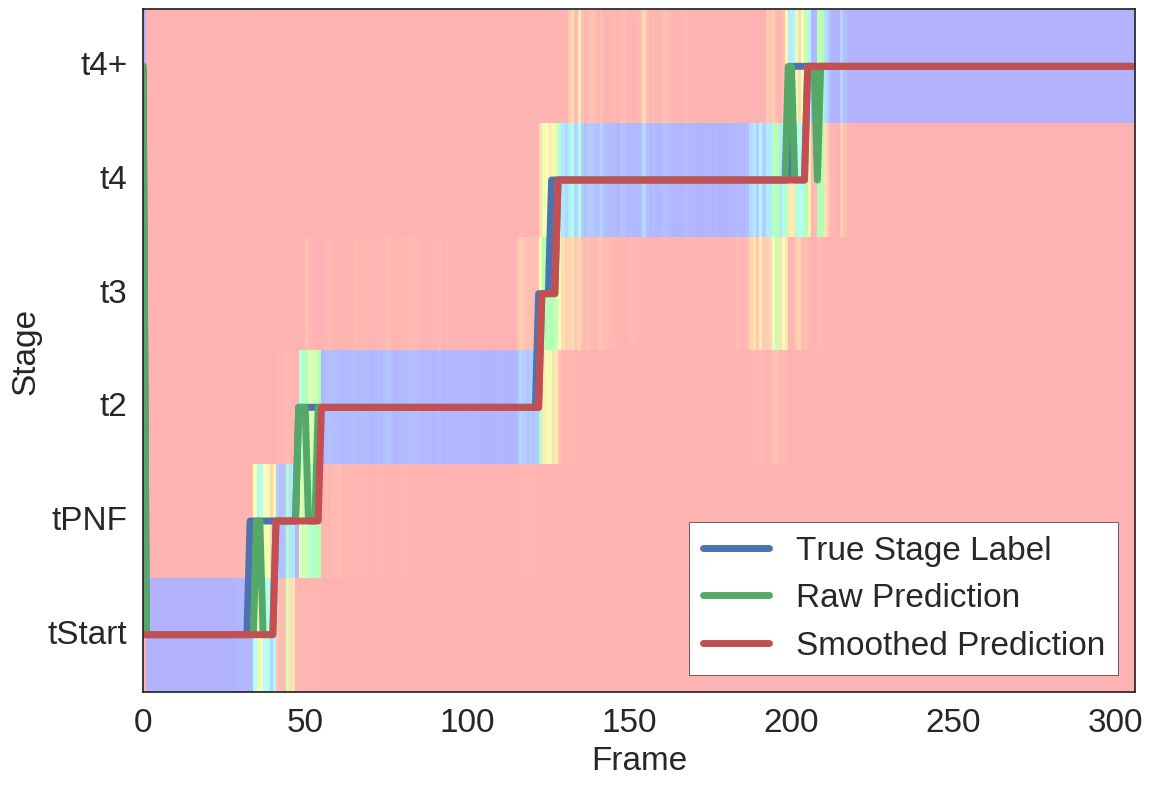

video: 29
8606 to 8912


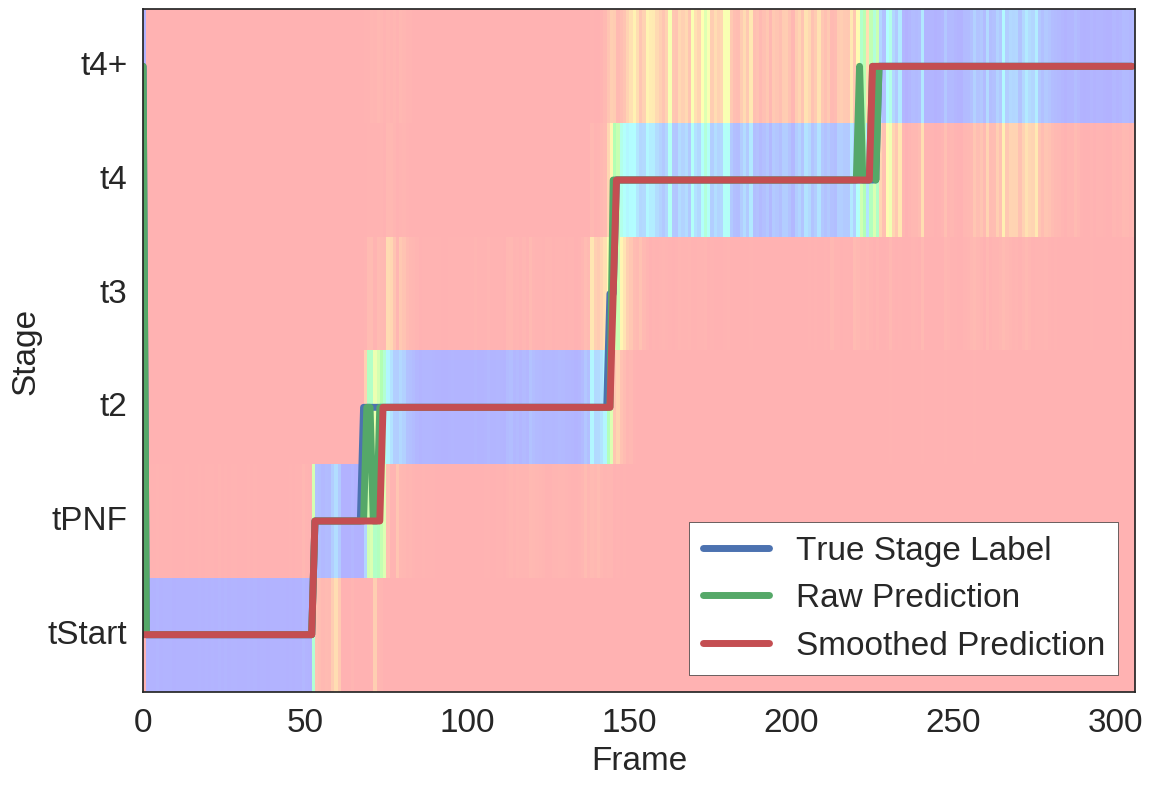

video: 30
8912 to 9218


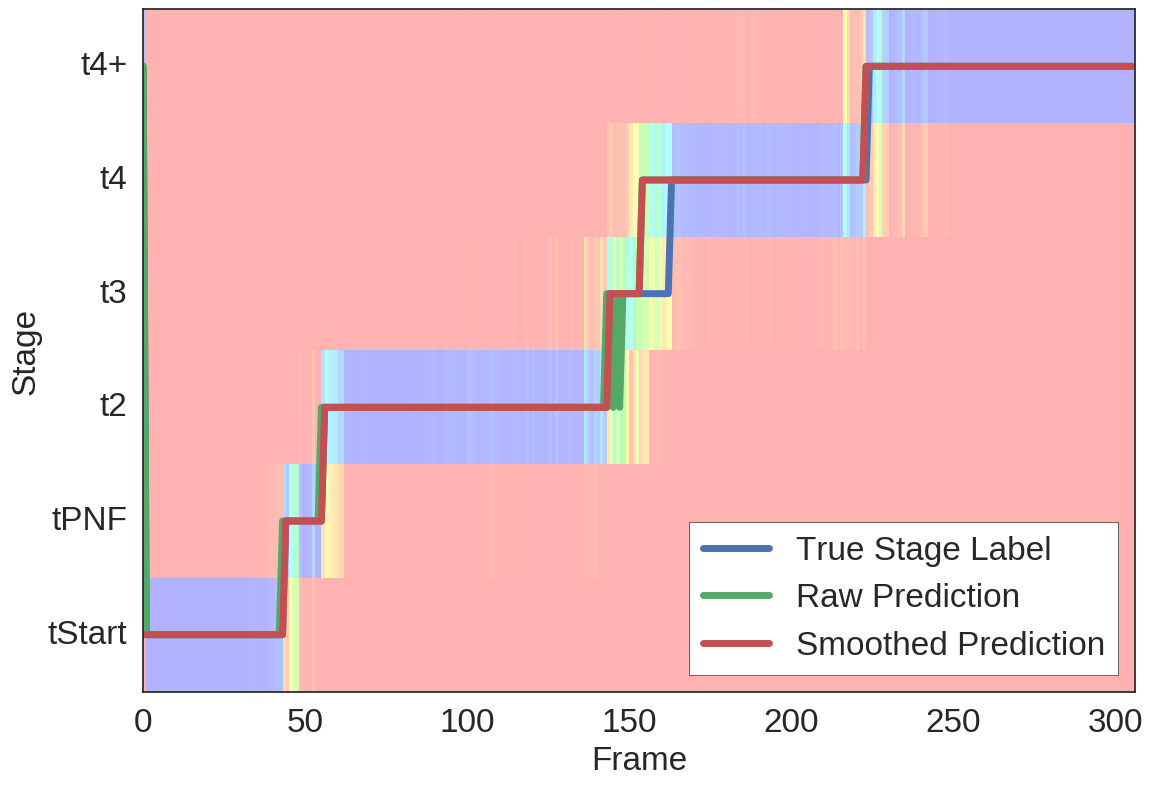

video: 31
9218 to 9524


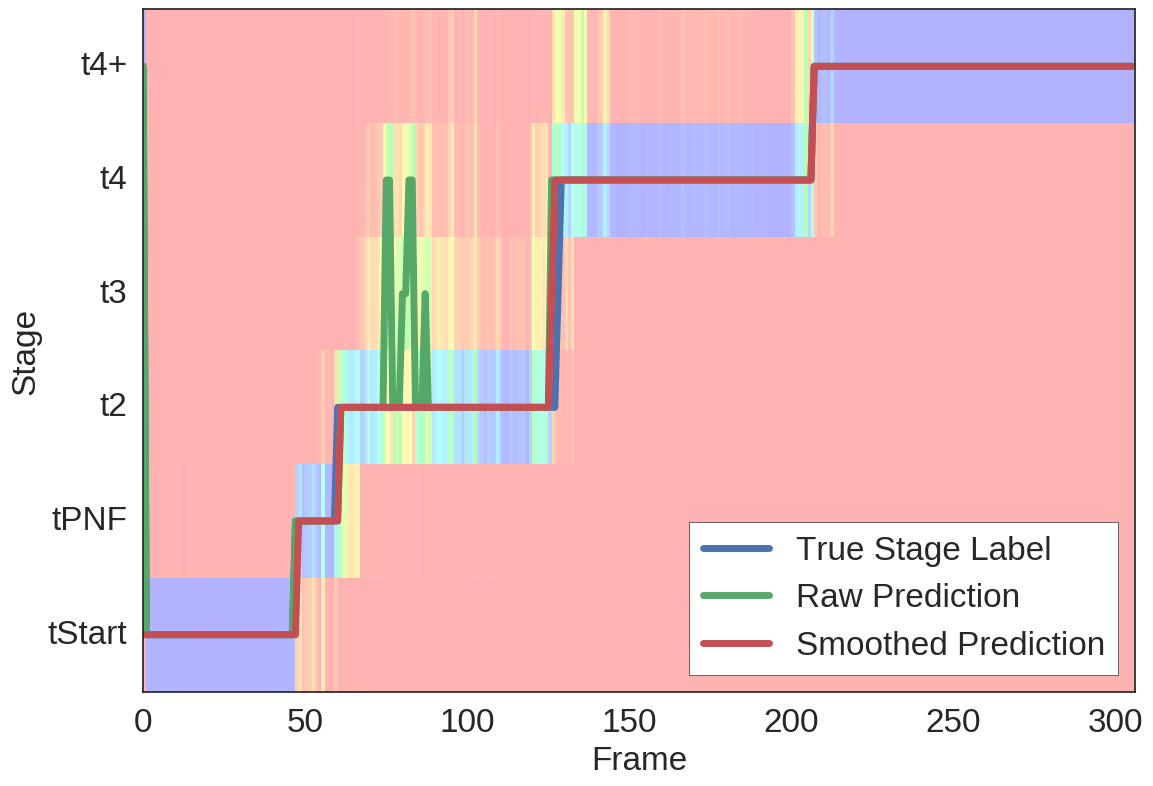

video: 32
9524 to 9832


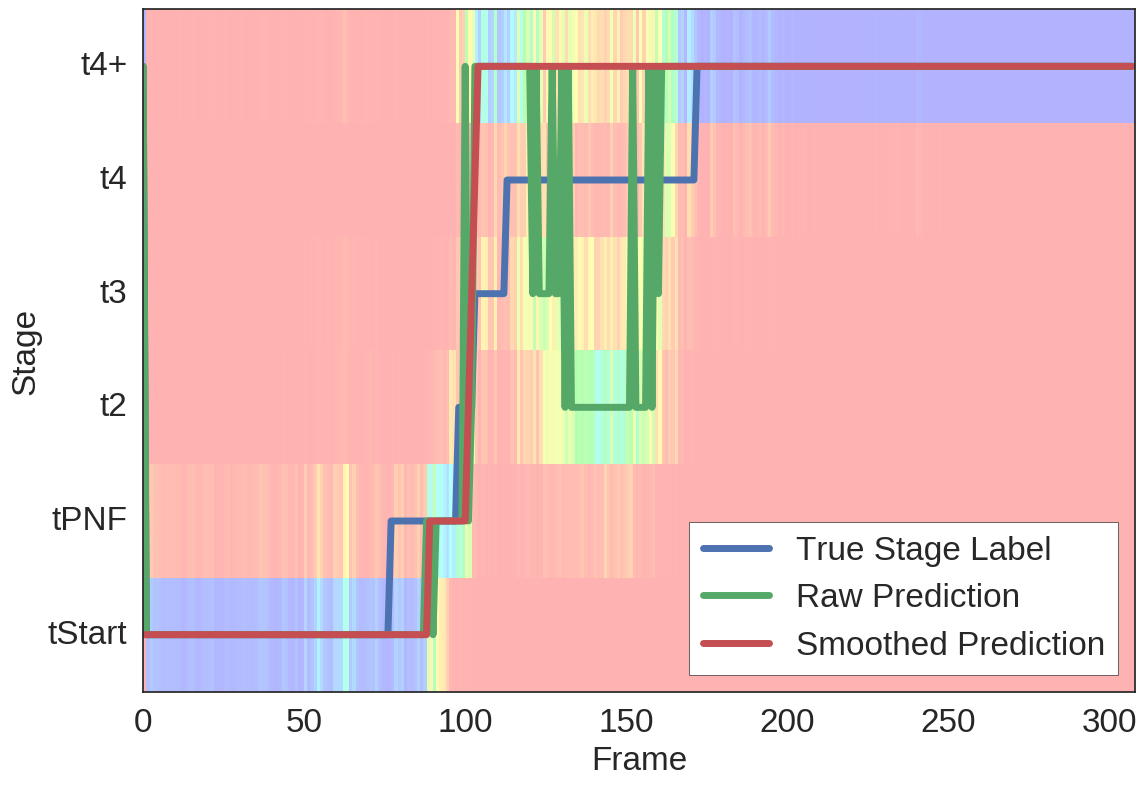

video: 33
9832 to 10140


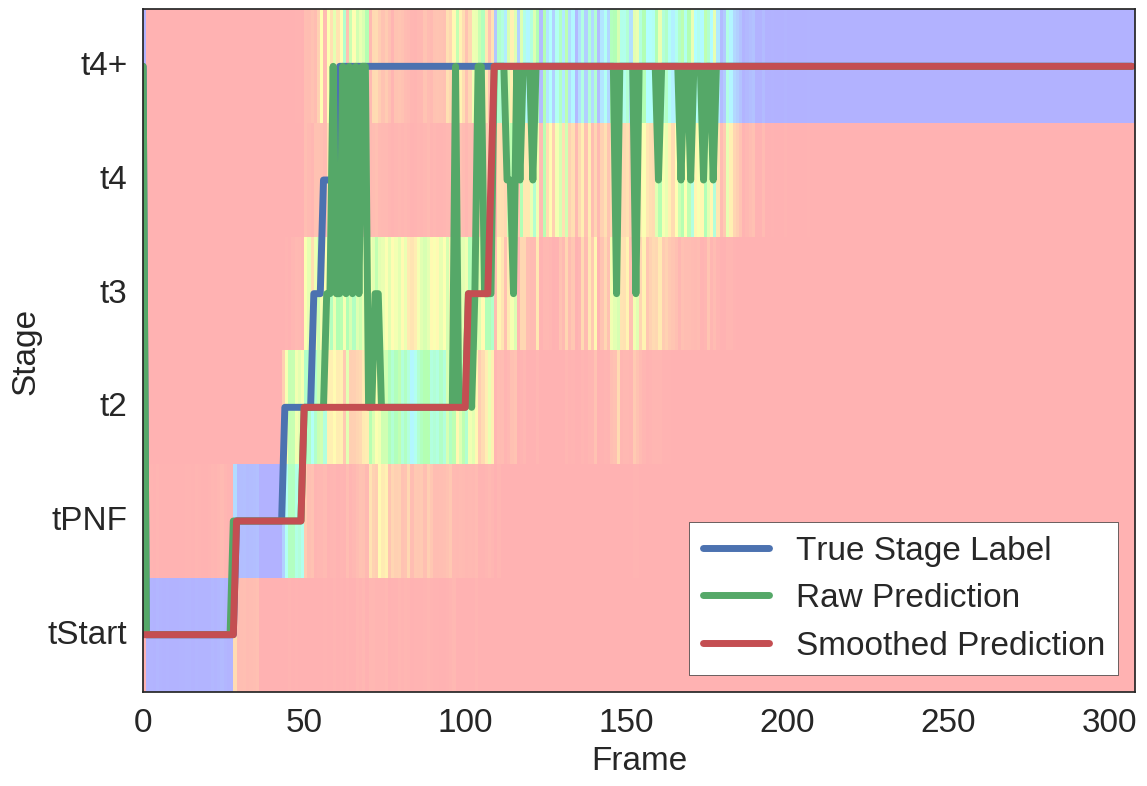

video: 34
10140 to 10448


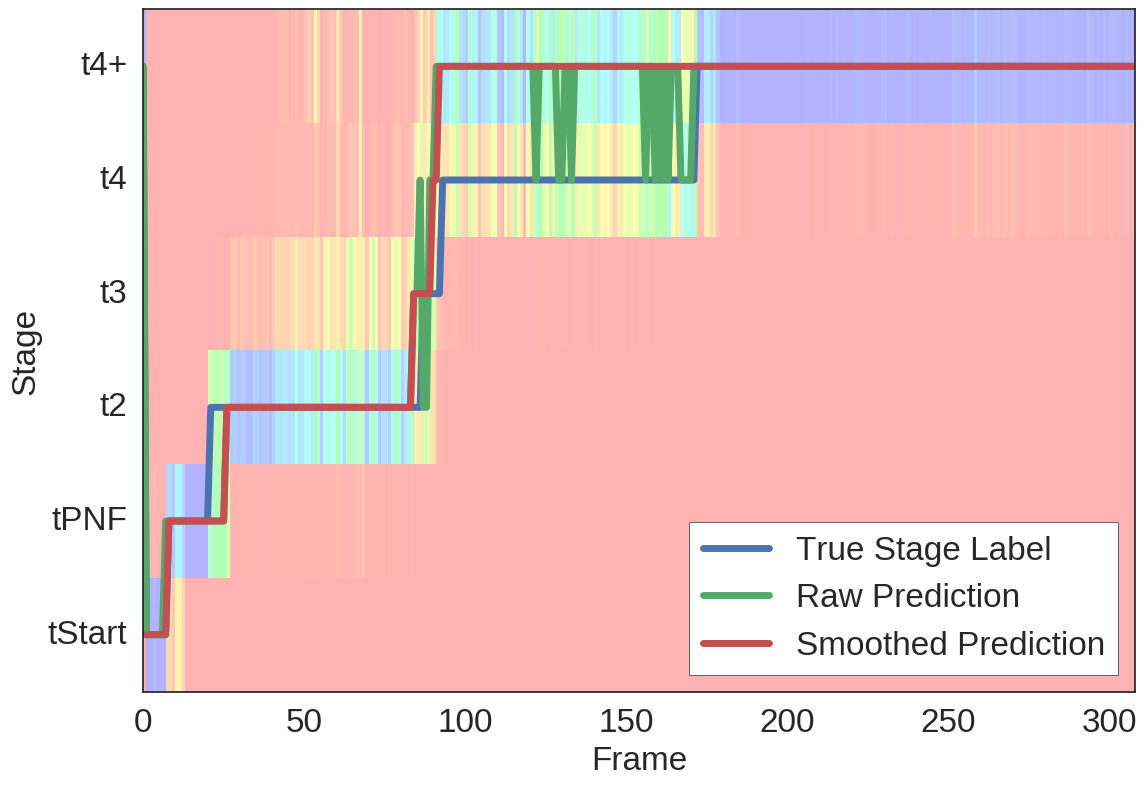

video: 35
10448 to 10756


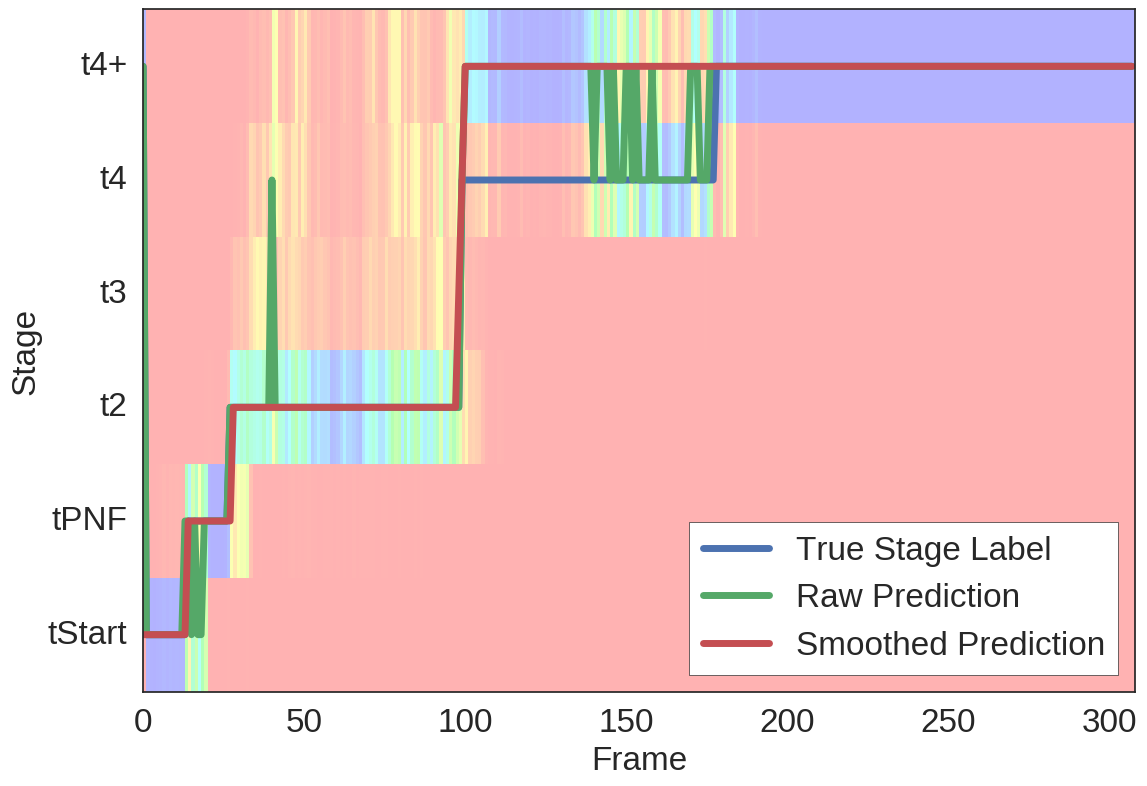

video: 36
10756 to 11064


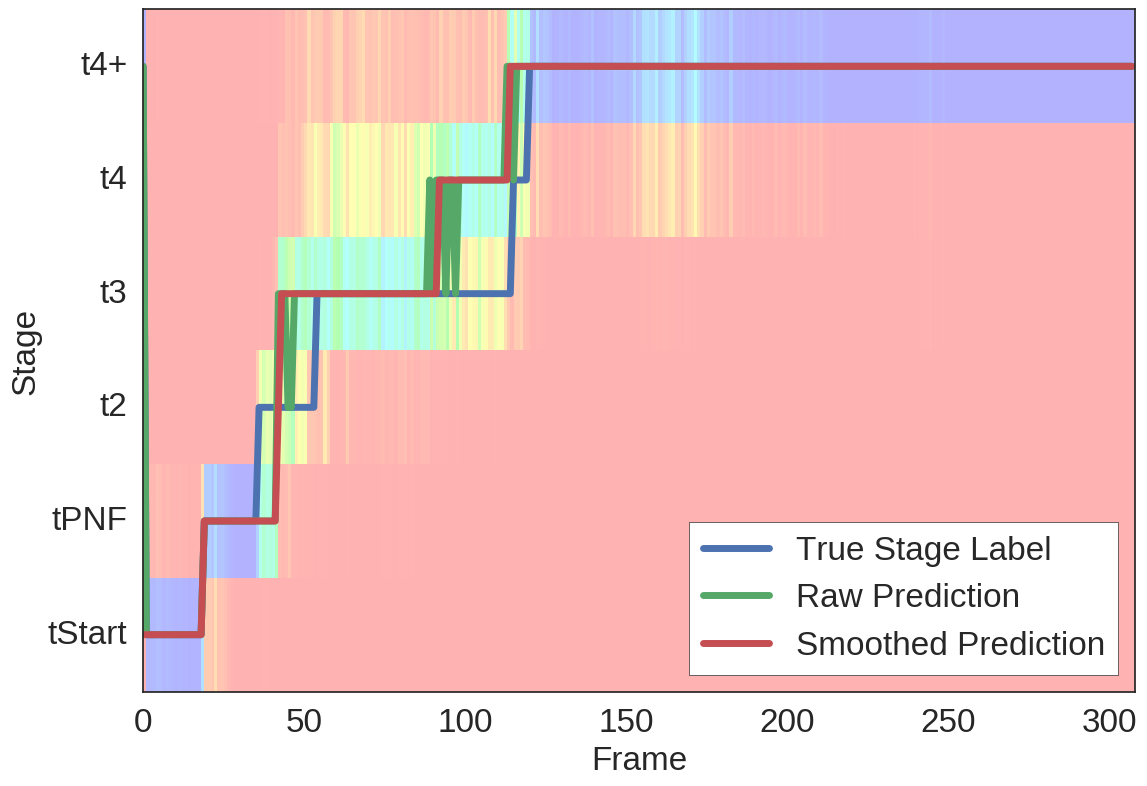

video: 37
11064 to 11372


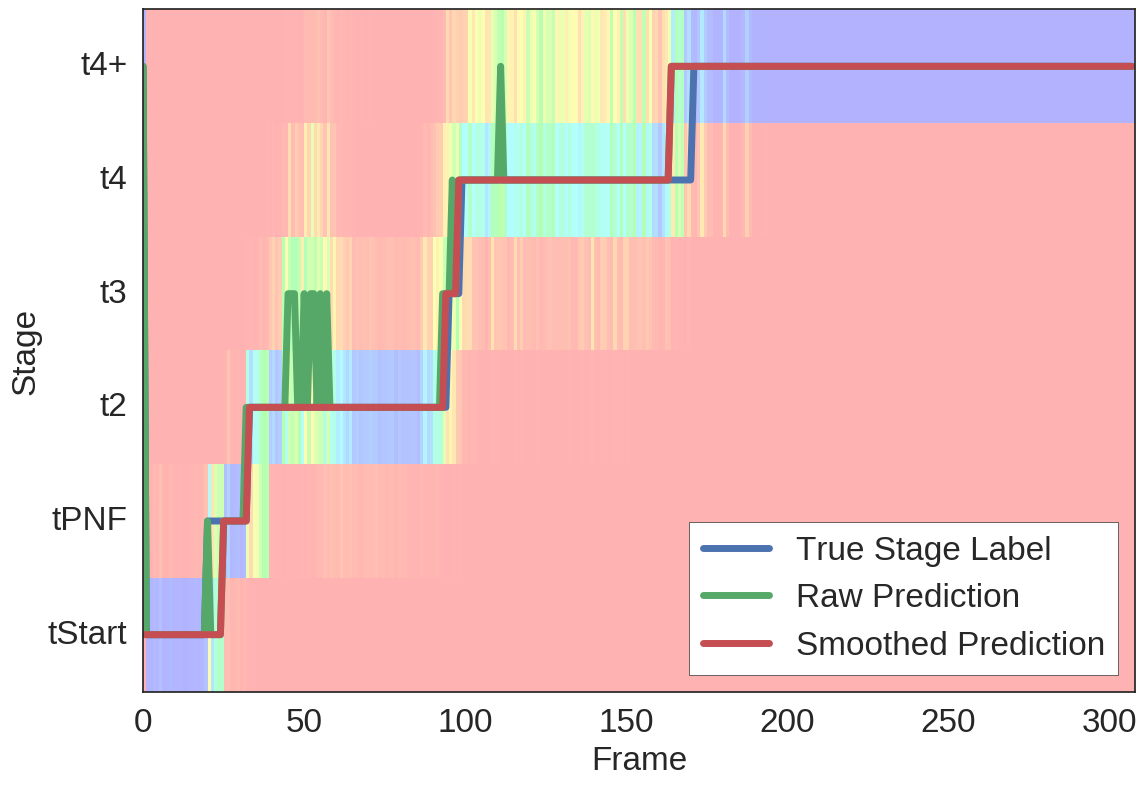

video: 38
11372 to 11680


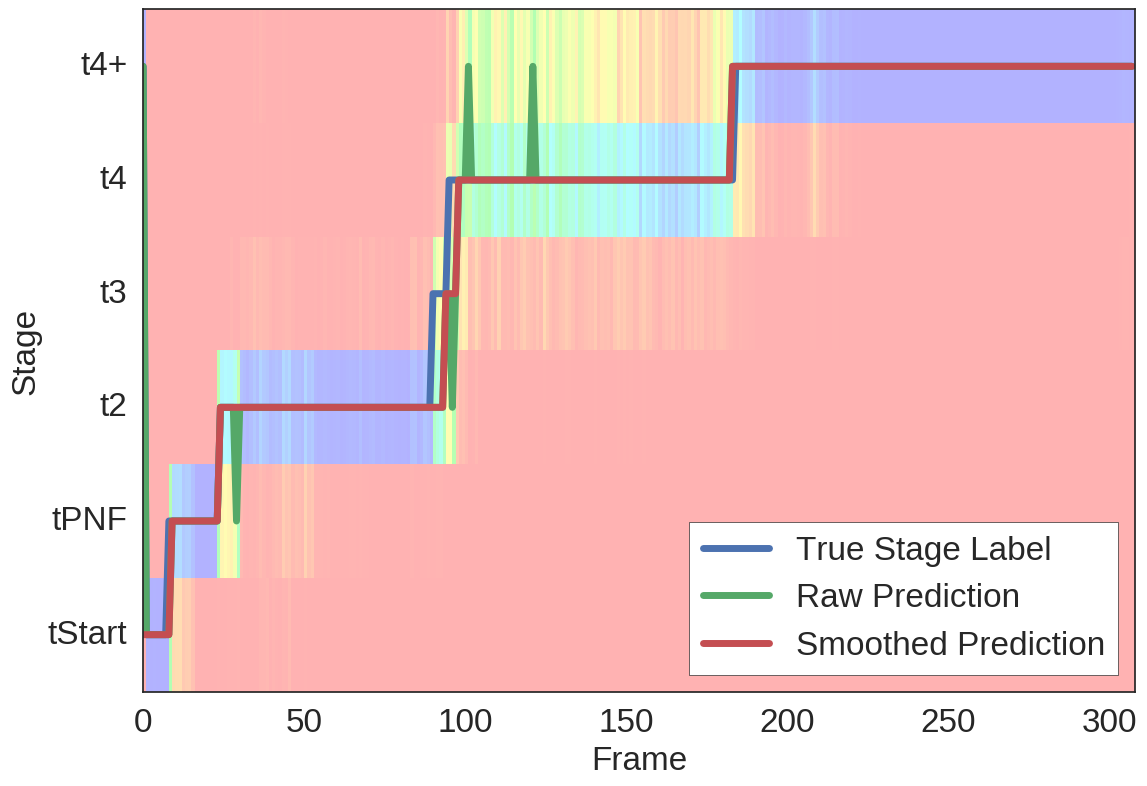

video: 39
11680 to 11988


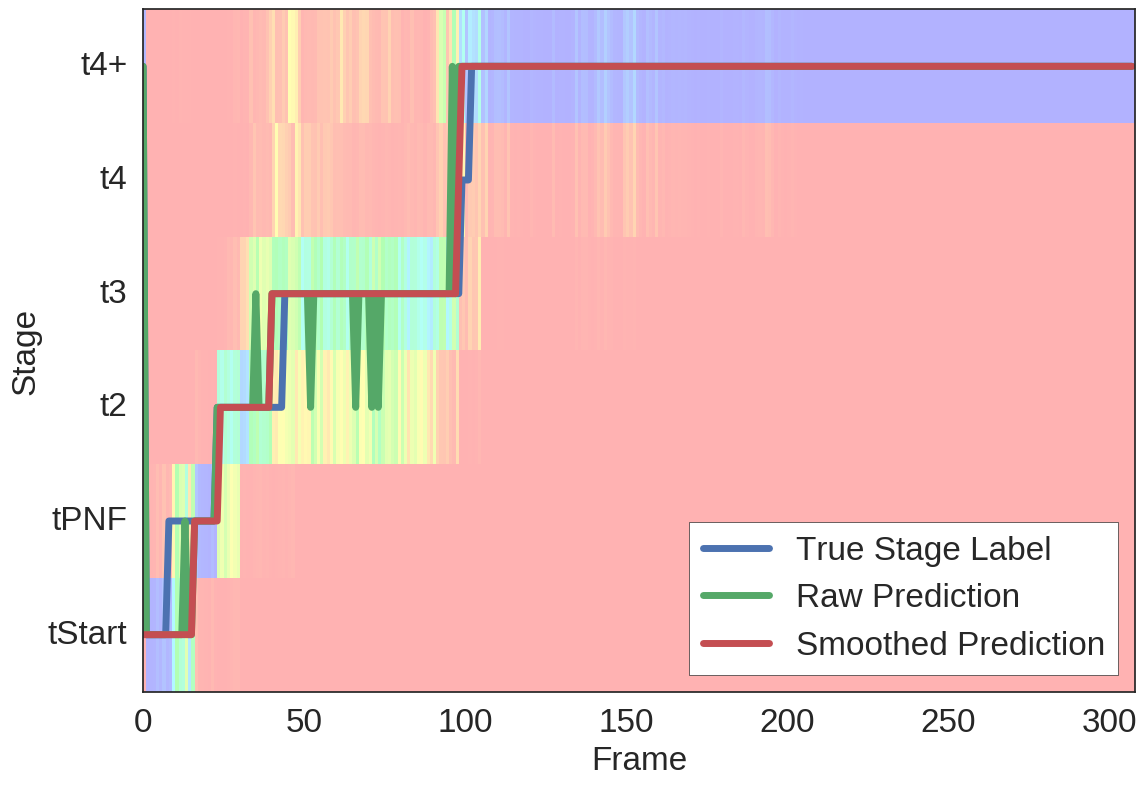

video: 40
11988 to 12296


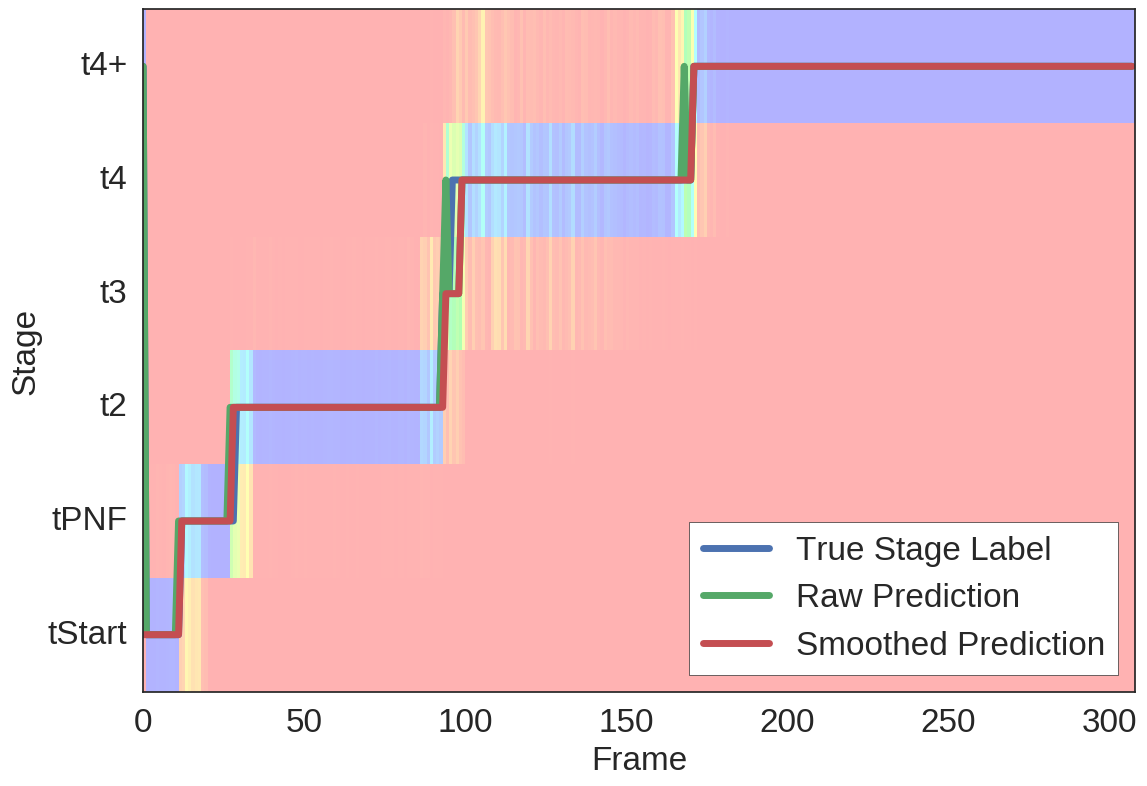

video: 41
12296 to 12604


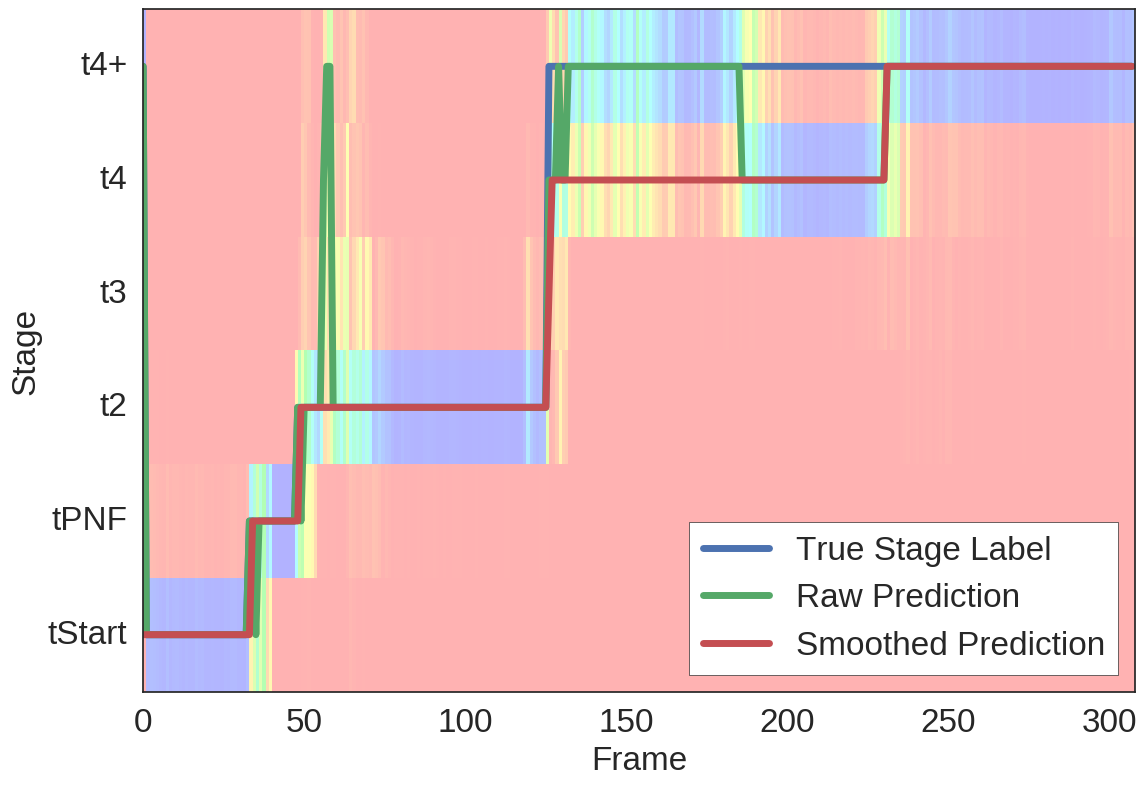

video: 42
12604 to 12912


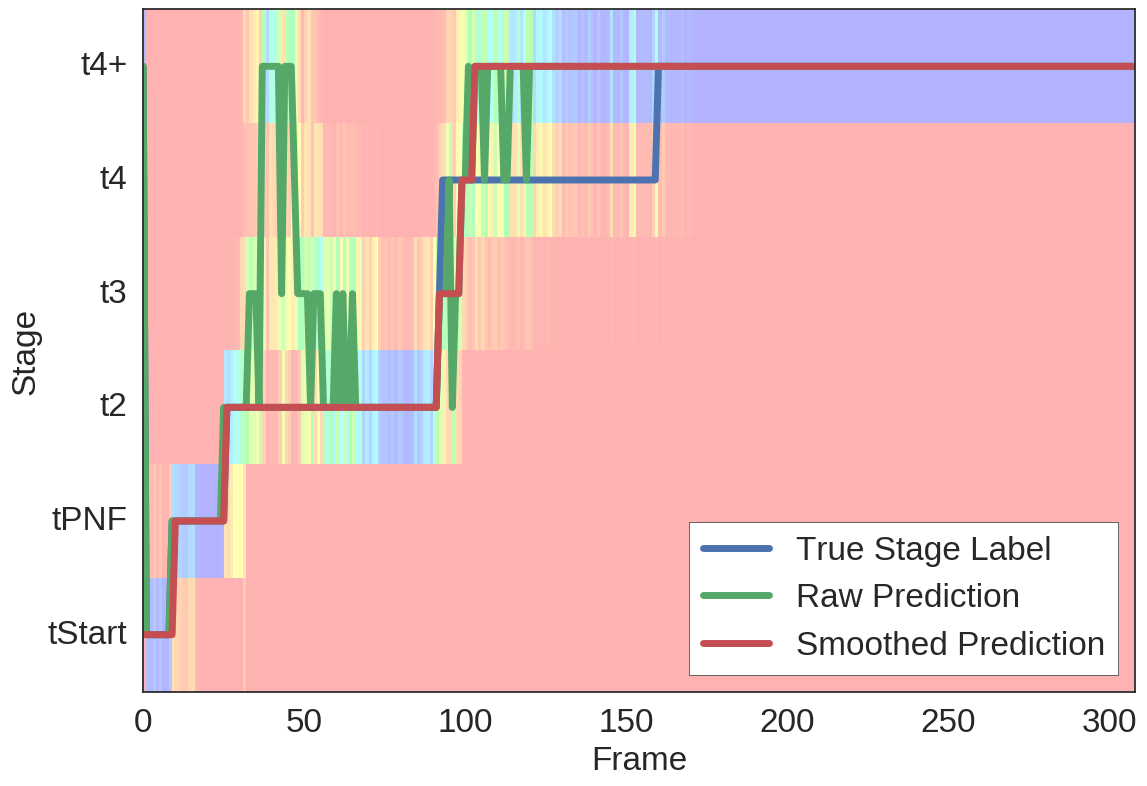

video: 43
12912 to 13220


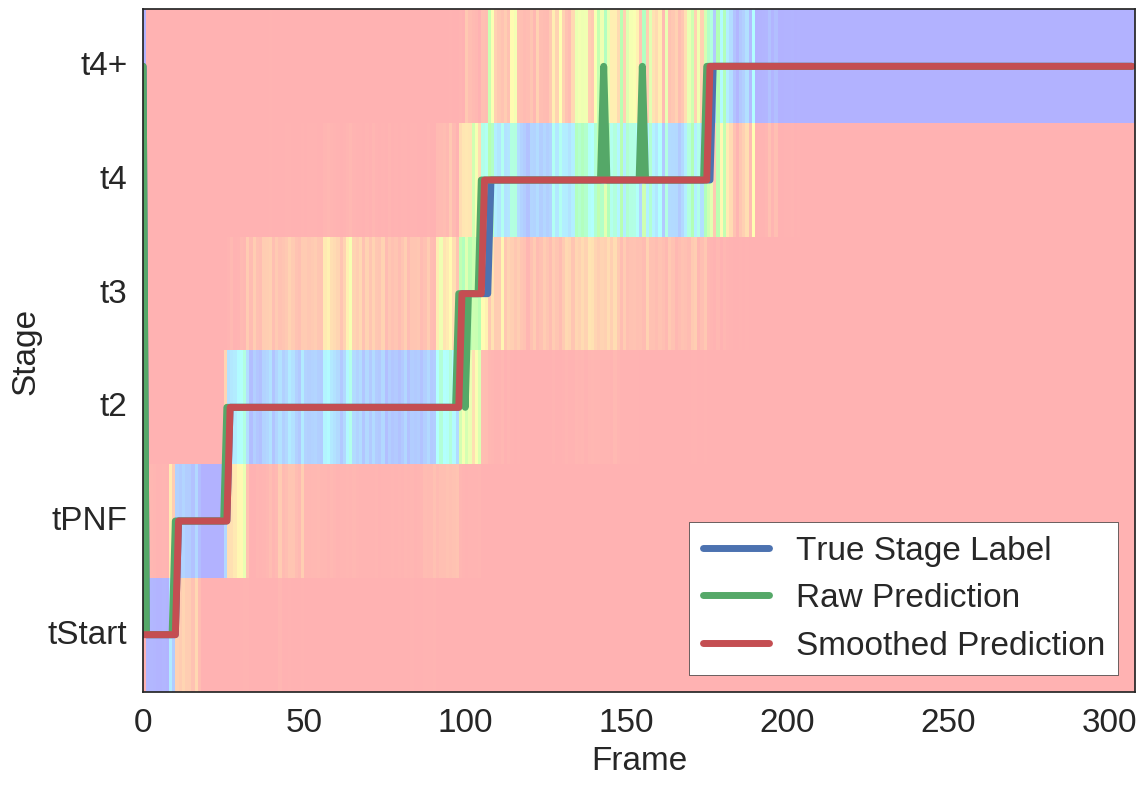

video: 44
13220 to 13528


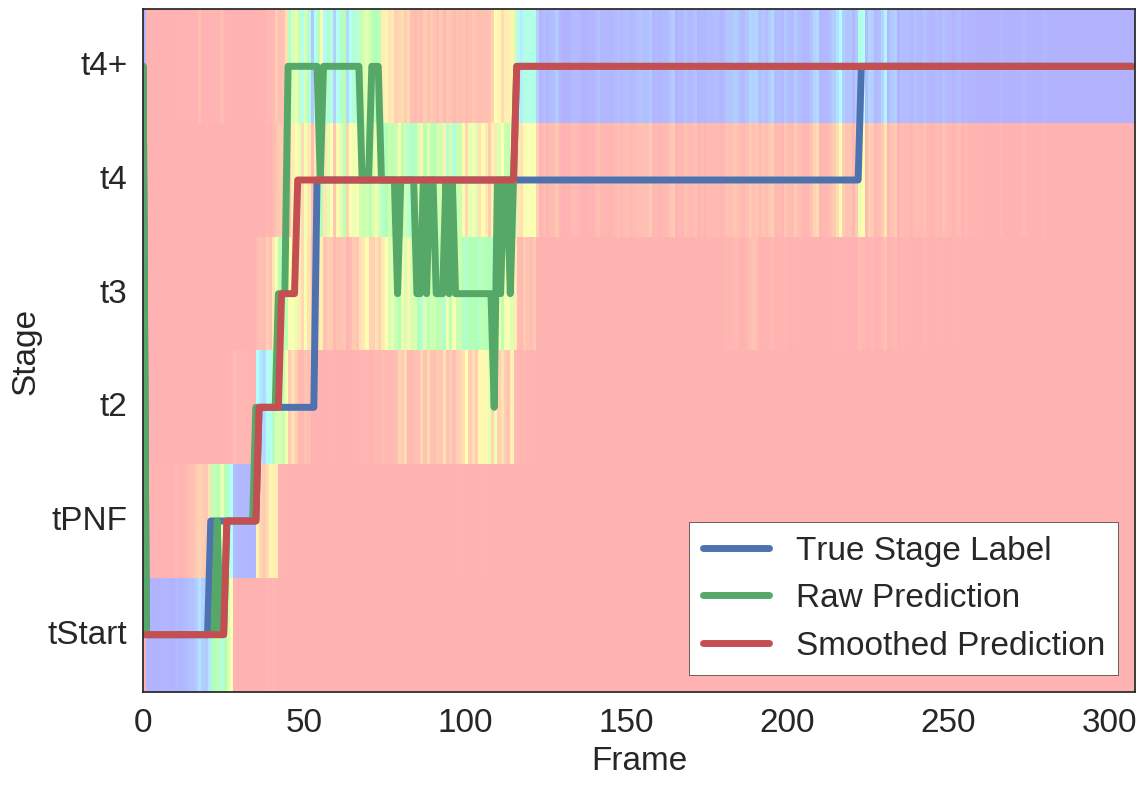

video: 45
13528 to 13836


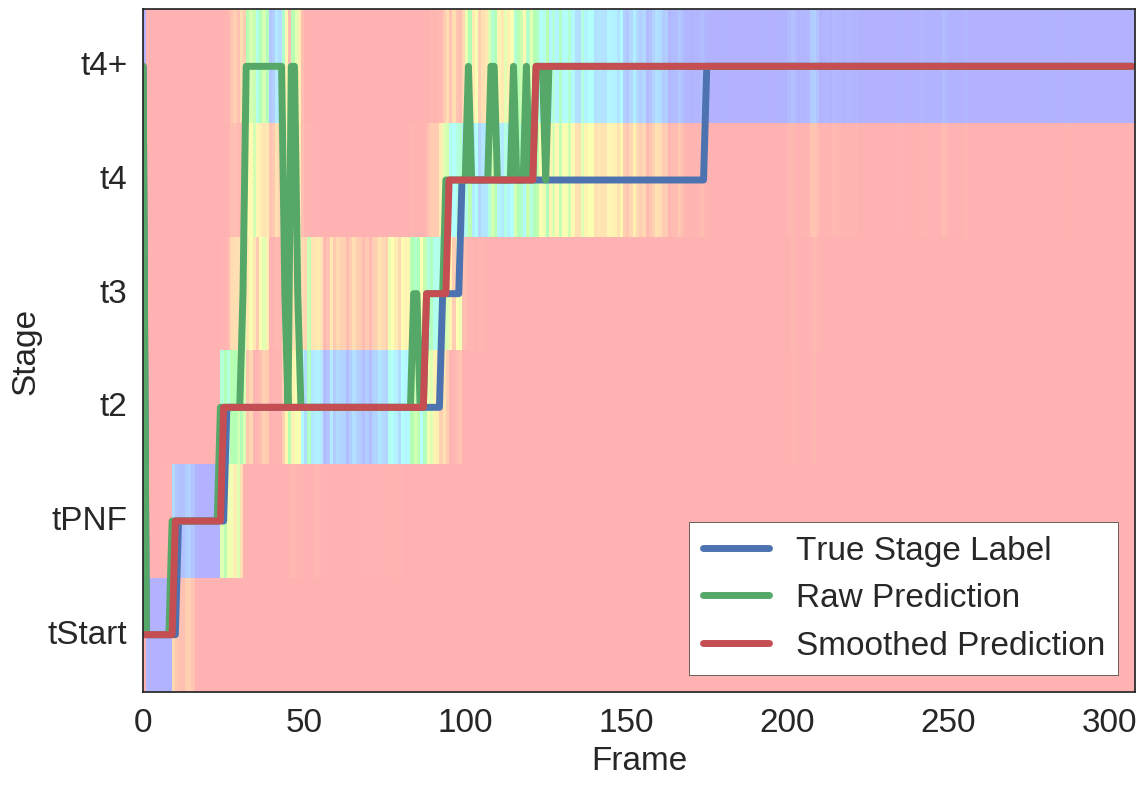

video: 46
13836 to 14139


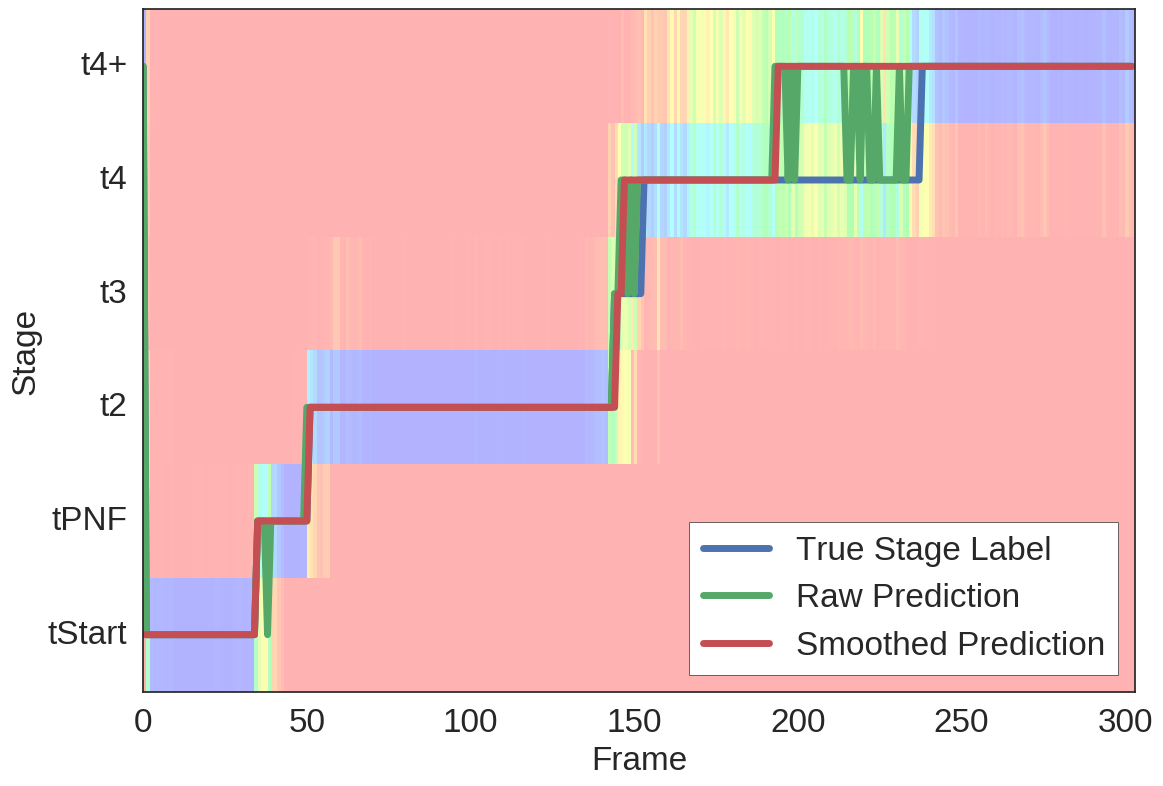

video: 47
14139 to 14442


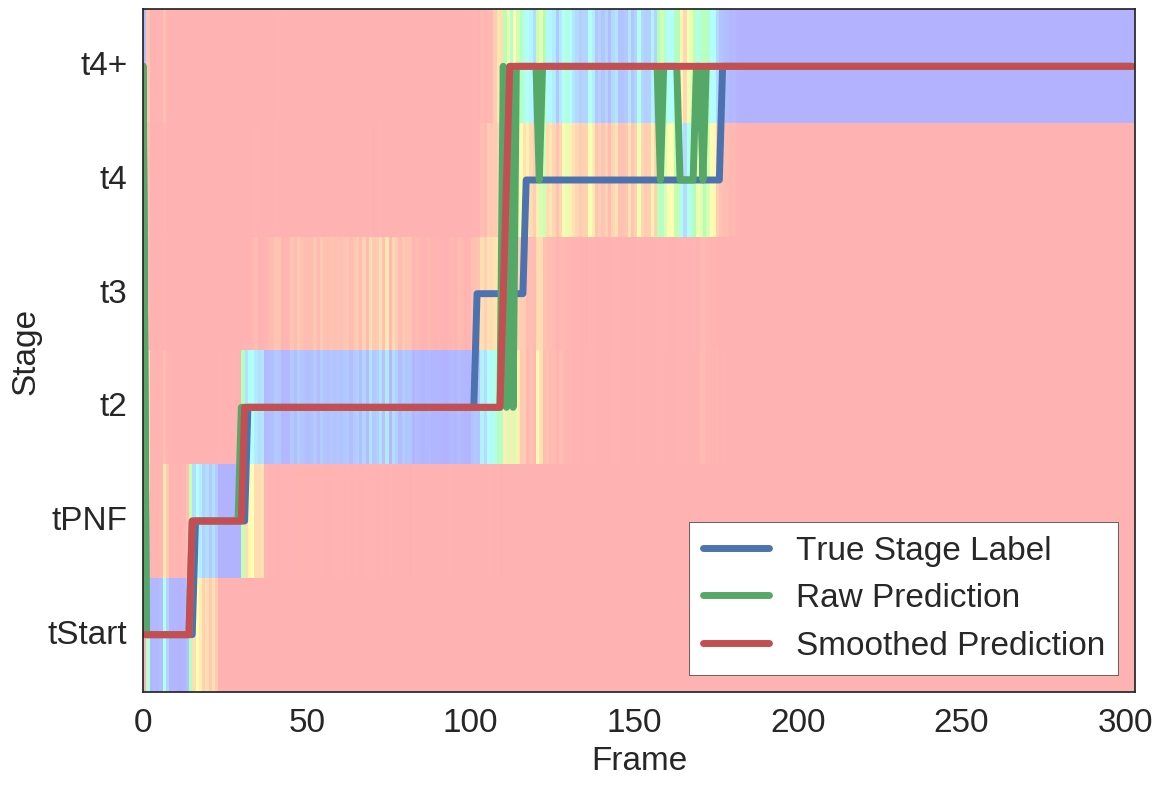

video: 48
14442 to 14745


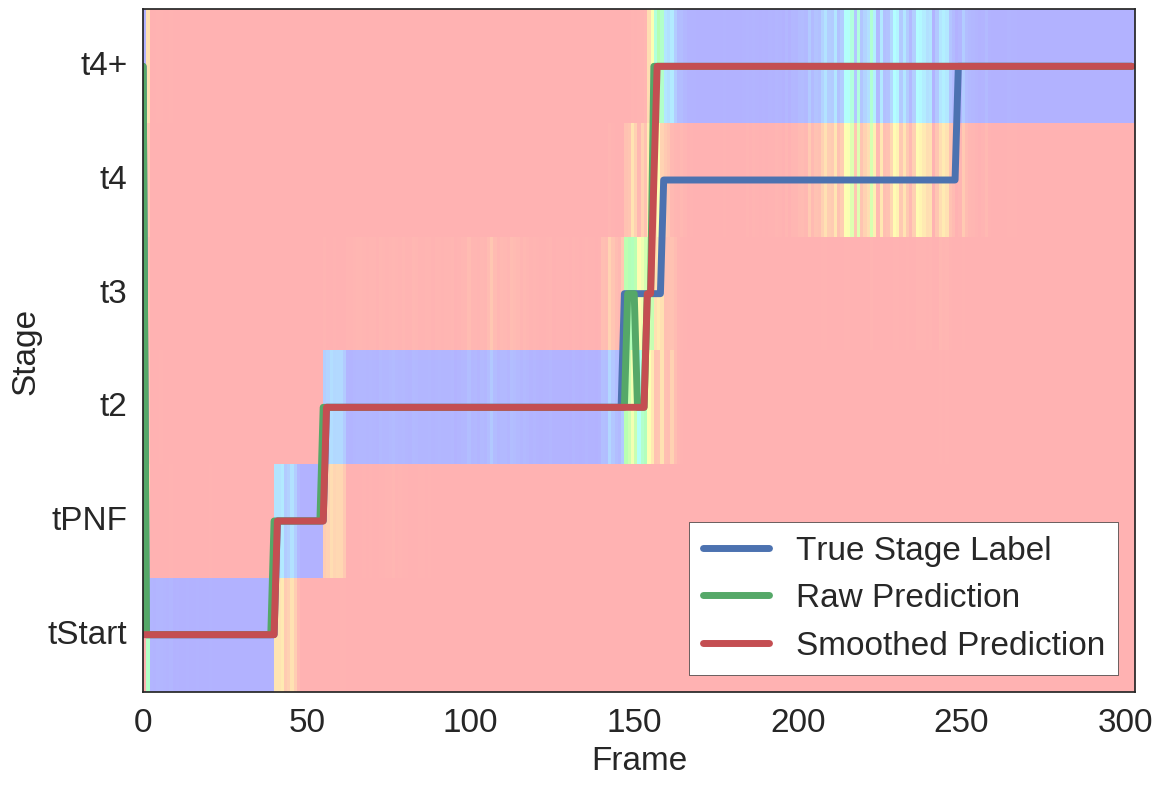

video: 49
14745 to 15048


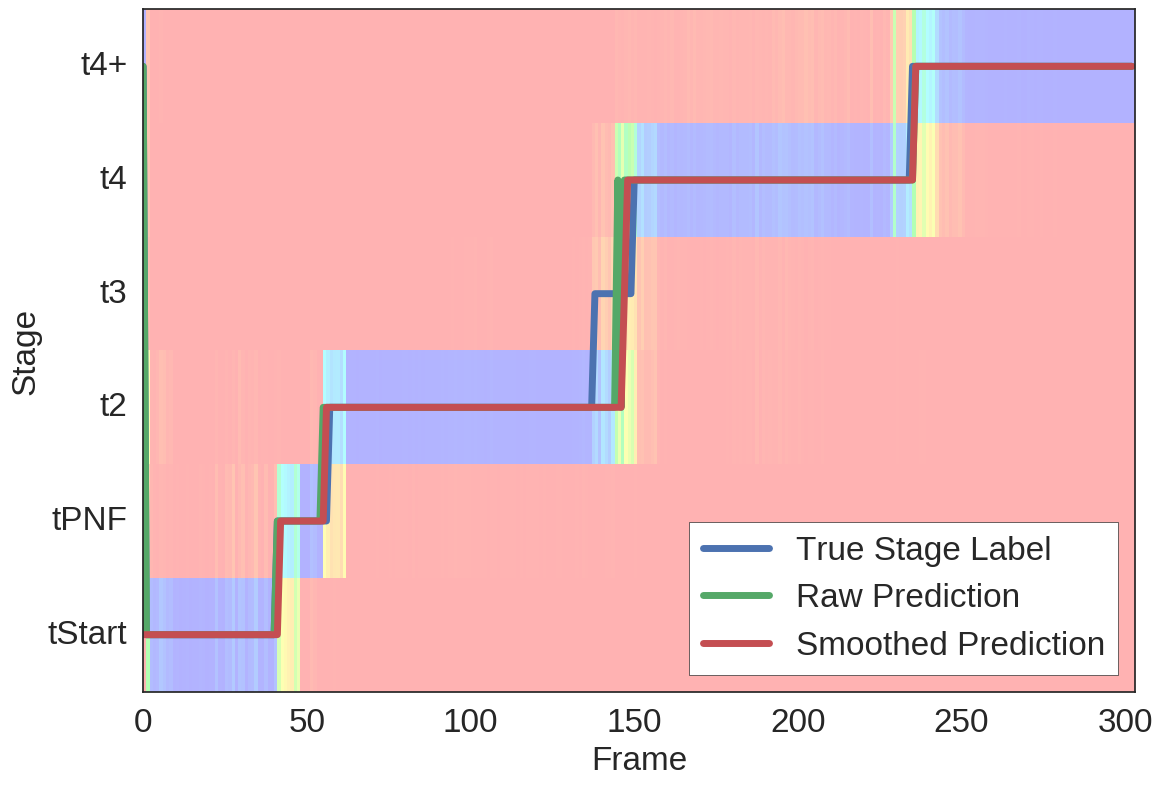

video: 50
15048 to 15351


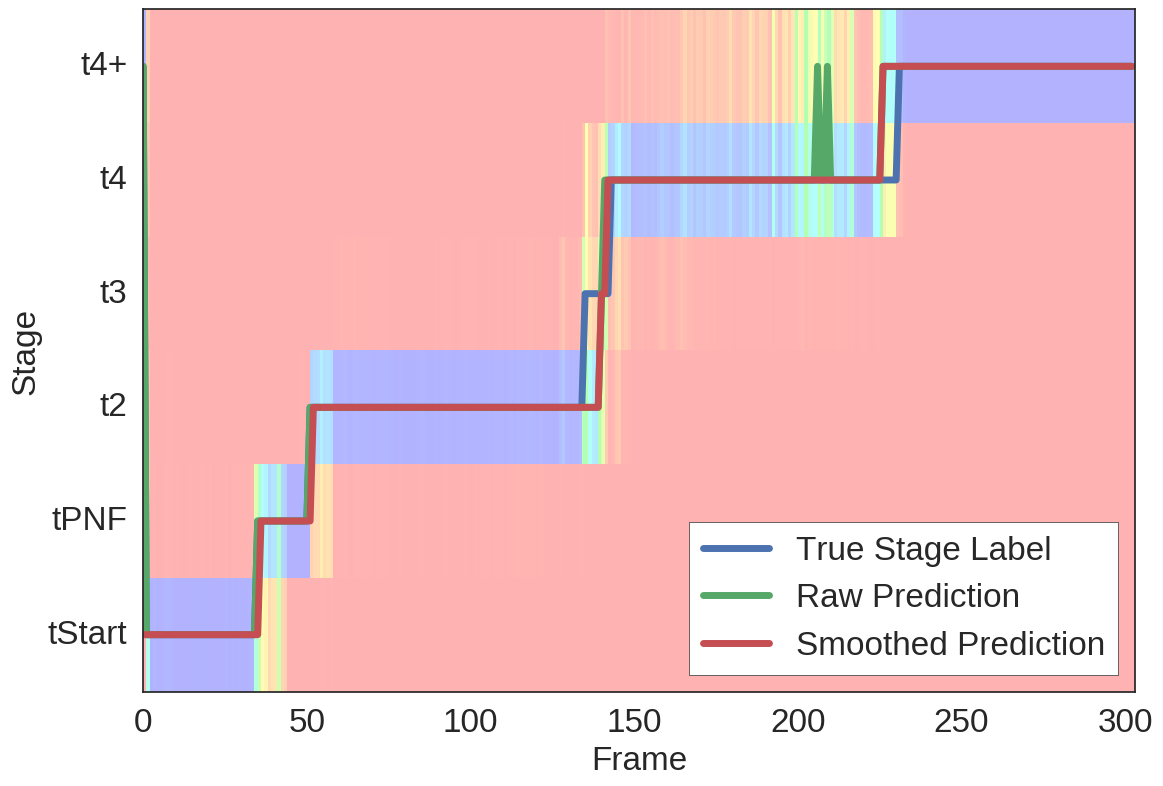

video: 51
15351 to 15659


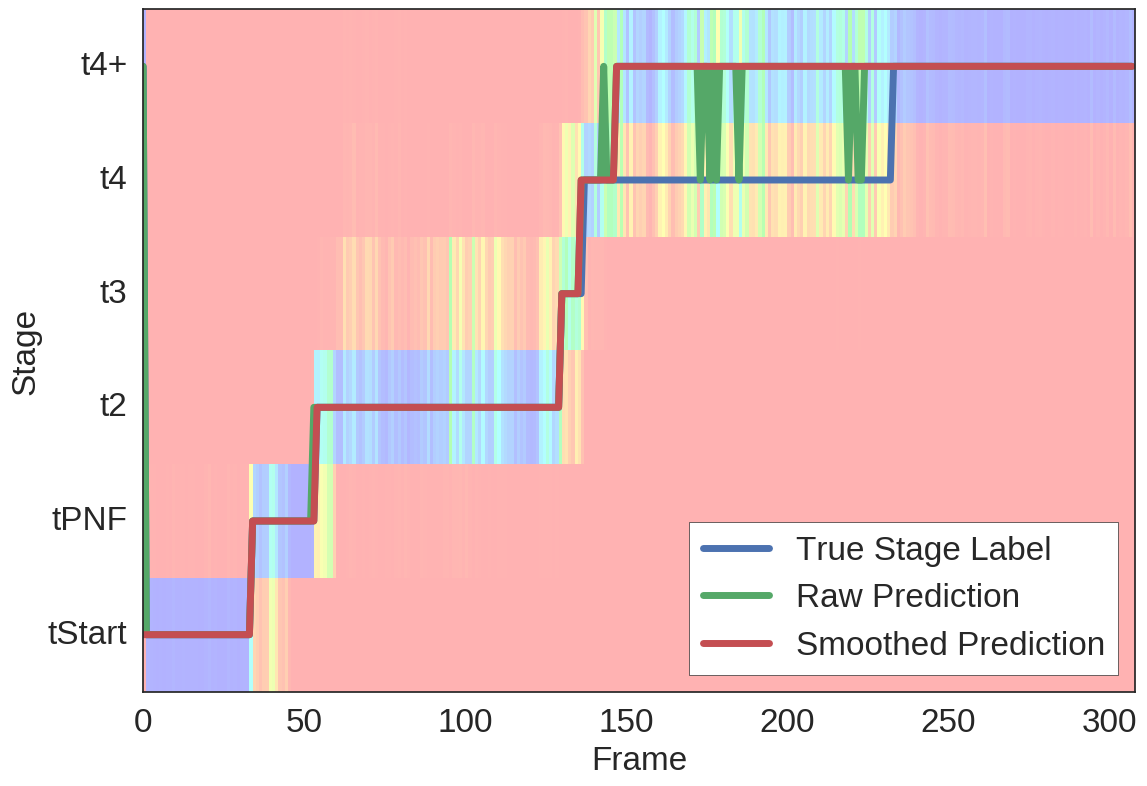

video: 52
15659 to 15967


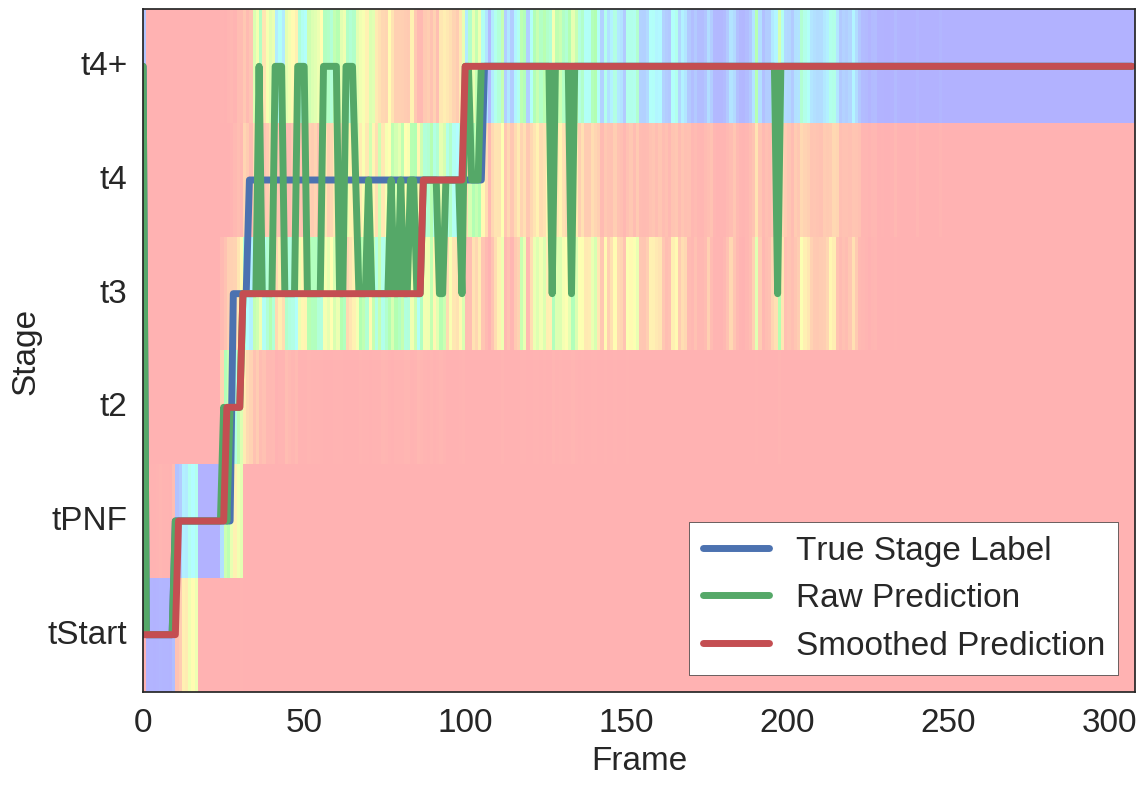

video: 53
15967 to 16275


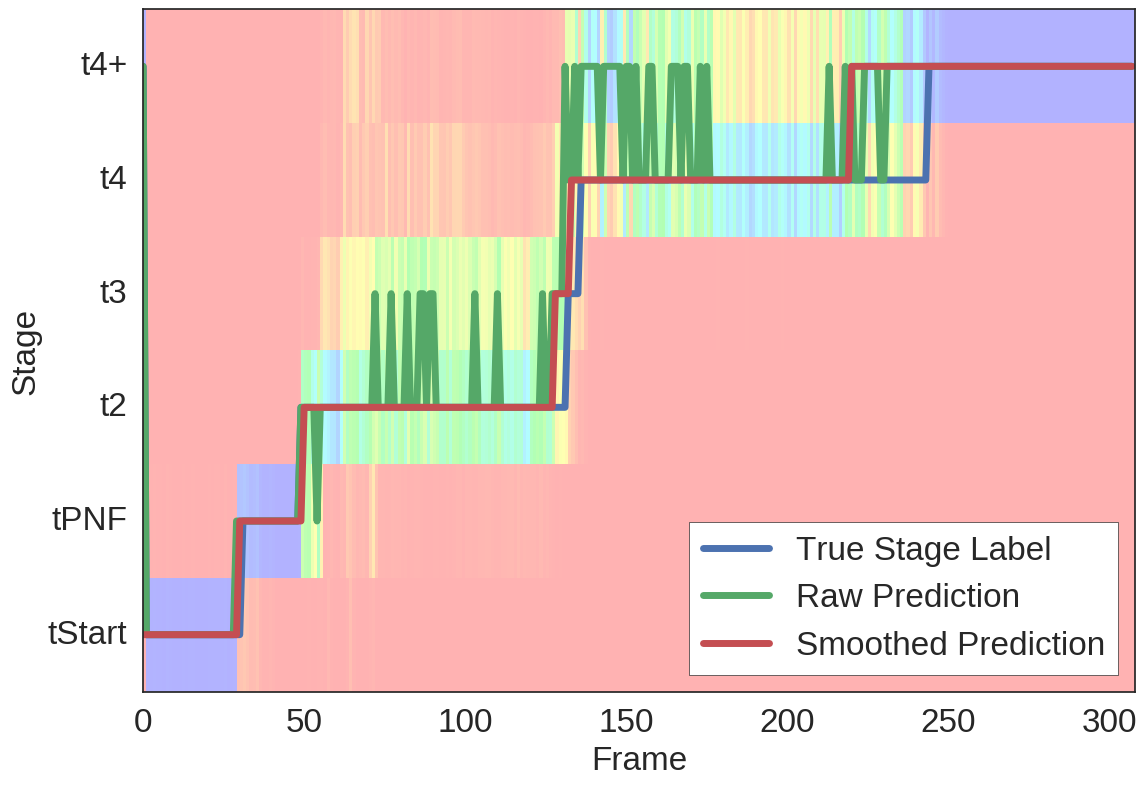

video: 54
16275 to 16583


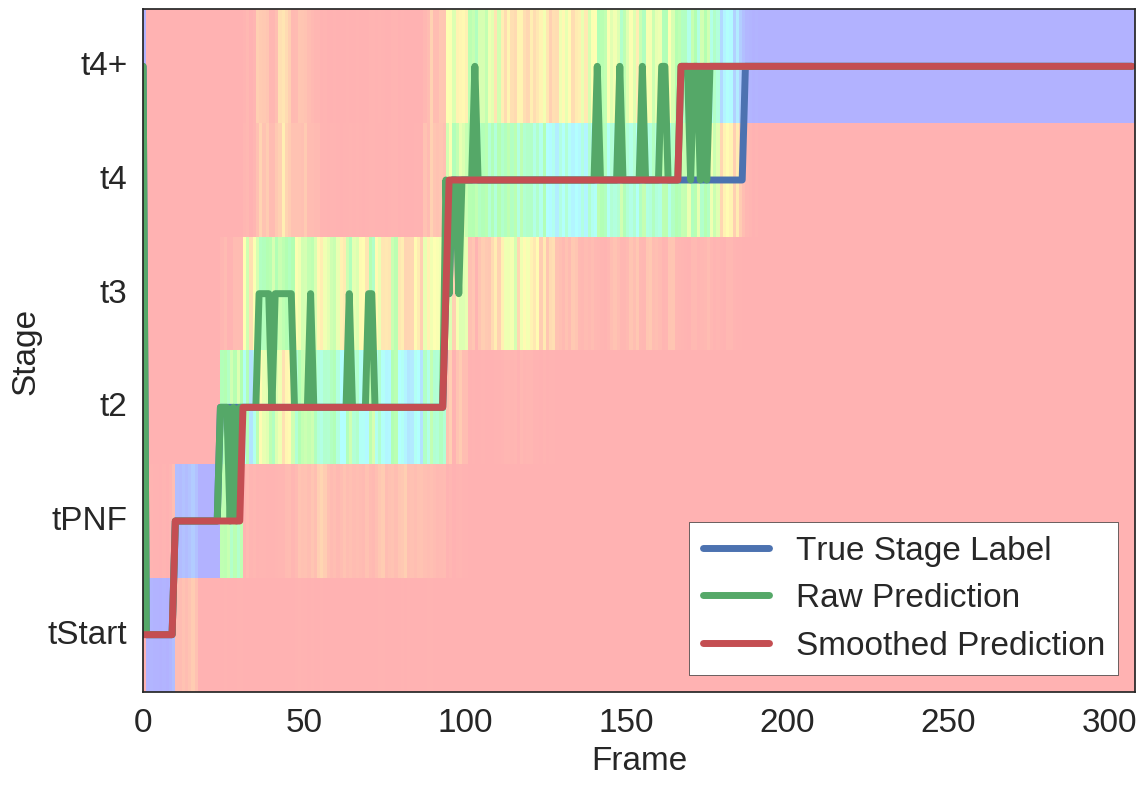

video: 55
16583 to 16891


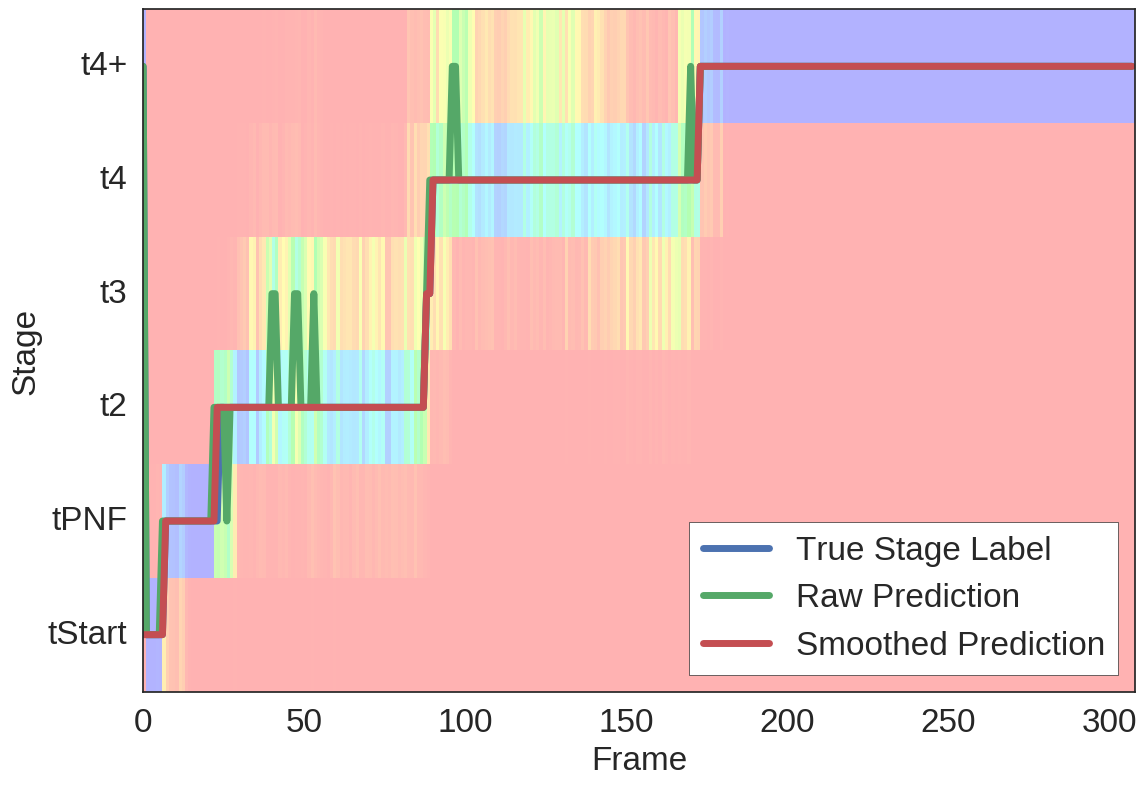

video: 56
16891 to 17199


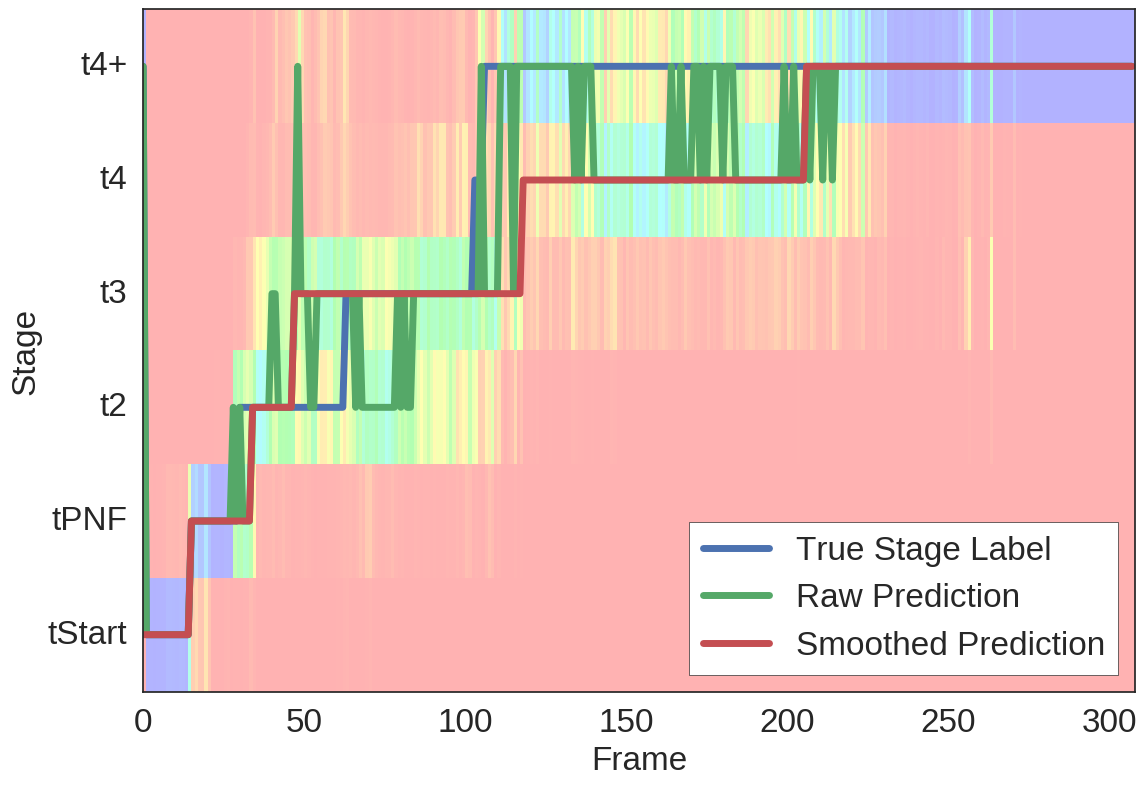

video: 57
17199 to 17507


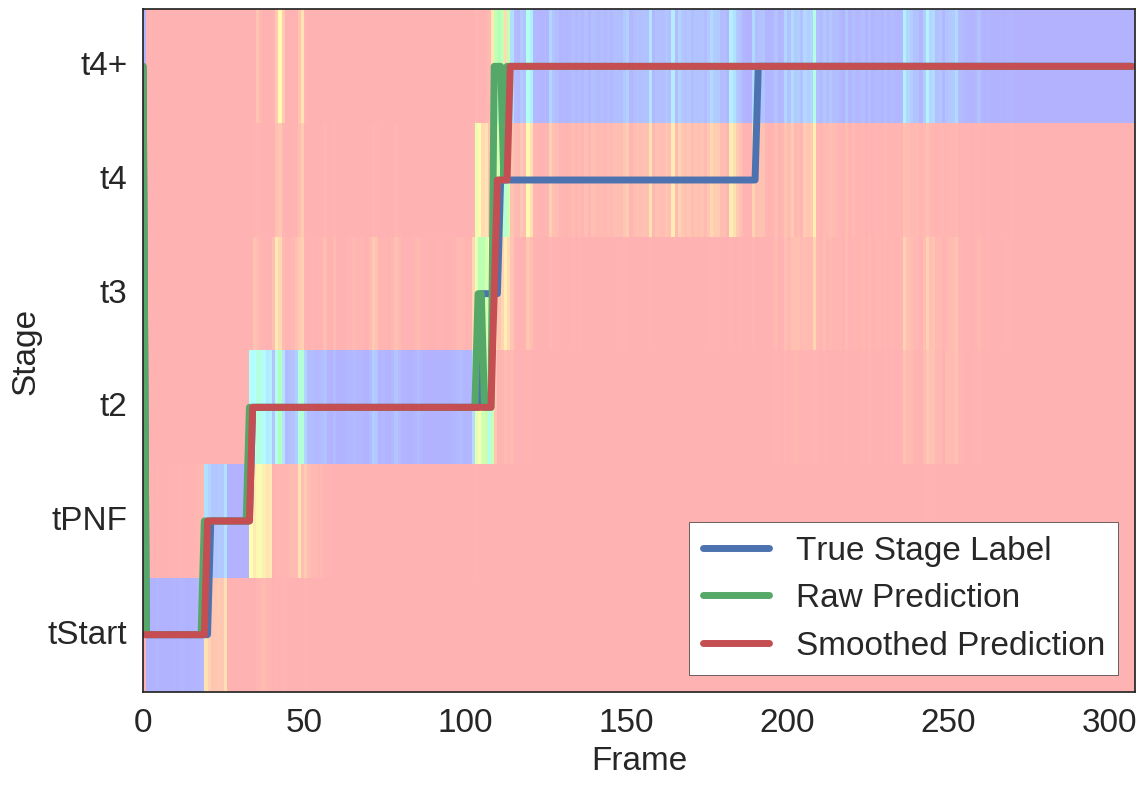

video: 58
17507 to 17815


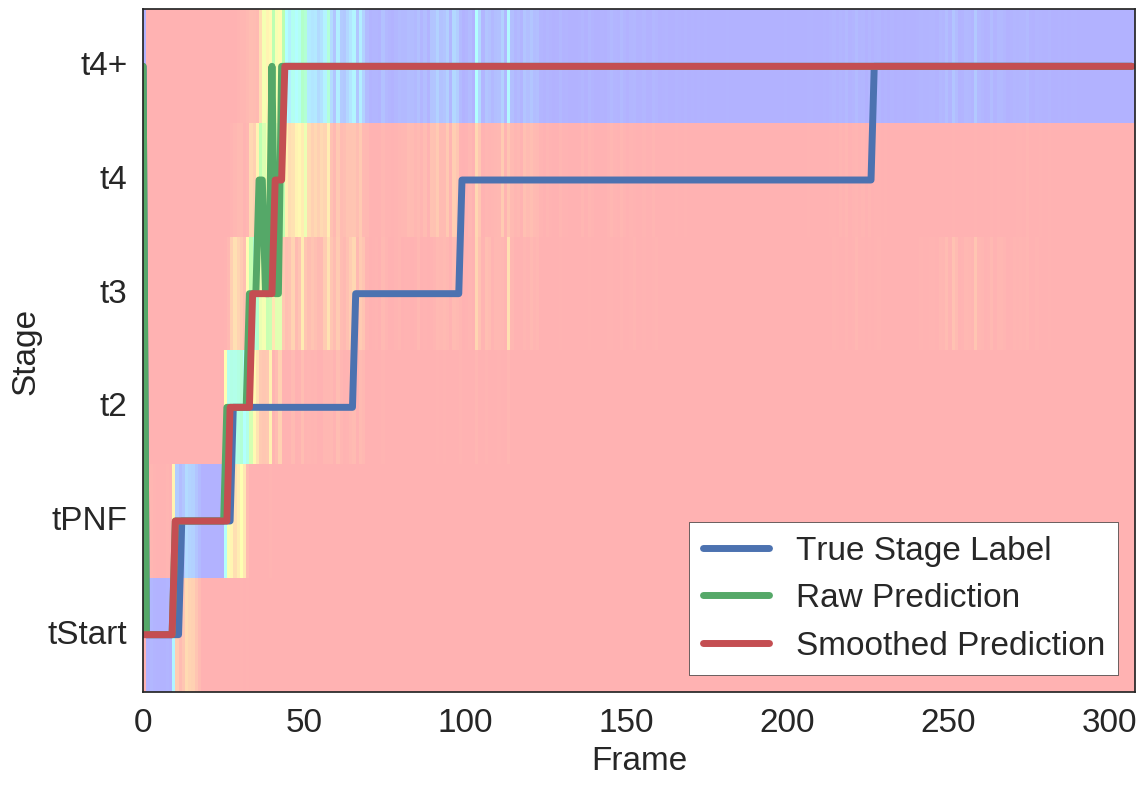

video: 59
17815 to 18123


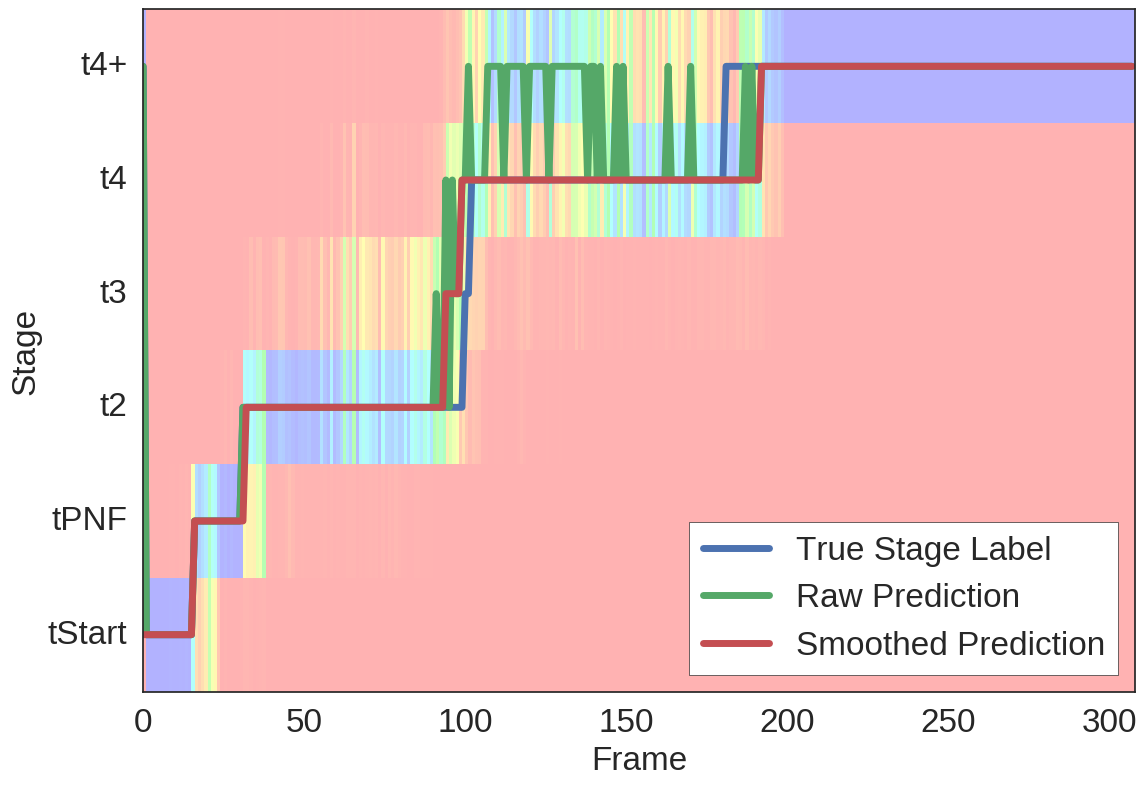

video: 60
18123 to 18431


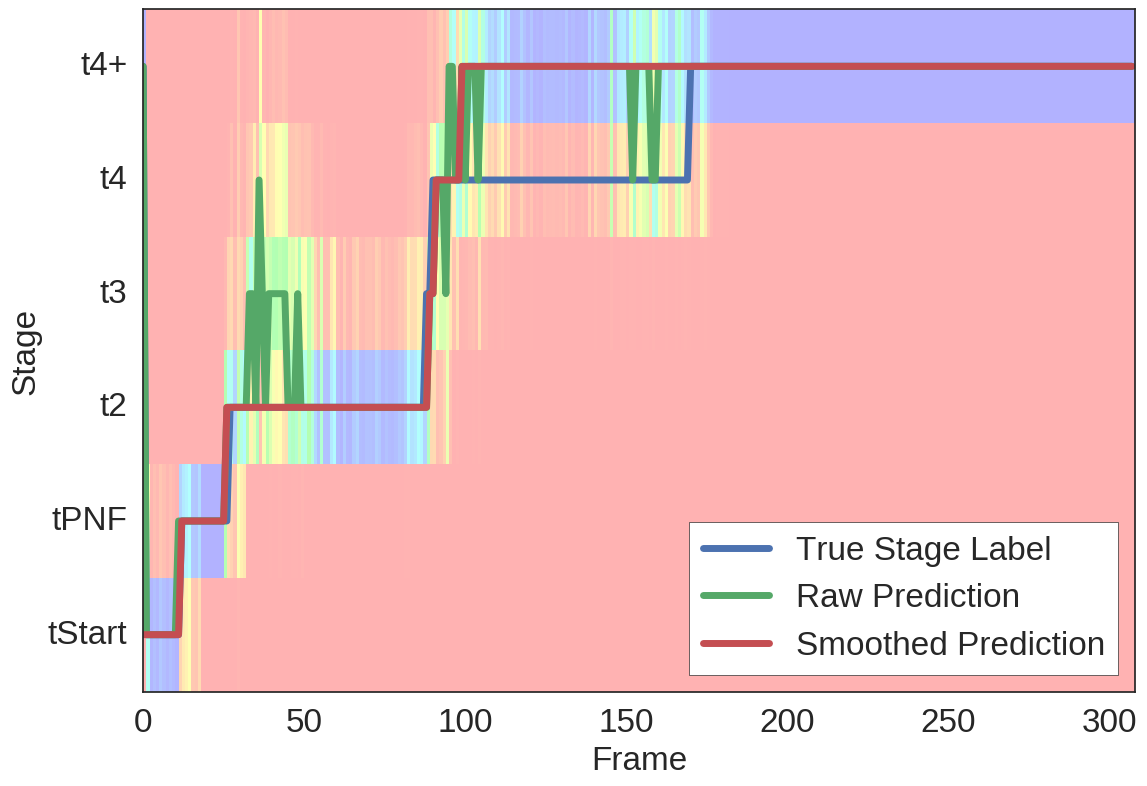

video: 61
18431 to 18737


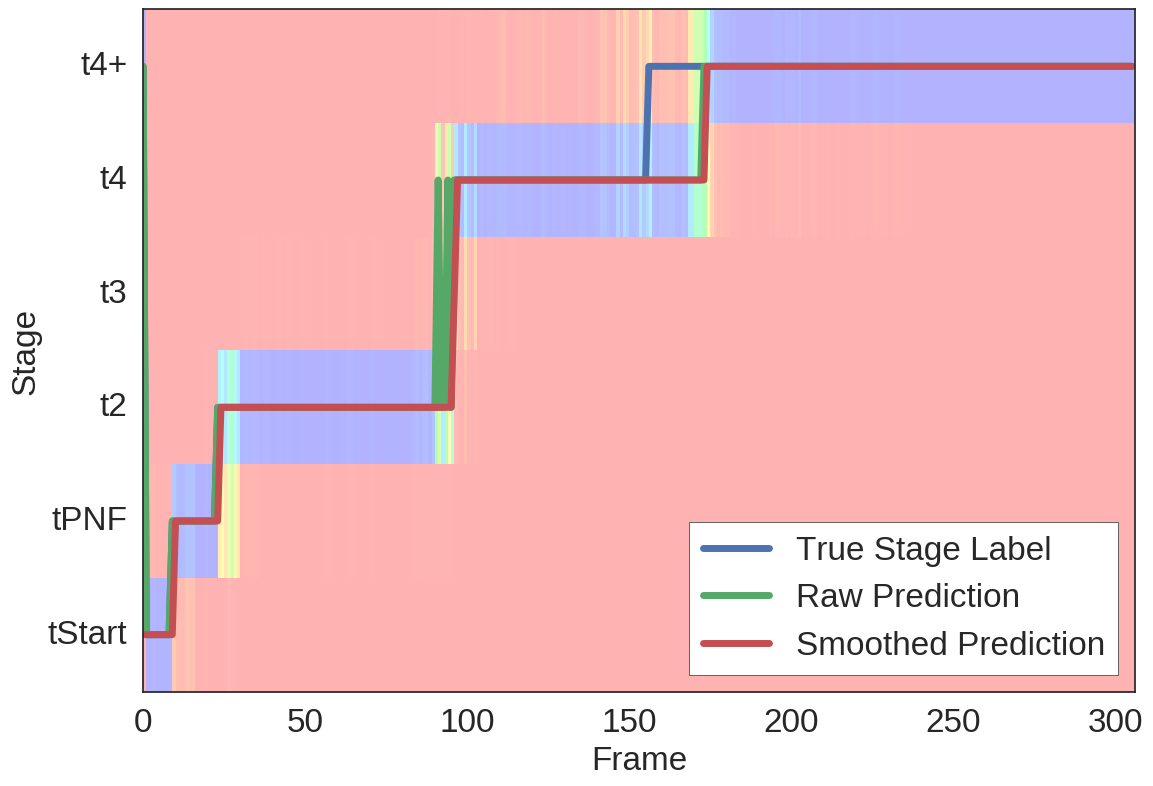

video: 62
18737 to 19043


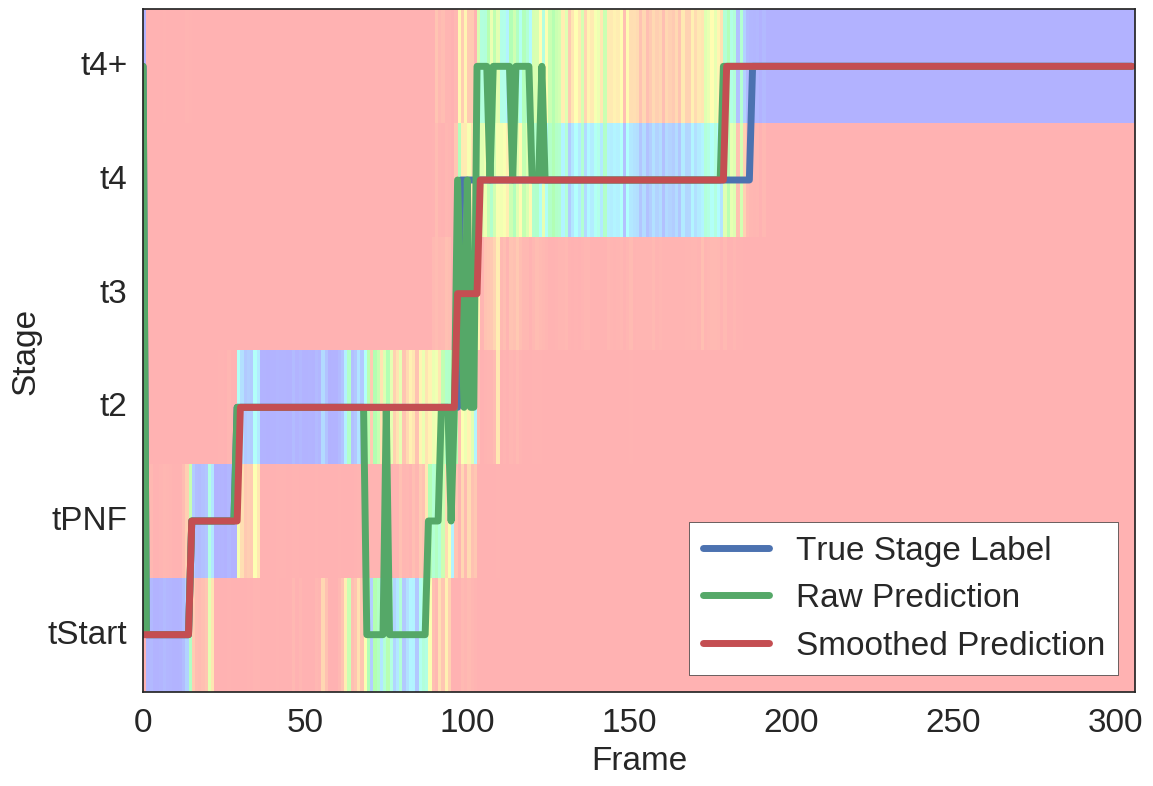

video: 63
19043 to 19349


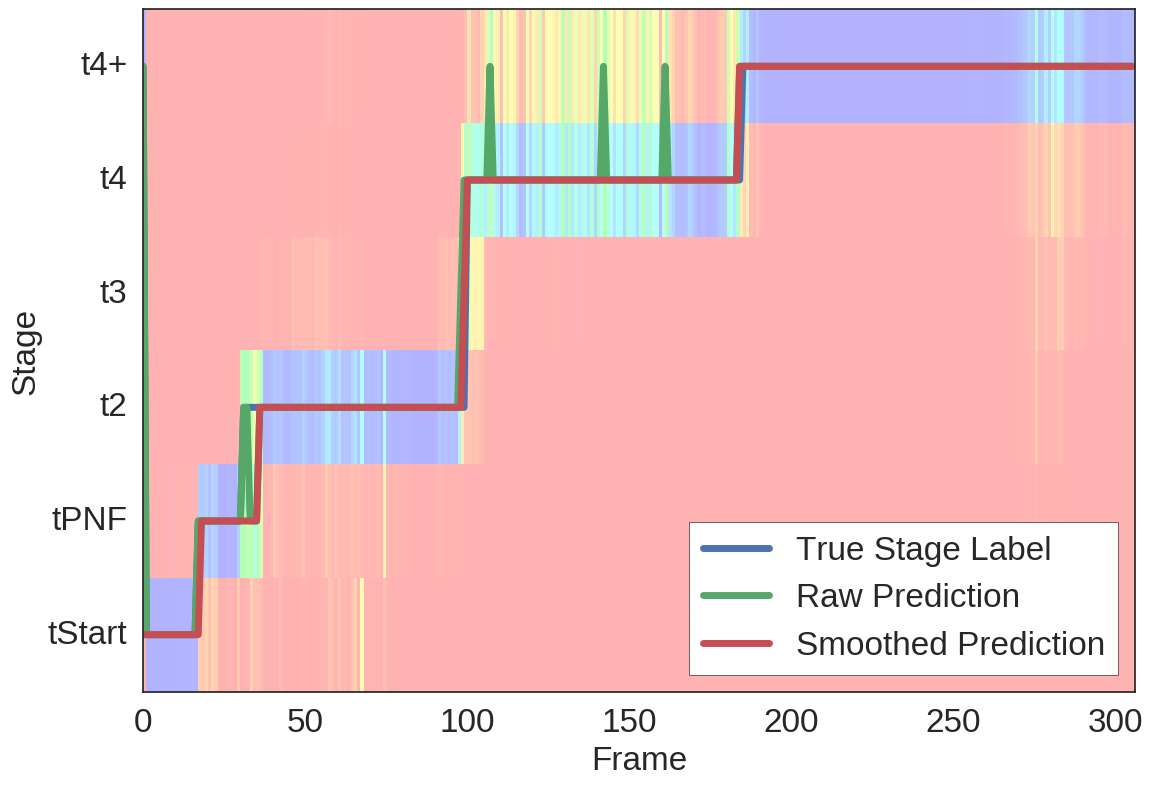

video: 64
19349 to 19655


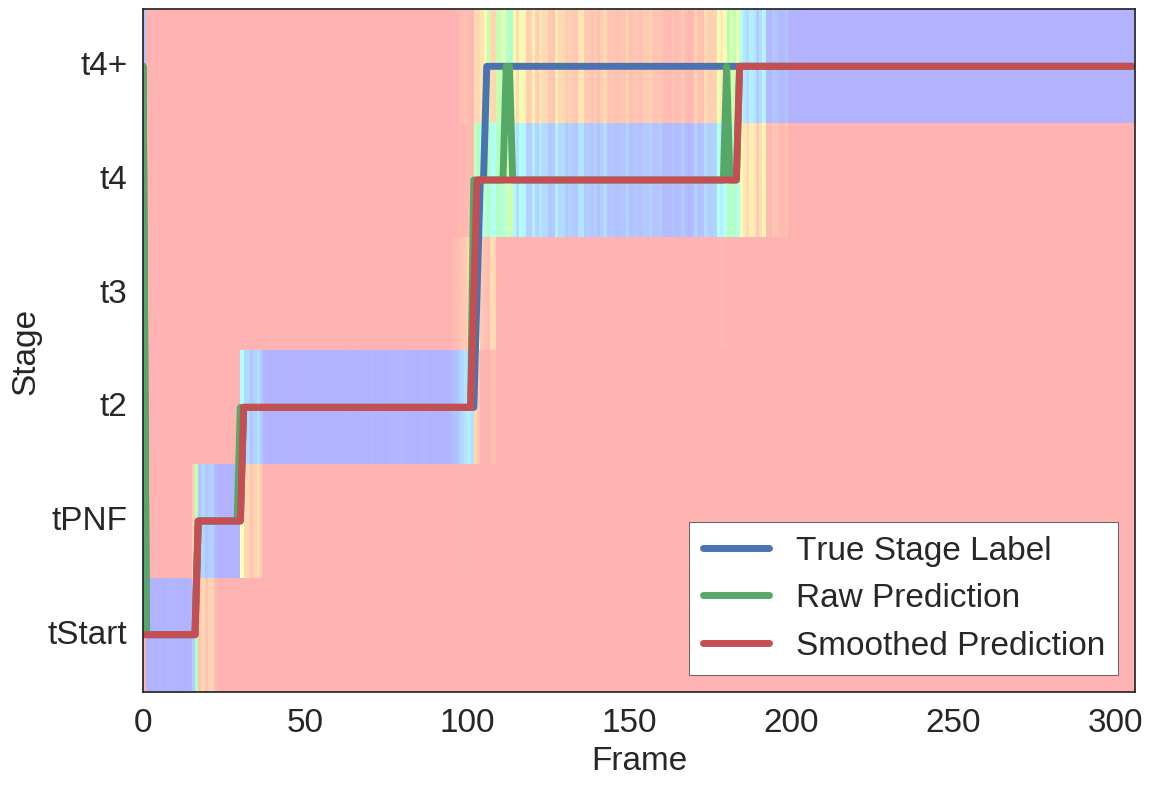

video: 65
19655 to 19961


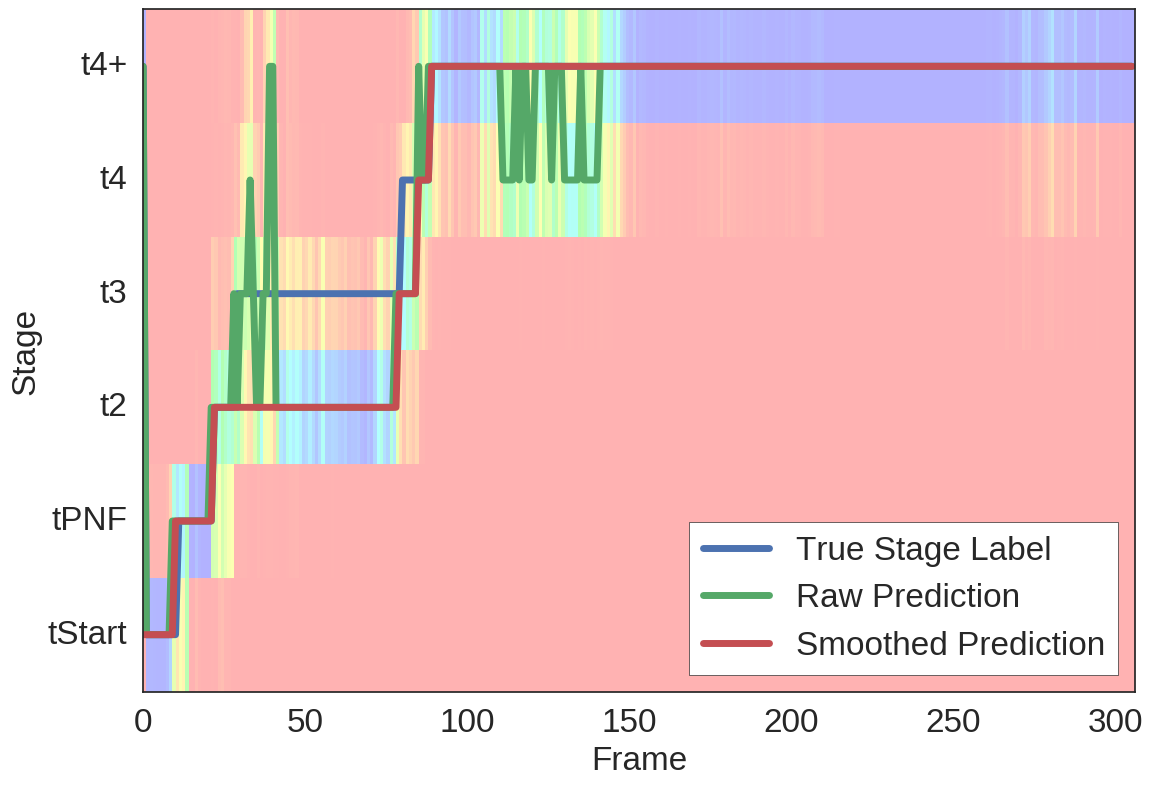

video: 66
19961 to 20267


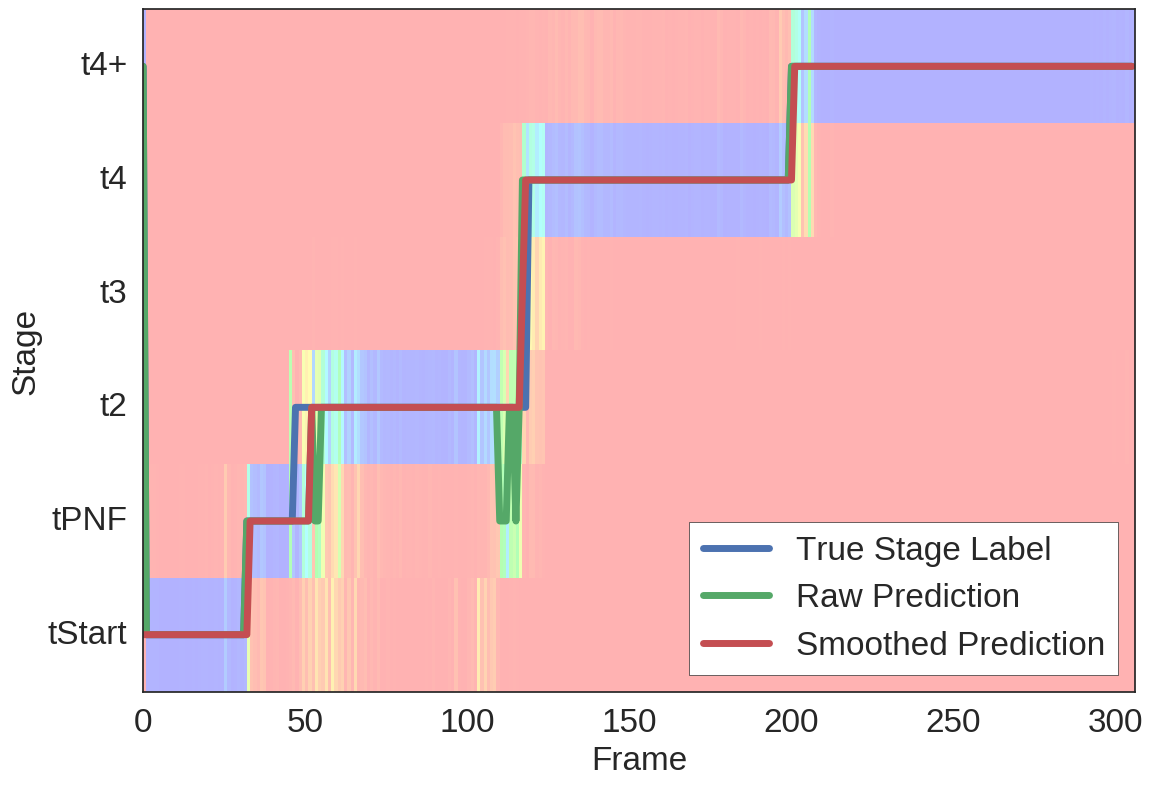

video: 67
20267 to 20573


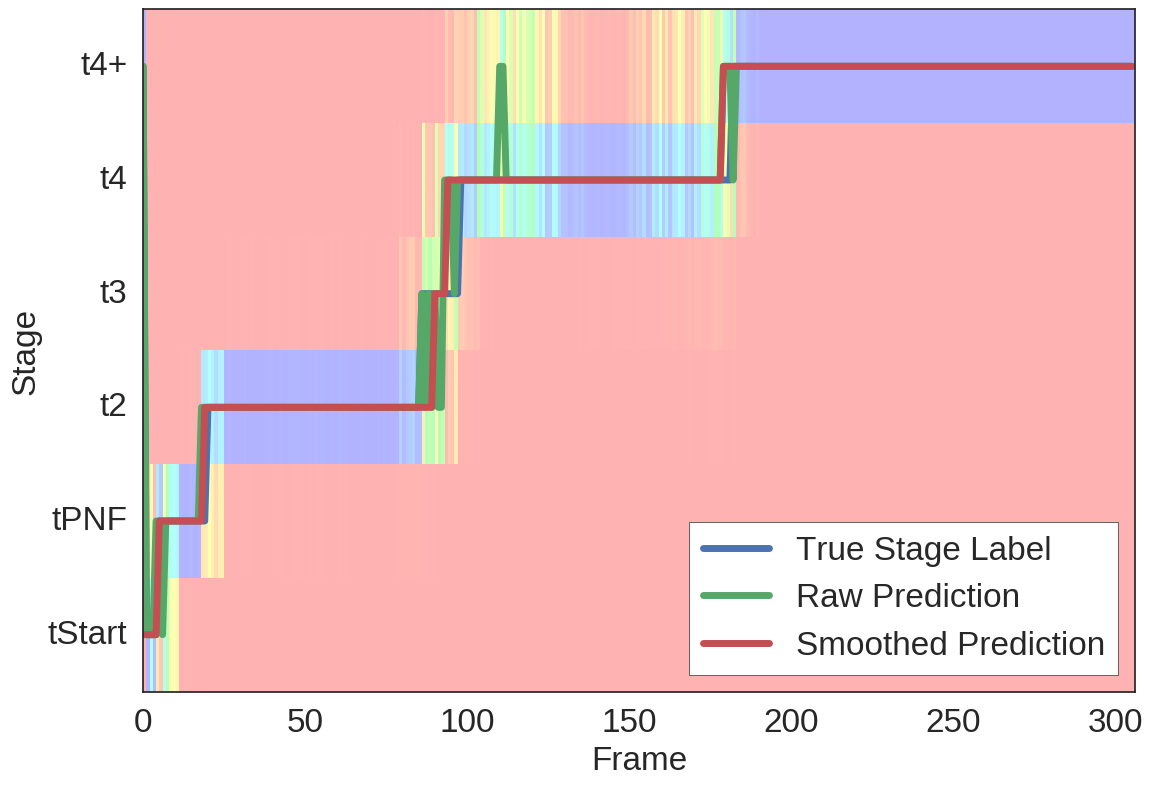

video: 68
20573 to 20879


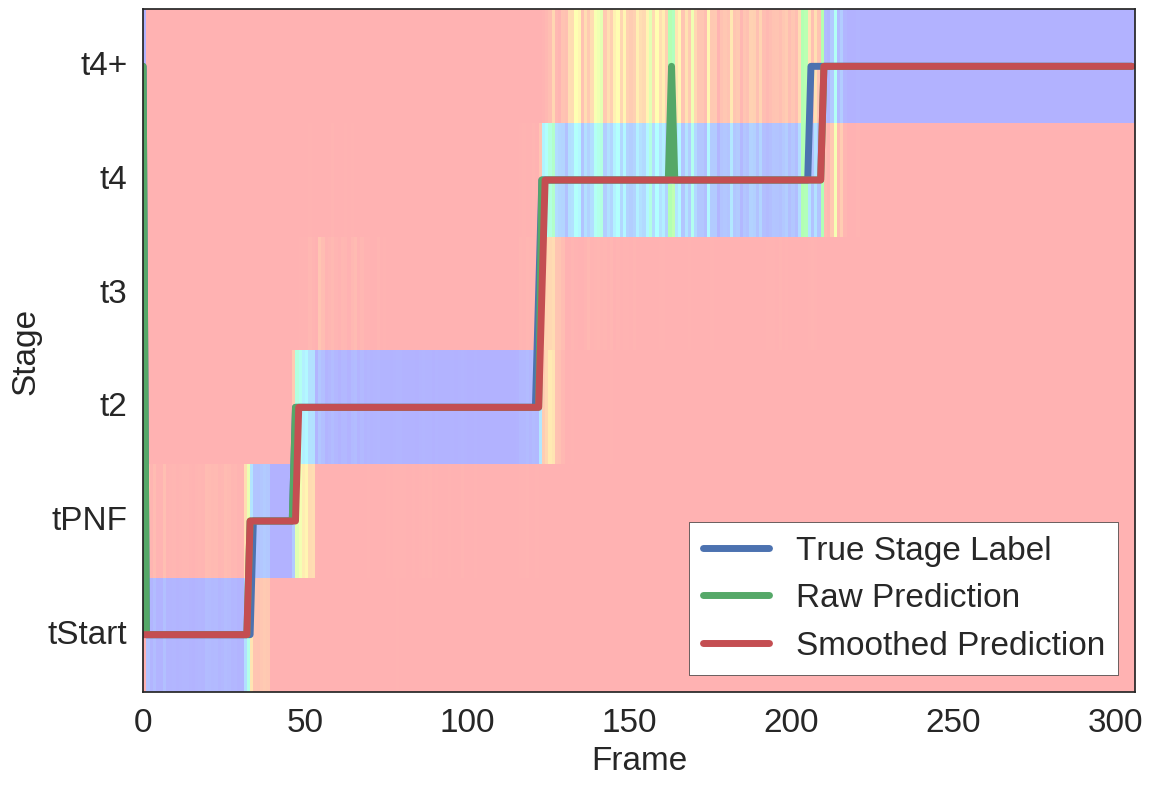

video: 69
20879 to 21185


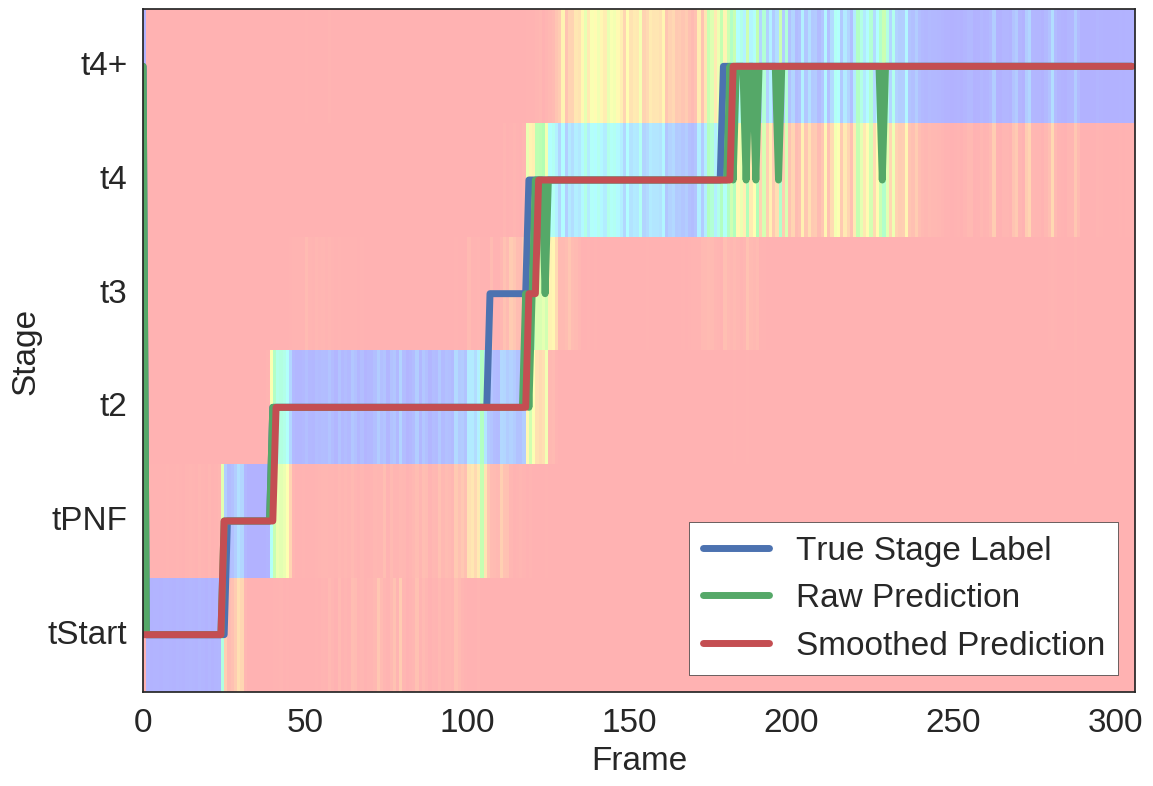

video: 70
21185 to 21491


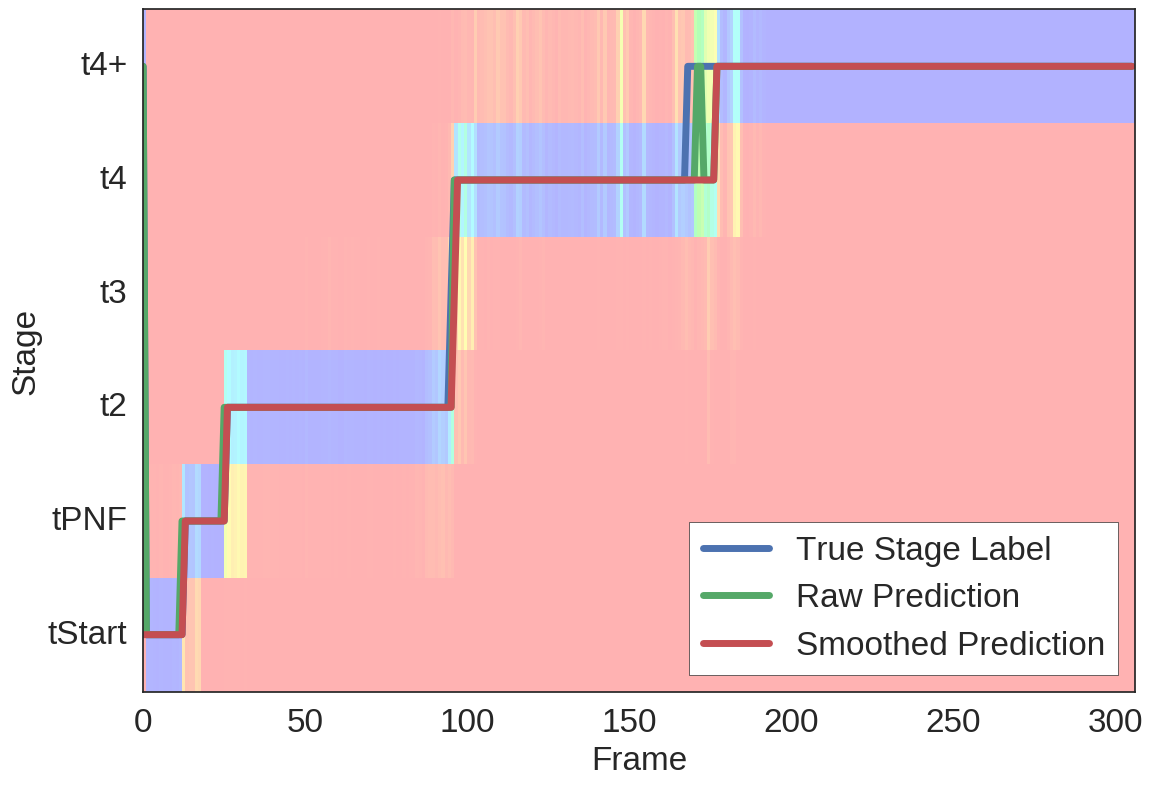

video: 71
21491 to 21796


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

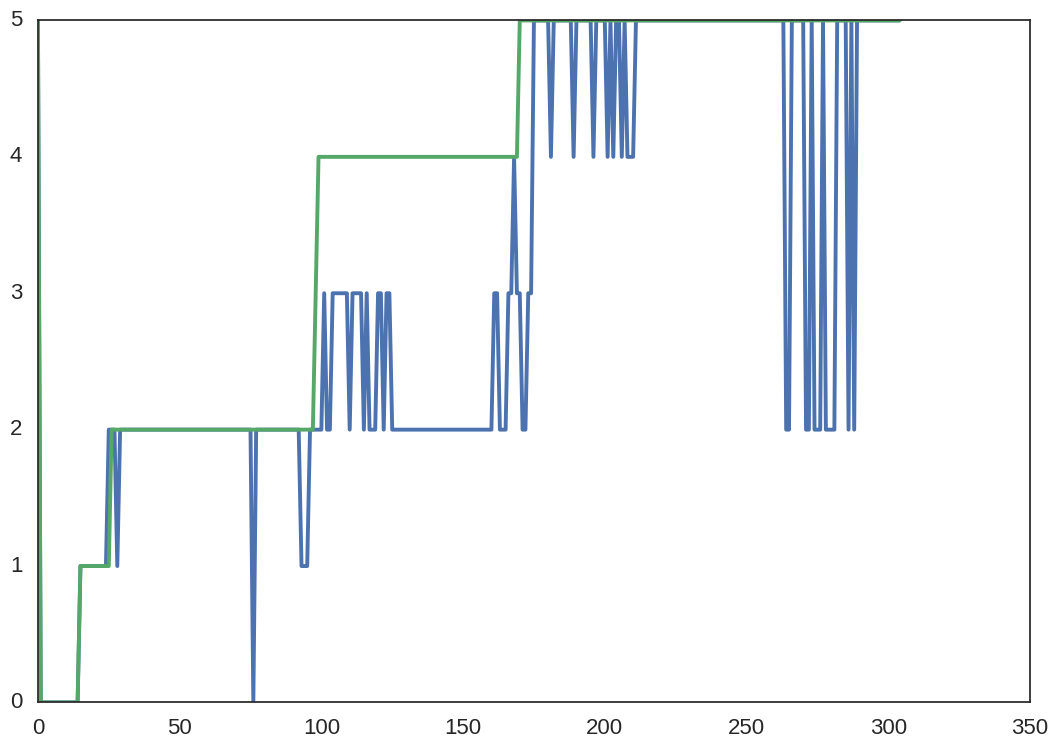

In [48]:
last = 0
vid = 1
sns.set_context("poster")
for i in range(len(target)-1):
    if target[i] > target[i+1]:
        print("video: " + str(vid))
        print(str(last) + " to " + str(i))
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        for j in range(i-last):
            for k in range(6):
                fillc = colors[int(stages[last+j][k] * 1000)].rgb
                ax1.add_patch(patches.Rectangle((j, k-0.5), 1, 1, fill=True, alpha=0.3, lw=0, color=fillc))
        plt.plot(target[last:i], linewidth=5, label="True Stage Label")
        plt.plot(np.asarray(preds)[last:i], linewidth=5, label="Raw Prediction")
        splits = find_splits(stages[last:i], 6, True)
        plt.plot(smooth_pred(splits, 6, i-last), linewidth=5, label="Smoothed Prediction")
        plt.ylim(-0.5, 5.5)
        plt.xlim(0, i-last)
        plt.xlabel("Frame", fontsize=24)
        plt.ylabel("Stage", fontsize=24)
        ax1.tick_params(labelsize=24)
        plt.yticks(np.arange(6), ['tStart', 'tPNF', 't2', 't3', 't4', 't4+'])
        plt.legend(loc=4, frameon=True, prop={'size': 24})
        plt.show()
        last = i
        vid += 1
print("video: " + str(vid))
print(str(last) + " to " + str(i))
plt.plot(np.asarray(preds)[last:i])
plt.plot(target[last:i])
plt.plot(smooth_pred(stages[last:i], 6, True))
plt.ylim(0, 6)
plt.xlim(0, i-last)
plt.show()

In [33]:
blue = Color("red")
colors = list(blue.range_to(Color("blue"), 1000))
sns.set_style("white")
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cm = ListedColormap([c.rgb for c in colors])
im = cbaxes.imshow(stages[:305], interpolation='nearest', origin='lower', cmap=cm, alpha=0.1)
im.set_alpha(0.3)
plt.colorbar(im, cax=cax)
plt.show()

NameError: name 'cbaxes' is not defined

In [29]:
smoothed = []
last = 0
for i in range(len(target)-1):
    if target[i] > target[i+1]:
        smoothed.extend(smooth_pred(stages[last:i], 6, i-last))
        last = i
smoothed.extend(smooth_pred(stages[last:i+1], 6, i-last))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [50]:
len(smoothed)

0

In [50]:
range(6)

[0, 1, 2, 3, 4, 5]

In [ ]:
len(target)

In [ ]:
smoothed.append(5)

In [ ]:
np.sum(np.equal(np.asarray(smoothed), target))

In [ ]:
np.sum(np.equal(np.asarray(preds), target))

In [ ]:
18150.0/21798

In [ ]:
17907/21798.0

In [ ]:
last = 0
splits = []
tmp = []
for i in range(len(target)-1):
    if target[i] > target[i+1]:
        if len(tmp) == 4:
            tmp.append(i-last)
        splits.append(tmp)
        tmp = []
        last = i
    for j in range(target[i+1] - target[i]):
        tmp.append(i-last)
splits.append(tmp)

In [ ]:
last = 0
splitPred = []
for i in range(len(target)-1):
    if target[i] > target[i+1]:
        splitPred.append(find_splits(stages[last:i], transsig[last:i], 6))
        last = i
splitPred.append(find_splits(stages[last:i], transsig[last:i], 6))

In [ ]:
len(splitPred)

In [ ]:
len(splits)

In [ ]:
[a - b for (a,b) in zip(splitPred,splits)]

In [ ]:
splitPred = np.asarray(splitPred)
splits = np.asarray(splits)

In [ ]:
np.sum(np.abs(splits - splitPred)**2)

In [ ]:
3979.0/(71*5)

In [ ]:
np.sqrt(225417/(71*5))

In [ ]:
plt.hist((splits-splitPred).flatten().tolist())
plt.show()

In [ ]:
(splits-splitPred).flatten().tolist()